# Анализ данных с временой структурой
# Проект 2

#### Участники:<br>
**Ванифатов Кирилл**<br>
**Молоков Андрей**

Задача:
Построить автоматизированный пайплайн для прогнозирования значений временного ряда

Требования:
- Выбор оптимизируемой метрики должен быть основан на потребностях бизнеса
- Модель может использовать внешние факторы (см подсказки)

- Модель должна иметь модуль отбора признаков
- Метод отбора должен быть болеее стабильным относительно альтернатив
- Сравнение должно быть проведено минимум с одним методом из каждой категории: встроенные, оберточные и фильтрационные
- При этом как минимум одна из альтернатив должа исследовать нелинейную зависимость

- Модель должна автоматически подбирать гиперпараметры, оптимизируя целевую метрику

- Для модели должна быть подобрана частота калибровки, если модель калибруется долго, и проверена ее достаточность

- Блоки должны быть подписаны и кратко описаны (чем руководствовались при реализации, как работает)
- Модель должна автоматически дообучаться
- Все модули должны работать без ручных корректировок
- Выбор периода для дообучения должен быть обоснован

- В модели должен быть модуль выявления разладки для подачи сигнала о возможной необходимости переключения на ручное управление процессом/внеплановое дообучение

Подсказки:
- Можно использовать факторы, сконструированные из таргета (лаги, средние и т.п.)
- Могут помочь макроэкономические факторы
- Могут помочь даты налоговых дней

Описание бизнес-процесса:
- Прогнозная величина позволяет установить сальдо поступлений и списаний за день
- На основании прогноза позиционер (управляет ликвидностью) принимает решение о выделении средств на размещение на рынке деривативов для получения дополнительной маржи (доходность считать примерно ключ+0.5%)
- В случае, если на конец дня образуется профицит ликвидности, его можно разместить в ЦБ по overnight ставке, равной ключу-0.9%
- В случае, если на конец дня образуется дефицит ликвидности, его можно покрыть за счет займа по overnight ставке, равной ключ+1%

In [500]:
# !pip3 install statsmodels
# !pip3 install seaborn
# !pip3 install scikit-learn
# !pip3 install arch

In [618]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import random

import warnings 
warnings.filterwarnings('ignore')

In [502]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.stattools import adfuller, kpss

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

import scipy.stats as scs
import statsmodels.api as sm

np.random.seed(42)
# import statsmodels as smt

In [503]:
data_origin = pd.read_csv('Project_Data.csv')
data_origin.shape

(1543, 4)

In [504]:
data_origin['Date'] = pd.to_datetime(data_origin['Date']).dt.date
data_origin = data_origin.set_index('Date')
data_origin = data_origin.asfreq('D')
data_origin.head()

,Income,Outcome,Balance
Date,,,
2017-01-09,1.343028,1.487865,-0.155904
2017-01-10,1.068610,1.194182,-0.125572
2017-01-11,0.944429,0.936663,0.007767
2017-01-12,1.672202,0.875379,0.800391
2017-01-13,0.955924,0.975645,-0.019721


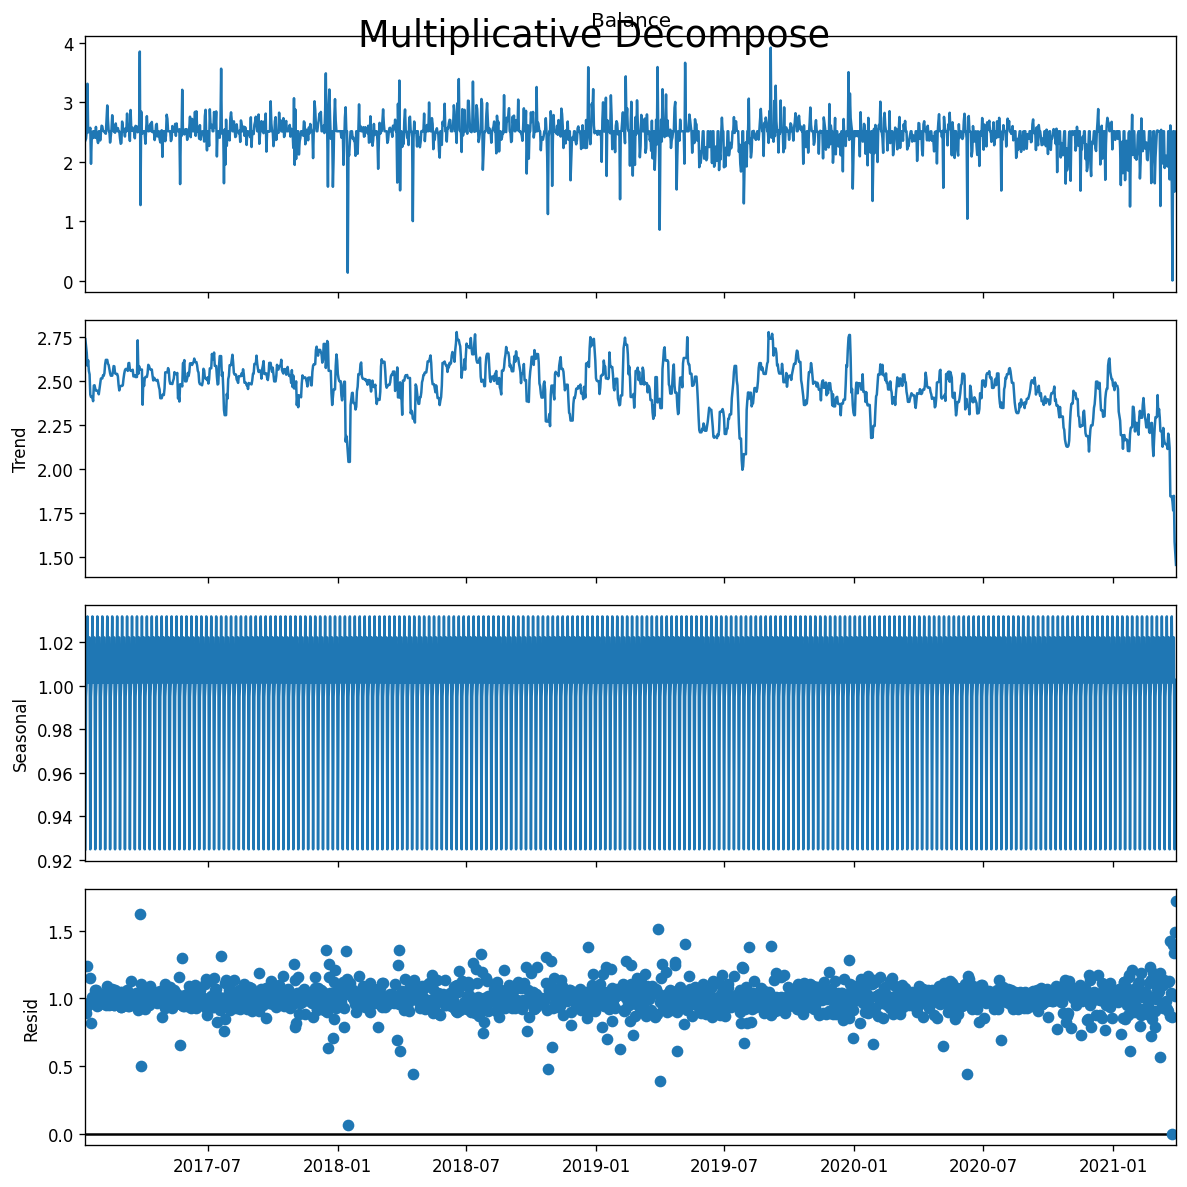

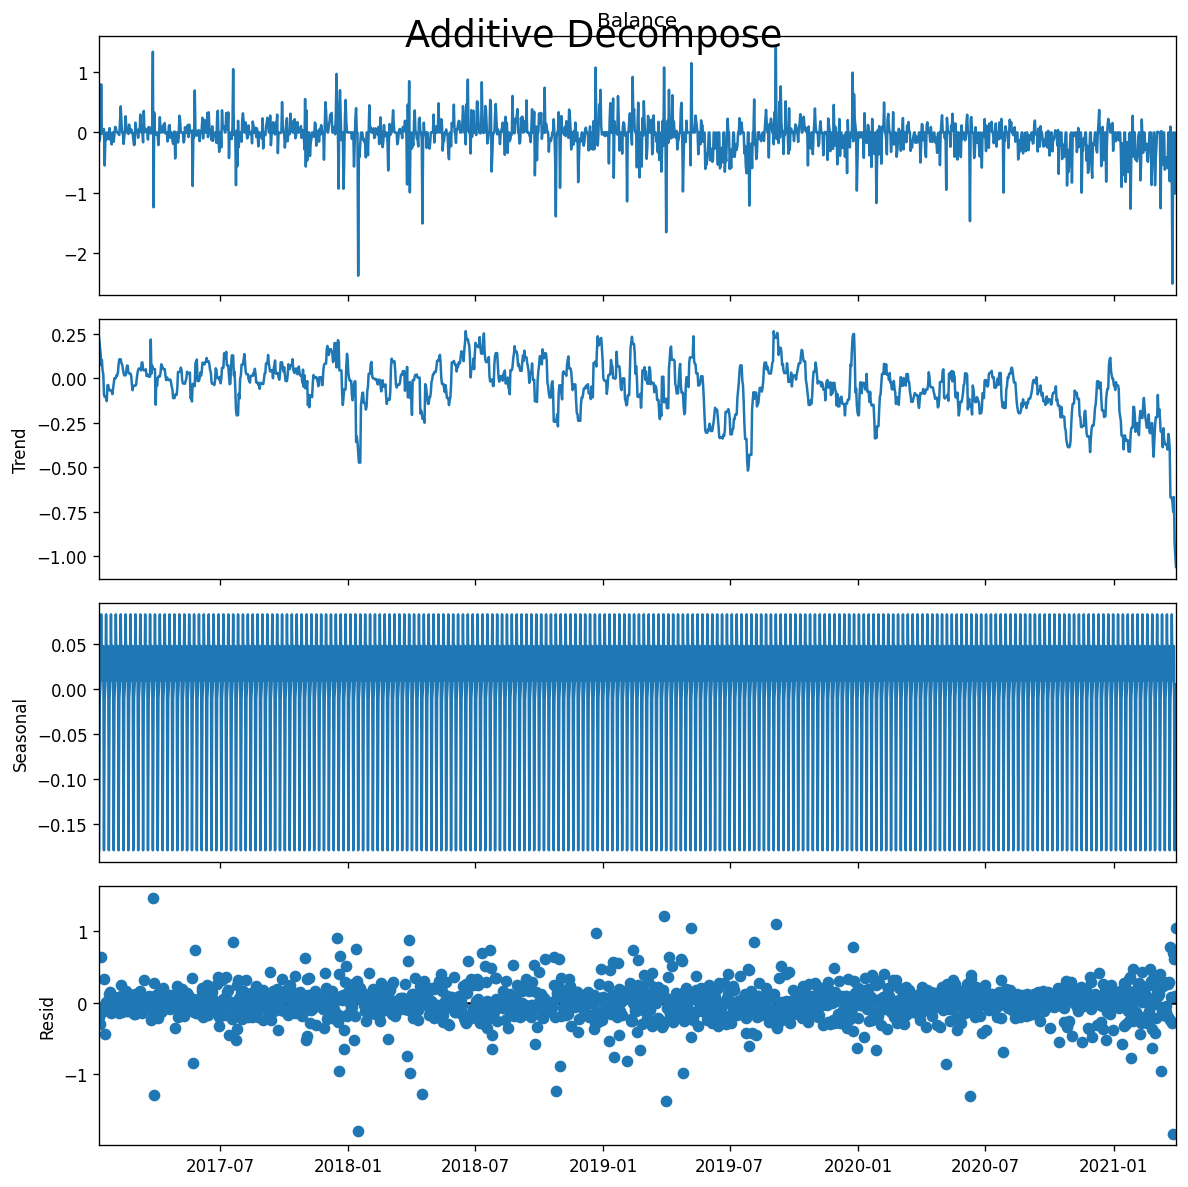

In [505]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(data_origin['Balance'] + abs(data_origin['Balance'].min())+0.000001, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(data_origin['Balance'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [506]:
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Date,,,,
2017-01-09,0.924902,2.738203,0.931459,2.358984
2017-01-10,0.994942,2.699560,0.889576,2.389315
2017-01-11,1.002635,2.660917,0.945548,2.522654
2017-01-12,1.031763,2.587311,1.241914,3.315278
2017-01-13,1.001498,2.617868,0.951704,2.495166


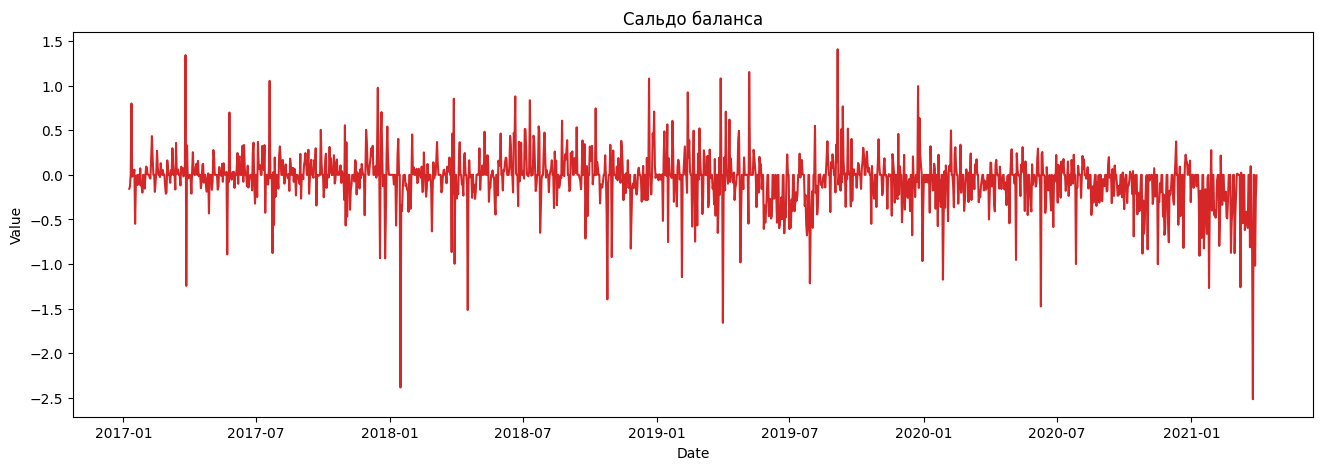

In [507]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(data_origin, x=data_origin.index, y=data_origin.Balance, title='Сальдо баланса')    


#### ACF

Количественной характеристикой сходства между значениями ряда в соседних точках является автокорреляционная функция (или просто автокорреляция), которая задаётся следующим соотношением:
$$r_τ = \frac{E((y_t − Ey)(y_{t-τ} − Ey))}{Dy}$$

**Автокорреляция** — это уже встречавшаяся ранее корреляция Пирсона между исходным рядом и его версией,
сдвинутой на несколько отсчётов. Количество отсчётов, на которое сдвинут ряд, называется лагом автокорреляции (τ ).

Вычислить автокорреляцию по выборке можно, заменив в формуле математическое ожидание на выборочное среднее, а дисперсию — на выборочную дисперсию.

Анализировать величину автокорреляции при разных значениях лагов удобно с помощью графика, который называется коррелограммой. По оси ординат на нём откладывается автокорреляция, а по оси абсцисс —
размер лага τ.

Как и для обычной корреляции Пирсона,
значимость вычисляется с помощью критерия Стьюдента. Альтернатива чаще всего двусторонняя, потому что при анализе временных рядов крайне редко имеется гипотеза о том, какой должна быть
корреляция, положительной или отрицательной.


временной ряд: $y^T = y_1, . . . , y_T$

нулевая гипотеза: $H_0 : r_τ = 0$

альтернатива: $H_1 : r_τ \neq 0$

статистика: $T(y^T) =\frac{ r_τ \sqrt{T - τ−2}}{\sqrt{1−r^2_τ}};$

нулевое распределение: $T(y^T) ∼ St(T − τ − 2).$





#### PACF

Частичная автокорреляция - это сводка взаимосвязи между наблюдением во временном ряду с наблюдениями на предыдущих временных этапах с удалением взаимосвязей между промежуточными наблюдениями.

**Частичная автокорреляция** при лаге k - это корреляция, возникающая после устранения влияния любых корреляций, связанных с членами с более короткими лагами.


Поскольку автоковариация стационарного  ряда зависит только от сдвига, то и автокорреляция – это функция только сдвига k,
$$ρ(k) = \frac{cov(y_t, y_{t−k} )}{σ^2_y} = \frac{γ(k)}{γ(0)}, k ≥ 0.$$


 По сути, вместо того, чтобы находить корреляции настоящего с лагами, такими как ACF, он находит корреляцию остатков (которая сохраняется после устранения эффектов, которые уже были объяснены более ранним лагом (ами)) со следующим значением лага, следовательно, «частичным», а не «полным». 
 


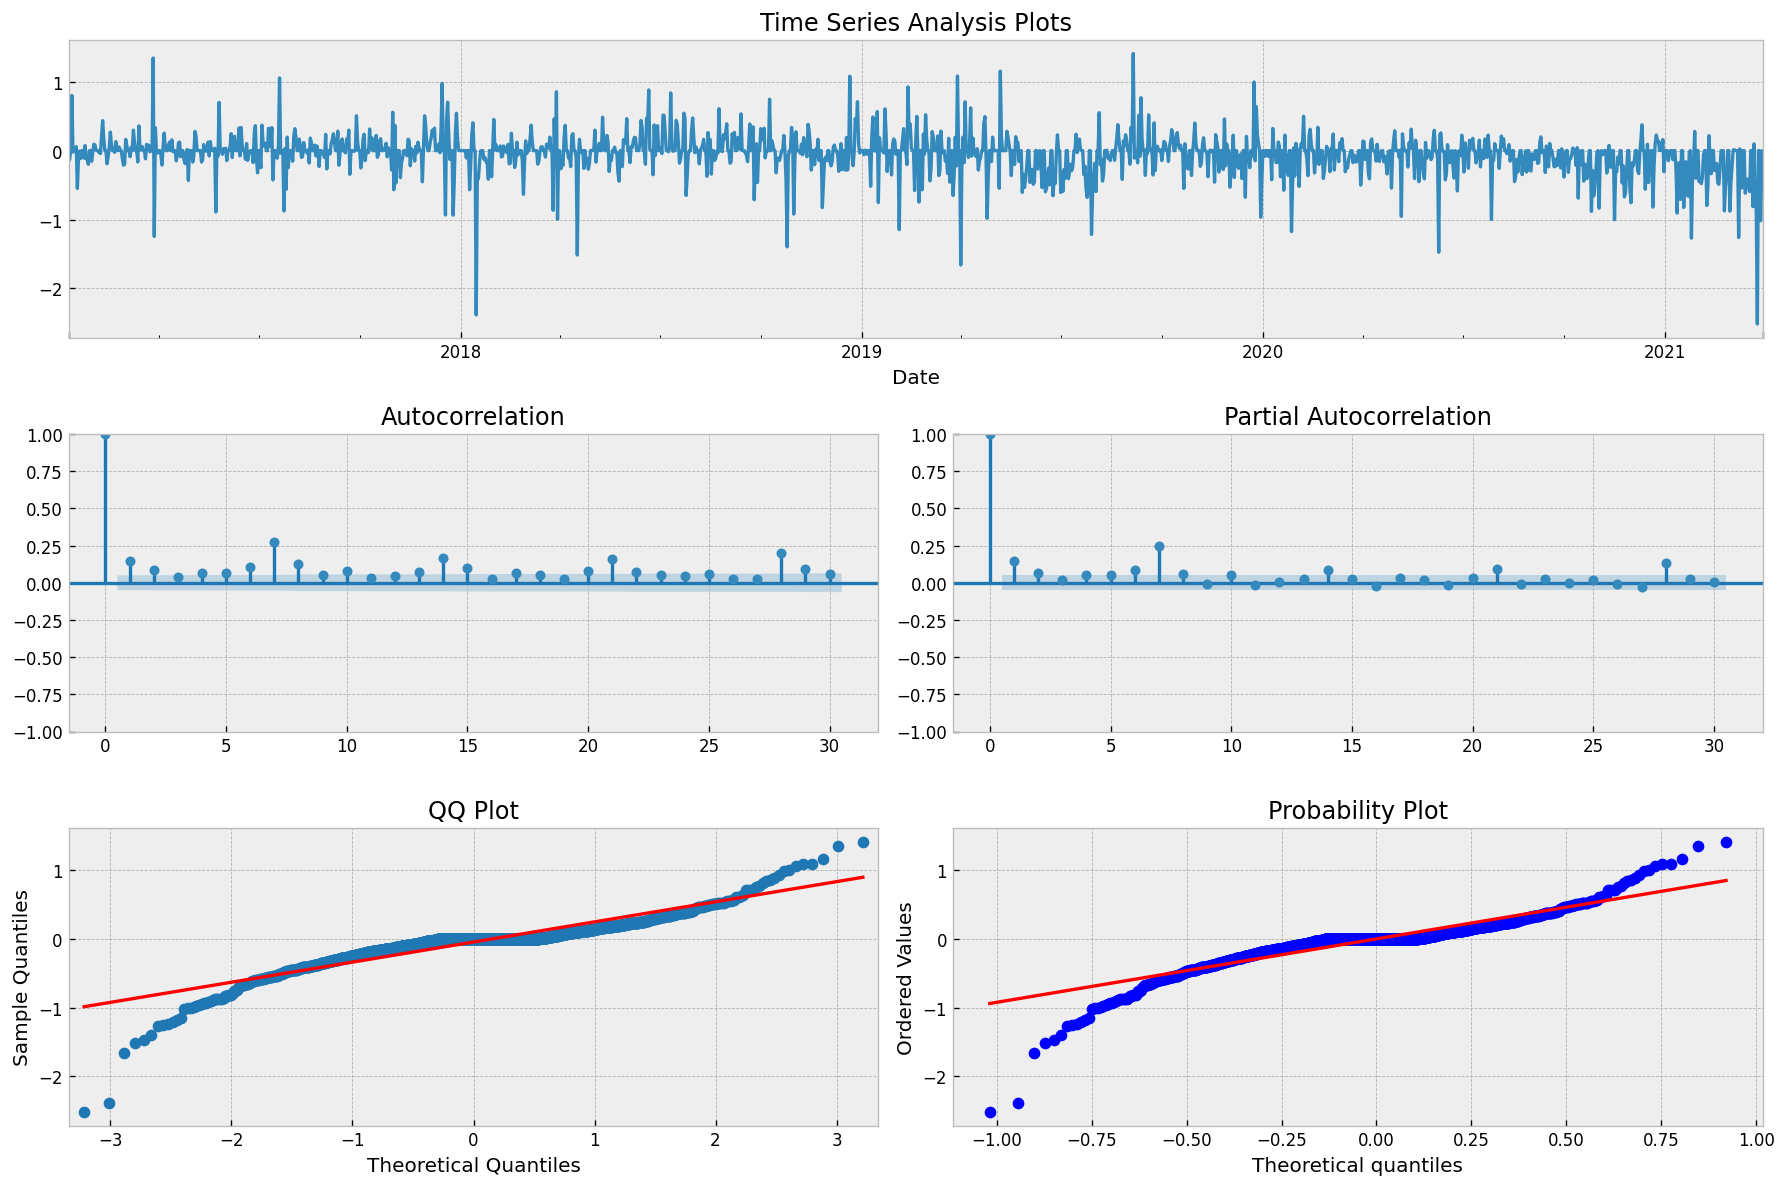

In [508]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

tsplot(data_origin['Balance'], lags=30)

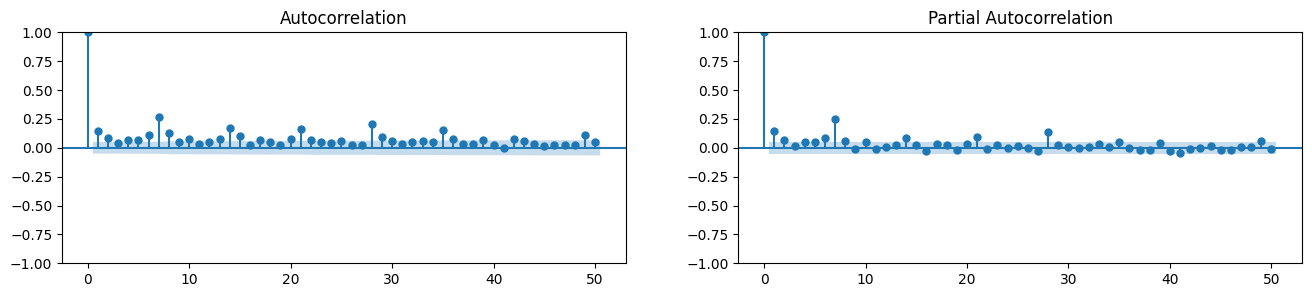

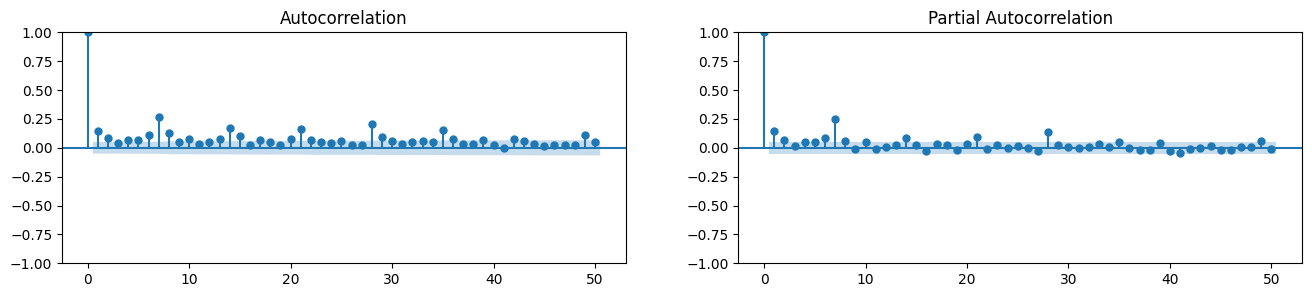

In [509]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data_origin['Balance'], lags=50, ax=axes[0])
plot_pacf(data_origin['Balance'], lags=50, ax=axes[1])

#### Авторегрессия


Можно перейти к следующей идее: делать регрессию для ряда не на какие-то внешние признаки, зависящие
от времени, а на его собственные значения в прошлом:

$$y_t = α + φ_1 y_{t−1} + φ_2 y_{t−2} + · · · + φ_p y_{t−p} + ε_t.$$

В этом регрессионном уравнении $y_t$ — это отклик, $y_{t−1}, y_{t−2},\dots , y_{t−p}$ — признаки, $α, φ_1, φ_2, . . . , φ_p$ — параметры
модели, которые необходимо оценить, $ε_t$ — шумовая компонента, описывает отклонения значений ряда от
данного уравнения.


Такая модель называется моделью авторегрессии порядка p (AR(p)). В этой модели $y_t$ представляет собой
линейную комбинацию p предыдущих значений ряда и шумовой компоненты.



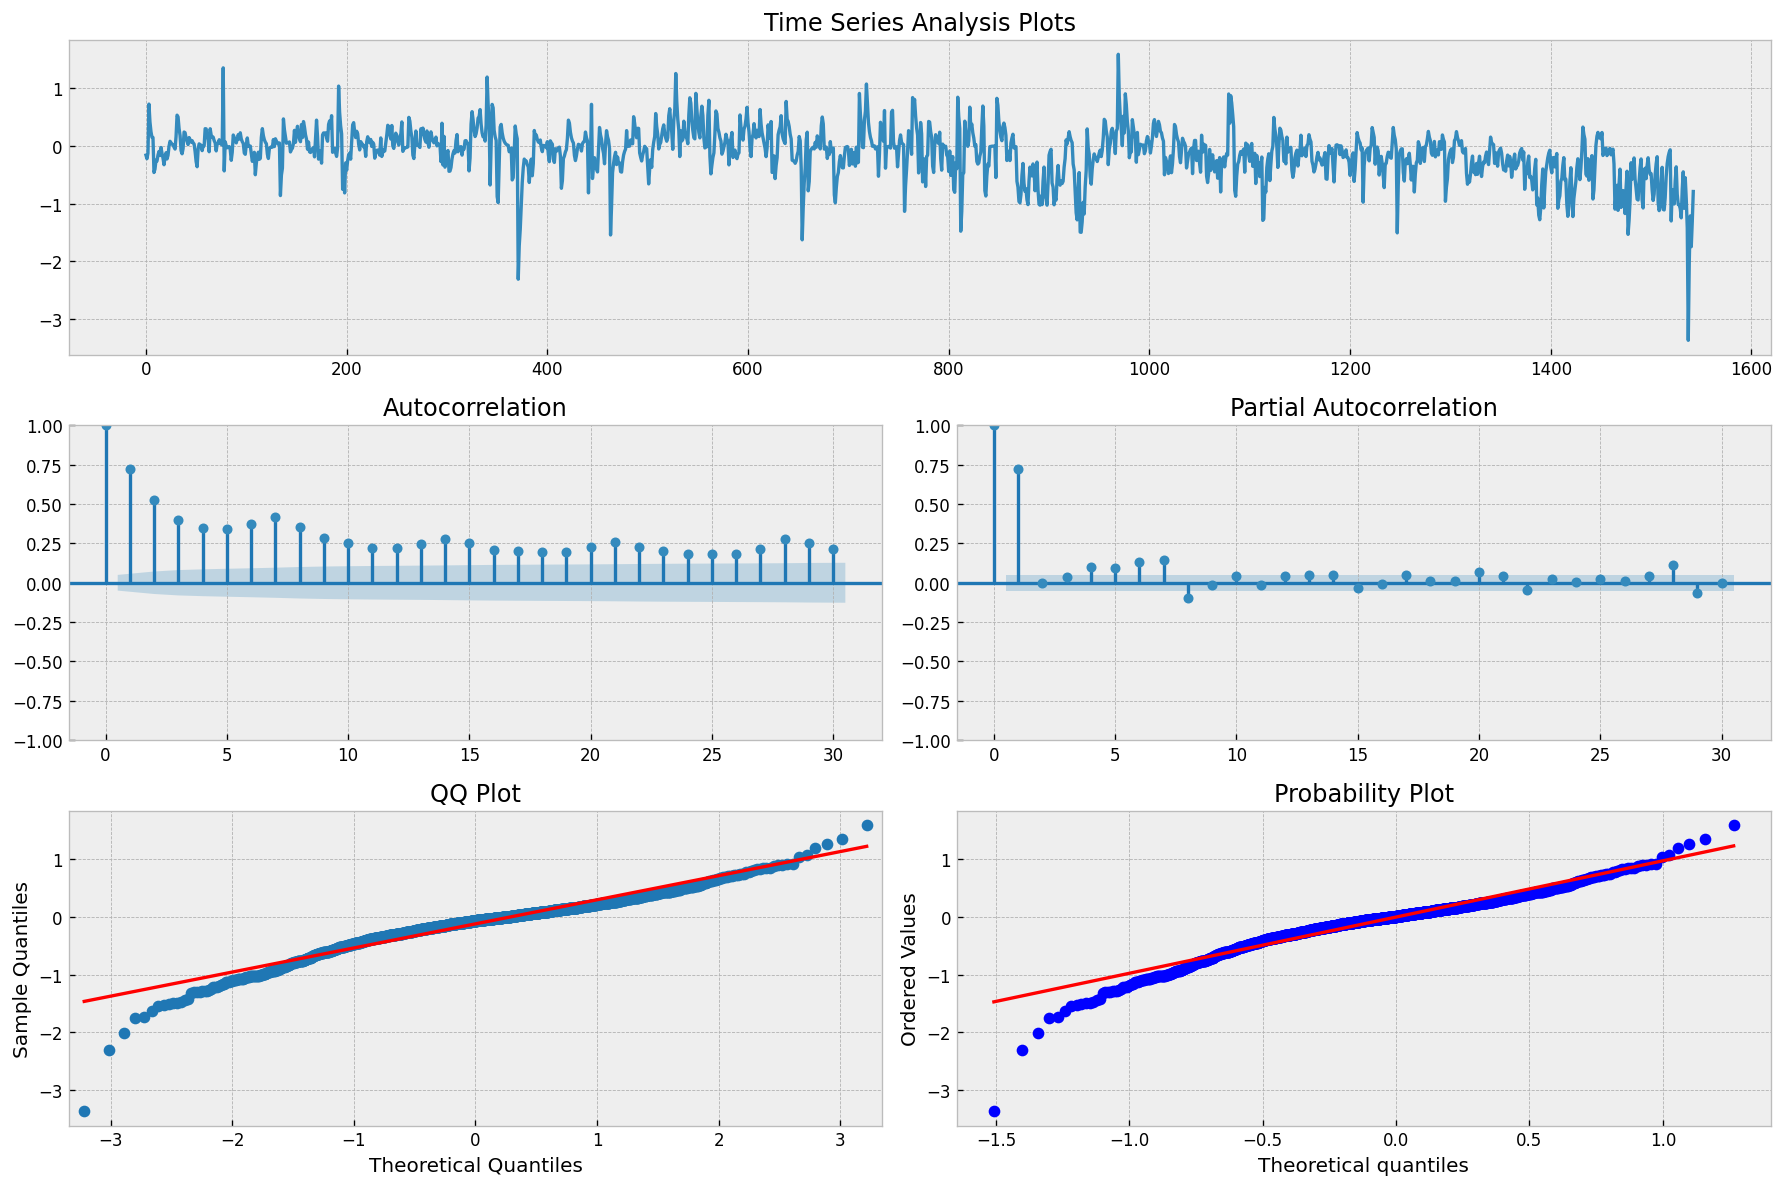

In [510]:
n_samples = len(data_origin['Balance'])
a = 0.6
x = w = data_origin['Balance'].to_numpy() 
lags = 30
for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
tsplot(x, lags=lags)

#### Проверка стационарности:

- Пристальное вглядывание в график временного ряда
- Разбиение на части и подсчет статистик
- Тесты на единичные корни
- Dickey Fuller test (ADH Test)
- Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
- Philips Perron test (PP Test)

In [511]:
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

def stationarity_check(data: pd.Series) -> None:
    """
    Проверяет стационарность временного ряда с помощью тестов ADF, KPSS и Phillips-Perron.
    Выводит статистику, p-значения и заключение о стационарности после каждого теста.
    Также анализирует среднее и дисперсию двух половин ряда.

    Parameters:
    -----------
    data : pd.Series
        Входные данные (временной ряд). Должен быть типа pandas.Series.
    """
    if not isinstance(data, pd.Series):
        raise ValueError("Входные данные должны быть типа pandas.Series")
    
    df = data.sort_index().dropna()
    
    if len(df) < 2:
        raise ValueError("Недостаточно данных для анализа стационарности")
    
    midpoint = len(df) // 2
    df_first_half = df.iloc[:midpoint]
    df_second_half = df.iloc[midpoint:]

    mean_first = df_first_half.mean()
    var_first = df_first_half.var()
    mean_second = df_second_half.mean()
    var_second = df_second_half.var()

    print("\n=== Анализ среднего и дисперсии ===")
    print(f"Первая половина - Среднее: {mean_first:.4f}, Дисперсия: {var_first:.4f}")
    print(f"Вторая половина - Среднее: {mean_second:.4f}, Дисперсия: {var_second:.4f}")
    
    if abs(mean_first - mean_second) > 0.1 * abs(mean_first) or abs(var_first - var_second) > 0.1 * abs(var_first):
        print("Различия в среднем или дисперсии указывают на возможную нестационарность.")
    else:
        print("Среднее и дисперсия стабильны, что может указывать на стационарность.")

    print("\n=== Тест Дики-Фуллера (ADF) ===")
    adf_result = adfuller(df)
    print(f"Статистика теста: {adf_result[0]:.4f}")
    print(f"p-значение: {adf_result[1]:.4f}")
    print(f"Критические значения: {adf_result[4]}")
    adf_stationary = adf_result[1] < 0.05 and adf_result[0] < adf_result[4]['5%']
    print(f"Заключение: Ряд {'стационарен' if adf_stationary else 'нестационарен'} по тесту ADF.")

    print("\n=== Тест KPSS (трендовая стационарность) ===")
    kpss_result = kpss(df, regression='ct')
    print(f"Статистика теста: {kpss_result[0]:.4f}")
    print(f"p-значение: {kpss_result[1]:.4f}")
    print(f"Критические значения: {kpss_result[3]}")
    kpss_stationary = kpss_result[1] >= 0.05
    print(f"Заключение: Ряд {'стационарен' if kpss_stationary else 'нестационарен'} по тесту KPSS.")

    print("\n=== Тест Филлипса-Перрона (PP) ===")
    pp = PhillipsPerron(df)
    print(pp.summary())
    pp_stationary = pp.pvalue < 0.05
    print(f"Заключение: Ряд {'стационарен' if pp_stationary else 'нестационарен'} по тесту PP.")

    print("\n=== Итоговый вывод ===")
    if adf_stationary and pp_stationary and not kpss_stationary:
        print("Расхождение тестов: Ряд, вероятно, стационарен после удаления тренда.")
    elif adf_stationary and pp_stationary and kpss_stationary:
        print("Ряд стационарен по всем тестам.")
    elif not adf_stationary and not pp_stationary and not kpss_stationary:
        print("Ряд нестационарен по всем тестам.")
    else:
        print("Тесты дают противоречивые результаты. Рекомендуется дополнительный анализ.")

In [512]:
stationarity_check(data_origin['Balance'])


=== Анализ среднего и дисперсии ===
Первая половина - Среднее: 0.0231, Дисперсия: 0.1168
Вторая половина - Среднее: -0.2657, Дисперсия: 0.1905
Различия в среднем или дисперсии указывают на возможную нестационарность.

=== Тест Дики-Фуллера (ADF) ===
Статистика теста: -3.8033
p-значение: 0.0029
Критические значения: {'1%': np.float64(-3.434656620970318), '5%': np.float64(-2.863442104538126), '10%': np.float64(-2.5677826540508275)}
Заключение: Ряд стационарен по тесту ADF.

=== Тест KPSS (трендовая стационарность) ===
Статистика теста: 0.2615
p-значение: 0.0100
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Заключение: Ряд нестационарен по тесту KPSS.

=== Тест Филлипса-Перрона (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                -18.800
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesi

**Анализ статистик (среднее и дисперсия)**
- Среднее значение изменилось с положительного в первой половине на отрицательное во второй, что указывает на возможное изменение тренда или уровня ряда.
- Дисперсия увеличилась, что говорит о росте волатильности во второй половине.
- Эти различия свидетельствуют о нестационарности ряда, так как стационарный ряд должен иметь постоянные среднее и дисперсию во времени.

**Тест Дики-Фуллера (ADF)**
- Статистика теста меньше критических значений.
- p-значение** < 0.05.
Ряд **стационарен** согласно тесту ADF.

**Тест KPSS (трендовая стационарность)**
- Статистика теста больше критических значений.
- p-значение < 0.05.
Ряд **нестационарен** по тесту KPSS.

**Тест Филлипса-Перрона (PP)**
- Статистика теста значительно меньше критических значений.
- p-значение < 0.05.
- Ряд **стационарен** согласно тесту PP.

Расхождение тестов свидетельствует о том, что ряд стационарен после удаления тренда.

In [513]:
stationarity_check(data_origin['Income'])


=== Анализ среднего и дисперсии ===
Первая половина - Среднее: 0.9793, Дисперсия: 0.5624
Вторая половина - Среднее: 1.1904, Дисперсия: 0.8227
Различия в среднем или дисперсии указывают на возможную нестационарность.

=== Тест Дики-Фуллера (ADF) ===
Статистика теста: -5.4000
p-значение: 0.0000
Критические значения: {'1%': np.float64(-3.434656620970318), '5%': np.float64(-2.863442104538126), '10%': np.float64(-2.5677826540508275)}
Заключение: Ряд стационарен по тесту ADF.

=== Тест KPSS (трендовая стационарность) ===
Статистика теста: 0.1176
p-значение: 0.1000
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Заключение: Ряд стационарен по тесту KPSS.

=== Тест Филлипса-Перрона (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                -26.825
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: 

In [514]:
stationarity_check(data_origin['Outcome'])


=== Анализ среднего и дисперсии ===
Первая половина - Среднее: 0.9704, Дисперсия: 0.5685
Вторая половина - Среднее: 1.2968, Дисперсия: 1.0058
Различия в среднем или дисперсии указывают на возможную нестационарность.

=== Тест Дики-Фуллера (ADF) ===
Статистика теста: -4.0097
p-значение: 0.0014
Критические значения: {'1%': np.float64(-3.434656620970318), '5%': np.float64(-2.863442104538126), '10%': np.float64(-2.5677826540508275)}
Заключение: Ряд стационарен по тесту ADF.

=== Тест KPSS (трендовая стационарность) ===
Статистика теста: 0.0806
p-значение: 0.1000
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Заключение: Ряд стационарен по тесту KPSS.

=== Тест Филлипса-Перрона (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                -29.546
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: 

**Стабилизация дисперсии**

В случае, если во временном ряде монотонно по времени изменяется дисперсия, применяется специальное преобразование, стабилизирующее дисперсию.

 Очень часто в качестве такого преобразования выступает логарифмирование. 
 
Логарифмирование принадлежит к семейству преобразований Бокса-Кокса.

$$y_t' =\begin{cases}
\ln y_t, \lambda=0 \\
(y_t^\lambda - 1)/\lambda, \lambda \neq 0
\end{cases} $$


Это параметрическое семейство функций, в котором параметр λ определяет, как именно будет преобразован
ряд: 

λ = 0 — это логарифмирование, 

λ = 1 — тождественное преобразование ряда, 

а при других значениях
λ — степенное преобразование.

 Значение параметра можно подбирать так, чтобы дисперсия была как можно
более стабильной во времени.


**Как избавиться от тренда?**

- Воспользоваться линейной регрессией на шаг временного ряда ( используя также степенные компоненты)
- Вычесть среднее
- Baxter-King filter(statsmodels.tsa.filters.bkfilter) или Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) чтобы убрать среднее или циклическую компоненту

Text(0.5, 1.0, 'Сальдо балансов')

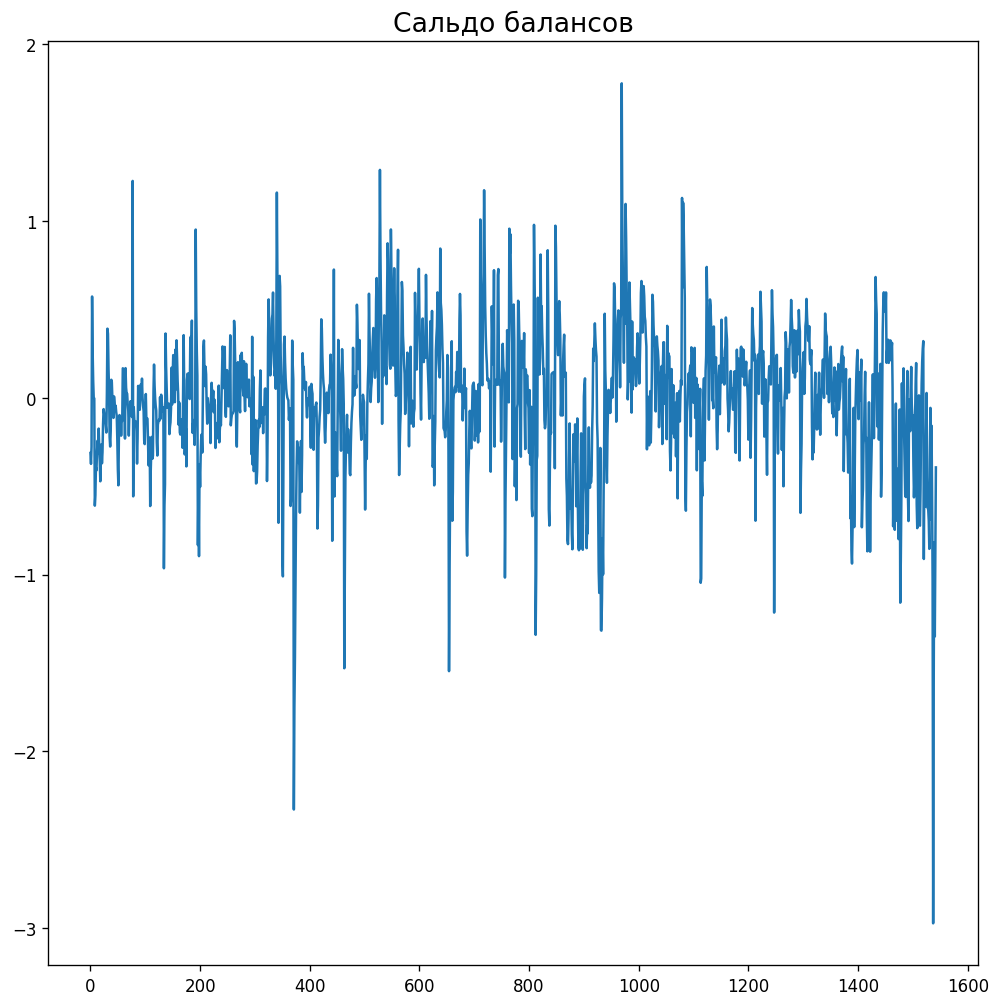

In [515]:
from scipy import signal

detrended = signal.detrend(data_origin['Balance'])
plt.plot(detrended)
plt.title('Сальдо балансов', fontsize=16)

Визуально прослеживается положительный тренд

Text(0.5, 1.0, 'Сальдо балансов')

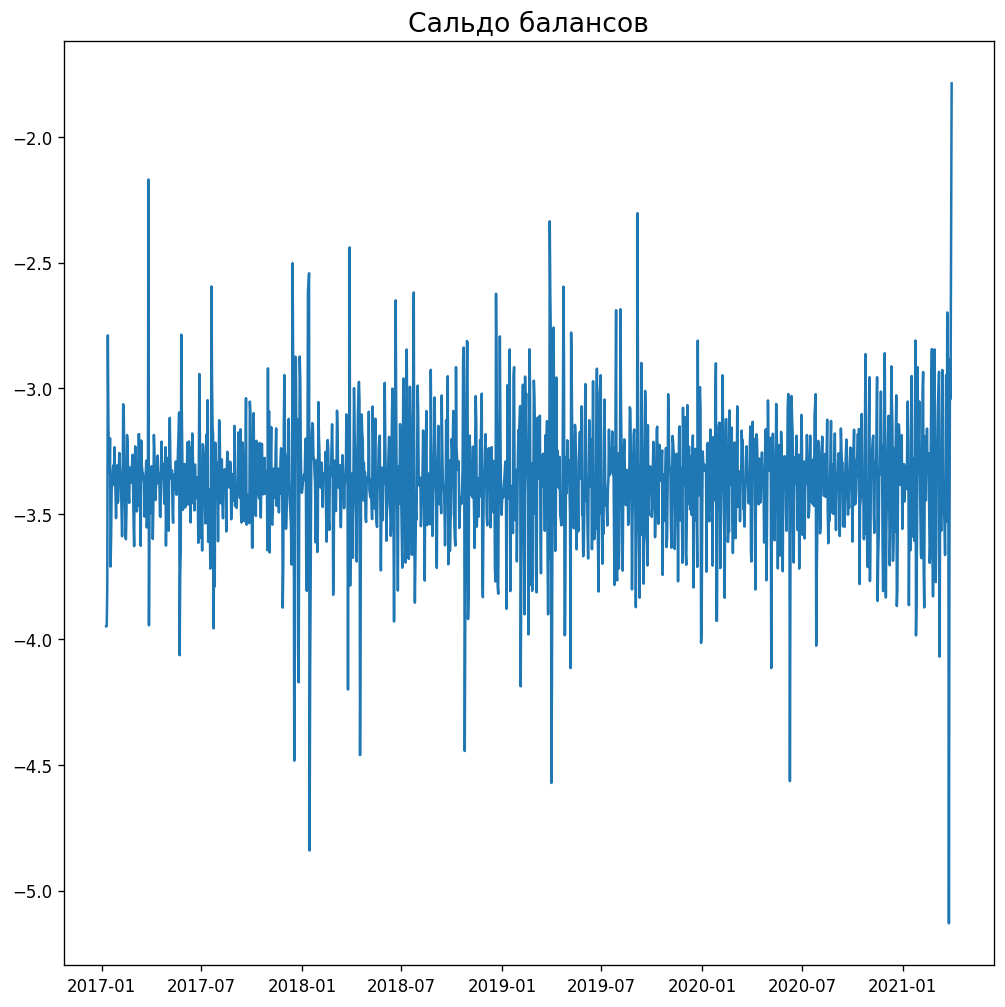

In [516]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(data_origin['Balance'] + abs(data_origin['Balance'].min())+0.000001, model='multiplicative', extrapolate_trend='freq')
detrended = data_origin['Balance'] - result_mul.trend
plt.plot(detrended)
plt.title('Сальдо балансов', fontsize=16)

In [517]:
from sklearn.linear_model import LinearRegression

def detrend_linear_regression(data: pd.Series, degree: int = 2) -> pd.Series:
    """
    Удаляет тренд из временного ряда с помощью линейной регрессии, используя шаг времени
    и его степенные компоненты
    """
    if not isinstance(data, pd.Series):
        raise ValueError("Входные данные должны быть типа pandas.Series")
    df = data.dropna().copy()
    if len(df) < 2:
        raise ValueError("Недостаточно данных для анализа")

    t = np.arange(len(df)).reshape(-1, 1)
    
    X = np.hstack([t**i for i in range(1, degree + 1)])
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        model = LinearRegression()
        model.fit(X, df.values)
    
    trend = model.predict(X)
    detrended = df - trend
    
    return pd.Series(detrended, index=df.index, name=df.name)

In [518]:
stationarity_check(detrend_linear_regression(data_origin['Balance']))


=== Анализ среднего и дисперсии ===
Первая половина - Среднее: 0.0073, Дисперсия: 0.1175
Вторая половина - Среднее: -0.0073, Дисперсия: 0.1678
Различия в среднем или дисперсии указывают на возможную нестационарность.

=== Тест Дики-Фуллера (ADF) ===
Статистика теста: -5.9050
p-значение: 0.0000
Критические значения: {'1%': np.float64(-3.434656620970318), '5%': np.float64(-2.863442104538126), '10%': np.float64(-2.5677826540508275)}
Заключение: Ряд стационарен по тесту ADF.

=== Тест KPSS (трендовая стационарность) ===
Статистика теста: 0.0878
p-значение: 0.1000
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Заключение: Ряд стационарен по тесту KPSS.

=== Тест Филлипса-Перрона (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                -19.725
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis:

In [519]:
data_linreg = data_origin.copy()
data_linreg['Balance'] = detrend_linear_regression(data_origin['Balance'])
data_linreg.head()

,Income,Outcome,Balance
Date,,,
2017-01-09,1.343028,1.487865,-0.128986
2017-01-10,1.068610,1.194182,-0.191381
2017-01-11,0.944429,0.936663,-0.095620
2017-01-12,1.672202,0.875379,0.754320
2017-01-13,0.955924,0.975645,0.444031


In [520]:
def detrend_mean_subtraction(data: pd.Series, window: int = None) -> pd.Series:
    """
    Удаляет тренд из временного ряда путем вычитания среднего.
    Если указан window, используется скользящее среднее, иначе — общее среднее.
    """
    if not isinstance(data, pd.Series):
        raise ValueError("Входные данные должны быть типа pandas.Series")
    df = data.dropna().copy()
    if len(df) < 2:
        raise ValueError("Недостаточно данных для анализа")

    if window is None:
        trend = df.mean()
        detrended = df - trend
    else:
        if window < 1 or window > len(df):
            raise ValueError("Недопустимый размер окна")
        trend = df.rolling(window=window, center=True).mean()
        detrended = df - trend
    
    return pd.Series(detrended, index=df.index, name=df.name).dropna()

In [521]:
stationarity_check(detrend_mean_subtraction(data_origin['Balance'], window=7))


=== Анализ среднего и дисперсии ===
Первая половина - Среднее: 0.0005, Дисперсия: 0.0577
Вторая половина - Среднее: -0.0002, Дисперсия: 0.0642
Различия в среднем или дисперсии указывают на возможную нестационарность.

=== Тест Дики-Фуллера (ADF) ===
Статистика теста: -14.3556
p-значение: 0.0000
Критические значения: {'1%': np.float64(-3.43468229933681), '5%': np.float64(-2.8634534376843637), '10%': np.float64(-2.5677886890239634)}
Заключение: Ряд стационарен по тесту ADF.

=== Тест KPSS (трендовая стационарность) ===
Статистика теста: 0.0304
p-значение: 0.1000
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Заключение: Ряд стационарен по тесту KPSS.

=== Тест Филлипса-Перрона (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                -46.771
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis

In [522]:
data_mean_sub = data_origin.copy()
data_mean_sub['Balance'] = detrend_mean_subtraction(data_origin['Balance'], window=7)
data_mean_sub.head()

,Income,Outcome,Balance
Date,,,
2017-01-09,1.343028,1.487865,NaN
2017-01-10,1.068610,1.194182,NaN
2017-01-11,0.944429,0.936663,NaN
2017-01-12,1.672202,0.875379,0.577586
2017-01-13,0.955924,0.975645,0.223850


В этом случае мы теряем 3 первых значения таргета

**Взятие разности** <br>
Важный трюк, который позволяет сделать ряд стационарным, — это дифференцирование, переход к попарным разностям соседних значений:
$$y' = y_t − y_{t−1}$$
Для нестационарного ряда часто оказывается, что получаемый после дифференцирования ряд является
стационарным. <br>
Дифференцирование можно применять неоднократно: от ряда первых
разностей, продифференцировав его, можно прийти к ряду вторых разностей, и т. д. <br>
Также может применяться сезонное дифференцирование ряда, переход к попарным разностям значений
в соседних сезонах. Если длина периода сезона составляет s, то новый ряд задаётся разностями
$$y'_t = y_t − y_{t−s}.$$
Сезонное и обычное дифференцирование могут применяться к ряду в любом порядке. Однако если у ряда
есть ярко выраженный сезонный профиль, то рекомендуется начинать с сезонного дифференцирования, уже
после такого преобразования может оказаться, что ряд стационарен.


In [523]:
stationarity_check(data_origin['Balance'].diff().dropna())


=== Анализ среднего и дисперсии ===
Первая половина - Среднее: 0.0000, Дисперсия: 0.0897
Вторая половина - Среднее: -0.0008, Дисперсия: 0.1015
Различия в среднем или дисперсии указывают на возможную нестационарность.

=== Тест Дики-Фуллера (ADF) ===
Статистика теста: -12.5349
p-значение: 0.0000
Критические значения: {'1%': np.float64(-3.434659459080052), '5%': np.float64(-2.8634433571425317), '10%': np.float64(-2.567783321069945)}
Заключение: Ряд стационарен по тесту ADF.

=== Тест KPSS (трендовая стационарность) ===
Статистика теста: 0.0334
p-значение: 0.1000
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Заключение: Ряд стационарен по тесту KPSS.

=== Тест Филлипса-Перрона (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                -75.981
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis

In [524]:
data_diff = data_origin.copy()
data_diff['Balance'] = data_origin['Balance'].diff().dropna()
data_diff.head()

,Income,Outcome,Balance
Date,,,
2017-01-09,1.343028,1.487865,NaN
2017-01-10,1.068610,1.194182,-0.062040
2017-01-11,0.944429,0.936663,0.096115
2017-01-12,1.672202,0.875379,0.850293
2017-01-13,0.955924,0.975645,-0.309936


В этом случае мы теряем один день записи из за пропущенного значения таргета в ходе дифференцирования

**Как учесть сезонность?**
- Скользящее среднее с сезонным окном. 
- Сезонные разности
- Разбить ряд по временным индексами

[]

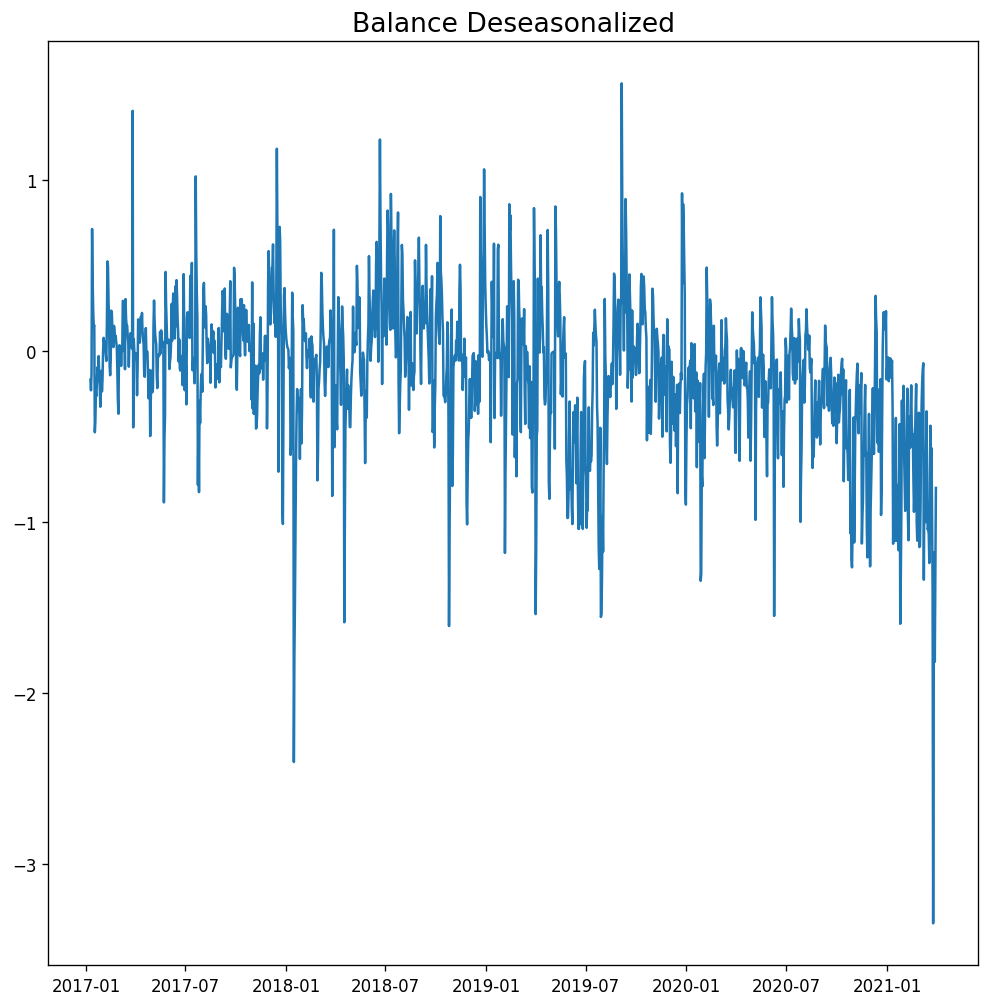

In [525]:

result_mul = seasonal_decompose(data_origin['Balance'] + abs(data_origin['Balance'].min())+0.000001, model='multiplicative', extrapolate_trend='freq')
deseasonalized = data_origin['Balance'] / result_mul.seasonal
plt.plot(deseasonalized)
plt.title('Balance Deseasonalized', fontsize=16)
plt.plot()

**Тест на сезонность**

- По дням (месяца)
- По неделям
- По месяцам
- По годам

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

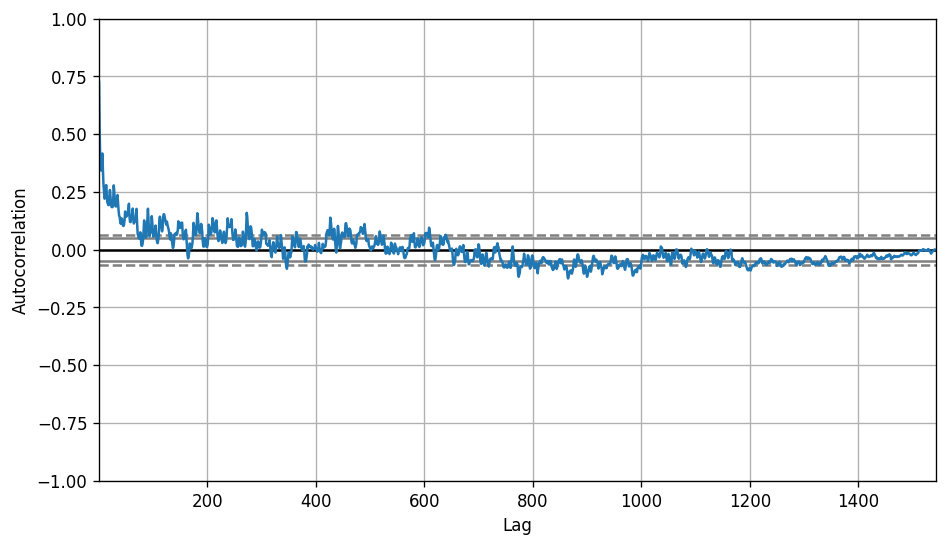

In [526]:
from pandas.plotting import autocorrelation_plot

plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(data_origin['Balance'])

Явной сезонности не наблюдается

# Итог первого блока. сделали таргет стационарным с помощью линрега. дальше работает с этими данными

In [527]:
data_linreg = data_linreg.reset_index()
data_linreg.head()

,Date,Income,Outcome,Balance
0,2017-01-09,1.343028,1.487865,-0.128986
1,2017-01-10,1.068610,1.194182,-0.191381
2,2017-01-11,0.944429,0.936663,-0.095620
3,2017-01-12,1.672202,0.875379,0.754320
4,2017-01-13,0.955924,0.975645,0.444031
...,...,...,...,...
1538,2021-03-27,0.000000,0.000000,-1.446291
1539,2021-03-28,0.000000,0.000000,-0.637110
1540,2021-03-29,2.356883,3.370738,-1.168854
1541,2021-03-30,2.317382,2.567554,-0.729481


# Добавление макроэкономических факторов

- Ключевая ставка ЦБ
- Индекс MosPrime
- Индекс moex
- Даты налоговых дней

In [528]:
from datetime import datetime

start_date = datetime.strptime('2017-01-09', '%Y-%m-%d').date()
end_date = datetime.strptime('2021-03-31', '%Y-%m-%d').date()

In [529]:
# data_origin = data_origin.reset_index()
# data_origin['Date'] = pd.to_datetime(data_origin['Date'], errors='coerce').dt.date
# data_origin = data_origin.drop(columns=['index', 'level_0'], axis=1, errors='ignore')
# data_origin = data_origin.reset_index(drop=True)
# data_origin

# data_linreg = data_linreg.reset_index()
# data_linreg['Date'] = pd.to_datetime(data_linreg['Date'], errors='coerce').dt.date
# data_linreg = data_linreg.drop(columns=['index', 'level_0'], axis=1, errors='ignore')
# data_linreg = data_linreg.reset_index(drop=True)
# data_linreg

In [530]:
mosprime = pd.read_csv('mosprime.csv', encoding='cp1251', skiprows=1, sep=';')
mosprime['Дата ставки'] = pd.to_datetime(mosprime['Дата ставки'], format='%d-%m-%Y')
mosprime = mosprime.drop(columns=['Unnamed: 8'])
mosprime = mosprime.replace(['--', '–', '-'], np.nan)
for col in ['ON', '1W', '2W', '1M', '2M', '3M', '6M']:
    mosprime[col] = mosprime[col].str.replace(',', '.').astype(float)
mosprime = mosprime.fillna(0)
mosprime.columns = ['Date', 'ON', '1W', '2W', '1M', '2M', '3M', '6M']
mosprime = mosprime.sort_index(ascending=True)
mosprime['Date'] = pd.to_datetime(mosprime['Date'], errors='coerce').dt.date
mosprime = mosprime.loc[(mosprime['Date'] >= start_date) & (mosprime['Date'] <= end_date)]
mosprime = mosprime.reset_index(drop=True)
mosprime.head()

,Date,ON,1W,2W,1M,2M,3M,6M
0,2021-03-31,4.63,4.68,4.74,4.91,5.12,5.33,5.43
1,2021-03-30,4.63,4.70,4.77,4.90,5.11,5.32,5.42
2,2021-03-29,4.65,4.69,4.76,4.90,5.10,5.28,5.38
3,2021-03-26,4.68,4.71,4.76,4.90,5.09,5.23,5.35
4,2021-03-25,4.64,4.70,4.75,4.87,5.05,5.18,5.29


In [531]:
key_rate = pd.read_csv('key_rate.csv')
key_rate = key_rate.drop(columns=['Unnamed: 0'], axis=0)
key_rate['Date'] = pd.to_datetime(key_rate['Date'], utc=True).dt.tz_localize(None)
key_rate['Date'] = pd.to_datetime(key_rate['Date'], errors='coerce').dt.date
key_rate = key_rate.sort_index(ascending=True)
key_rate = key_rate.loc[(key_rate['Date'] >= start_date) & (key_rate['Date'] <= end_date)]
key_rate = key_rate.reset_index(drop=True)
key_rate.head()

,Date,Rate
0,2021-03-31,4.5
1,2021-03-30,4.5
2,2021-03-29,4.5
3,2021-03-28,4.5
4,2021-03-25,4.5


In [532]:
MOEX = pd.read_excel('data_FIN+MOEX.xlsx')
MOEX = MOEX[['datetime', 'open_MOEX', 'high_MOEX', 'low_MOEX', 'close_MOEX']]
MOEX = MOEX.dropna()
# key_rate['Date'] = pd.to_datetime(key_rate['Date'], utc=True).dt.tz_localize(None)
MOEX['Date'] = pd.to_datetime(MOEX['datetime'], utc=True, format='%d-%m-%Y').dt.tz_localize(None)
MOEX = MOEX.drop(columns=['datetime'], axis=0)
# MOEX = MOEX.set_index('Date')
MOEX['Date'] = pd.to_datetime(MOEX['Date'], errors='coerce').dt.date
MOEX = MOEX.sort_index(ascending=True)
# MOEX.index = MOEX.index.floor('D')
MOEX = MOEX.loc[(MOEX['Date'] >= start_date) & (MOEX['Date'] <= end_date)]
MOEX = MOEX.reset_index(drop=True)
MOEX.head()

,open_MOEX,high_MOEX,low_MOEX,close_MOEX,Date
0,126.37,128.39,125.02,127.80,2017-01-09
1,127.80,130.13,126.48,129.95,2017-01-10
2,129.30,134.77,129.00,134.77,2017-01-11
3,134.61,137.60,133.15,137.60,2017-01-12
4,137.04,137.49,133.80,134.69,2017-01-13


In [533]:
tax_days = pd.read_csv('nalogi_2016-2021.txt')
tax_days.columns = ['Date', 'is_tax_day']
tax_days['Date'] = pd.to_datetime(tax_days['Date'], errors='coerce')
indexes_to_drop = tax_days[tax_days['Date'] == '29.02.2016'].index
tax_days = tax_days.drop(indexes_to_drop)
tax_days['Date'] = tax_days['Date'].apply(lambda x: x.replace(year=2017) if pd.notnull(x) and x.year == 2016 else x)
tax_days['Date'] = tax_days['Date'].dt.date
tax_days = tax_days.loc[(tax_days['Date'] >= start_date) & (tax_days['Date'] <= end_date)]
tax_days = tax_days.reset_index(drop=True)
tax_days.head()

,Date,is_tax_day
0,2017-01-09,0
1,2017-01-10,0
2,2017-01-11,0
3,2017-01-12,0
4,2017-01-13,0


In [583]:
data_origin = data_origin.reset_index()
# data_linreg['Date'] = pd.to_datetime(data_linreg['Date'], errors='coerce')
data_origin['Date'] = pd.to_datetime(data_origin['Date'], errors='coerce')
mosprime['Date'] = pd.to_datetime(mosprime['Date'], errors='coerce')
key_rate['Date'] = pd.to_datetime(key_rate['Date'], errors='coerce')
MOEX['Date'] = pd.to_datetime(MOEX['Date'], errors='coerce')
tax_days['Date'] = pd.to_datetime(tax_days['Date'], errors='coerce')

merged_data = (data_origin.merge(mosprime, on='Date', how='outer')
                        .merge(key_rate, on='Date', how='outer')
                        .merge(MOEX, on='Date', how='outer')
                        .merge(tax_days, on='Date', how='outer'))
merged_data = merged_data.fillna(0)
merged_data.to_csv('merged_data.csv', index=False)
merged_data.head()

,Date,Income,Outcome,Balance,ON,1W,2W,1M,2M,3M,6M,Rate,open_MOEX,high_MOEX,low_MOEX,close_MOEX,is_tax_day
0,2017-01-09,1.343028,1.487865,-0.158831,10.46,10.44,10.47,10.52,10.58,10.58,10.58,10.0,126.37,128.39,125.02,127.80,0
1,2017-01-10,1.068610,1.194182,-0.220870,10.21,10.40,10.48,10.53,10.59,10.59,10.59,10.0,127.80,130.13,126.48,129.95,0
2,2017-01-11,0.944429,0.936663,-0.124756,10.23,10.40,10.48,10.53,10.59,10.59,10.59,10.0,129.30,134.77,129.00,134.77,0
3,2017-01-12,1.672202,0.875379,0.725537,10.23,10.42,10.48,10.53,10.59,10.59,10.59,10.0,134.61,137.60,133.15,137.60,0
4,2017-01-13,0.955924,0.975645,0.415601,10.27,10.40,10.45,10.51,10.58,10.59,10.59,0.0,137.04,137.49,133.80,134.69,0


# Feature Engineering

In [584]:
def create_balance_features(df, target_col='Balance'):
    """
    Создает фичи из таргета Balance: лаги, скользящие средние, разности и др.
    
    Parameters:
    df (pd.DataFrame): DataFrame с данными, содержащий столбец Balance
    target_col (str): Название столбца таргета (по умолчанию 'Balance')
    
    Returns:
    pd.DataFrame: DataFrame с новыми фичами
    """
    df = df.copy()
    
    # Лаги (1, 2, 3, 7 дней назад)
    for lag in [1, 2, 3, 7]:
        df[f'lag_{lag}_{target_col}'] = df[target_col].shift(lag)
        
    # Rolling Statistics
   
    windows = [3, 7, 14]

    for window in windows:
        # Скользящие средние
        df[f'roll_mean_{window}_{target_col}'] = df[target_col].rolling(window=window, min_periods=1).mean()
        # Скользящее стандартное отклонение
        df[f'roll_std_{window}_{target_col}'] = df[target_col].rolling(window=window, min_periods=1).std()
        # Скользящий минимум
        df[f'roll_min_{window}_{target_col}'] = df[target_col].rolling(window=window, min_periods=1).min()
        # Скользящий максимум
        df[f'roll_max_{window}_{target_col}'] = df[target_col].rolling(window=window, min_periods=1).max()
        # Скользящая сумма
        df[f'roll_sum_{window}_{target_col}'] = df[target_col].rolling(window=window, min_periods=1).sum()
    
    # Разности (первого порядка)
    df[f'diff_1_{target_col}'] = df[target_col].diff(1)
    df[f'diff_2_{target_col}'] = df[target_col].diff(2)
    
    # Кумулятивная сумма и среднее
    df[f'cumsum_{target_col}'] = df[target_col].cumsum()
    df[f'cummean_{target_col}'] = df[target_col].expanding().mean()
    
    # Отношение текущего значения к скользящему среднему
    for window in [3, 7]:
        df[f'ratio_ma_{window}_{target_col}'] = df[target_col] / df[f'roll_mean_{window}_{target_col}']
    
    # Отношение к предыдущему значению
    df[f'ratio_lag_1_{target_col}'] = df[target_col] / df[f'lag_1_{target_col}']
    
    df[df == np.inf] = 1e10
    df[df == -np.inf] = -1e10
    df = df.fillna(0)
    # df = df.dropna()
    
    return df

# feature_engineering_data = create_balance_features(merged_data, 'Balance')
feature_engineering_data = create_balance_features(merged_data, 'Income')
feature_engineering_data = create_balance_features(feature_engineering_data, 'Outcome')
feature_engineering_data.head()

,Date,Income,Outcome,Balance,ON,1W,2W,1M,2M,3M,...,roll_min_14_Outcome,roll_max_14_Outcome,roll_sum_14_Outcome,diff_1_Outcome,diff_2_Outcome,cumsum_Outcome,cummean_Outcome,ratio_ma_3_Outcome,ratio_ma_7_Outcome,ratio_lag_1_Outcome
0,2017-01-09,1.343028,1.487865,-0.158831,10.46,10.44,10.47,10.52,10.58,10.58,...,1.487865,1.487865,1.487865,0.000000,0.000000,1.487865,1.487865,1.000000,1.000000,0.000000
1,2017-01-10,1.068610,1.194182,-0.220870,10.21,10.40,10.48,10.53,10.59,10.59,...,1.194182,1.487865,2.682047,-0.293682,0.000000,2.682047,1.341024,0.890501,0.890501,0.802615
2,2017-01-11,0.944429,0.936663,-0.124756,10.23,10.40,10.48,10.53,10.59,10.59,...,0.936663,1.487865,3.618710,-0.257520,-0.551202,3.618710,1.206237,0.776516,0.776516,0.784355
3,2017-01-12,1.672202,0.875379,0.725537,10.23,10.42,10.48,10.53,10.59,10.59,...,0.875379,1.487865,4.494089,-0.061284,-0.318803,4.494089,1.123522,0.873567,0.779138,0.934572
4,2017-01-13,0.955924,0.975645,0.415601,10.27,10.40,10.45,10.51,10.58,10.59,...,0.875379,1.487865,5.469734,0.100266,0.038983,5.469734,1.093947,1.049951,0.891858,1.114540


# Модуль детекции аномалий

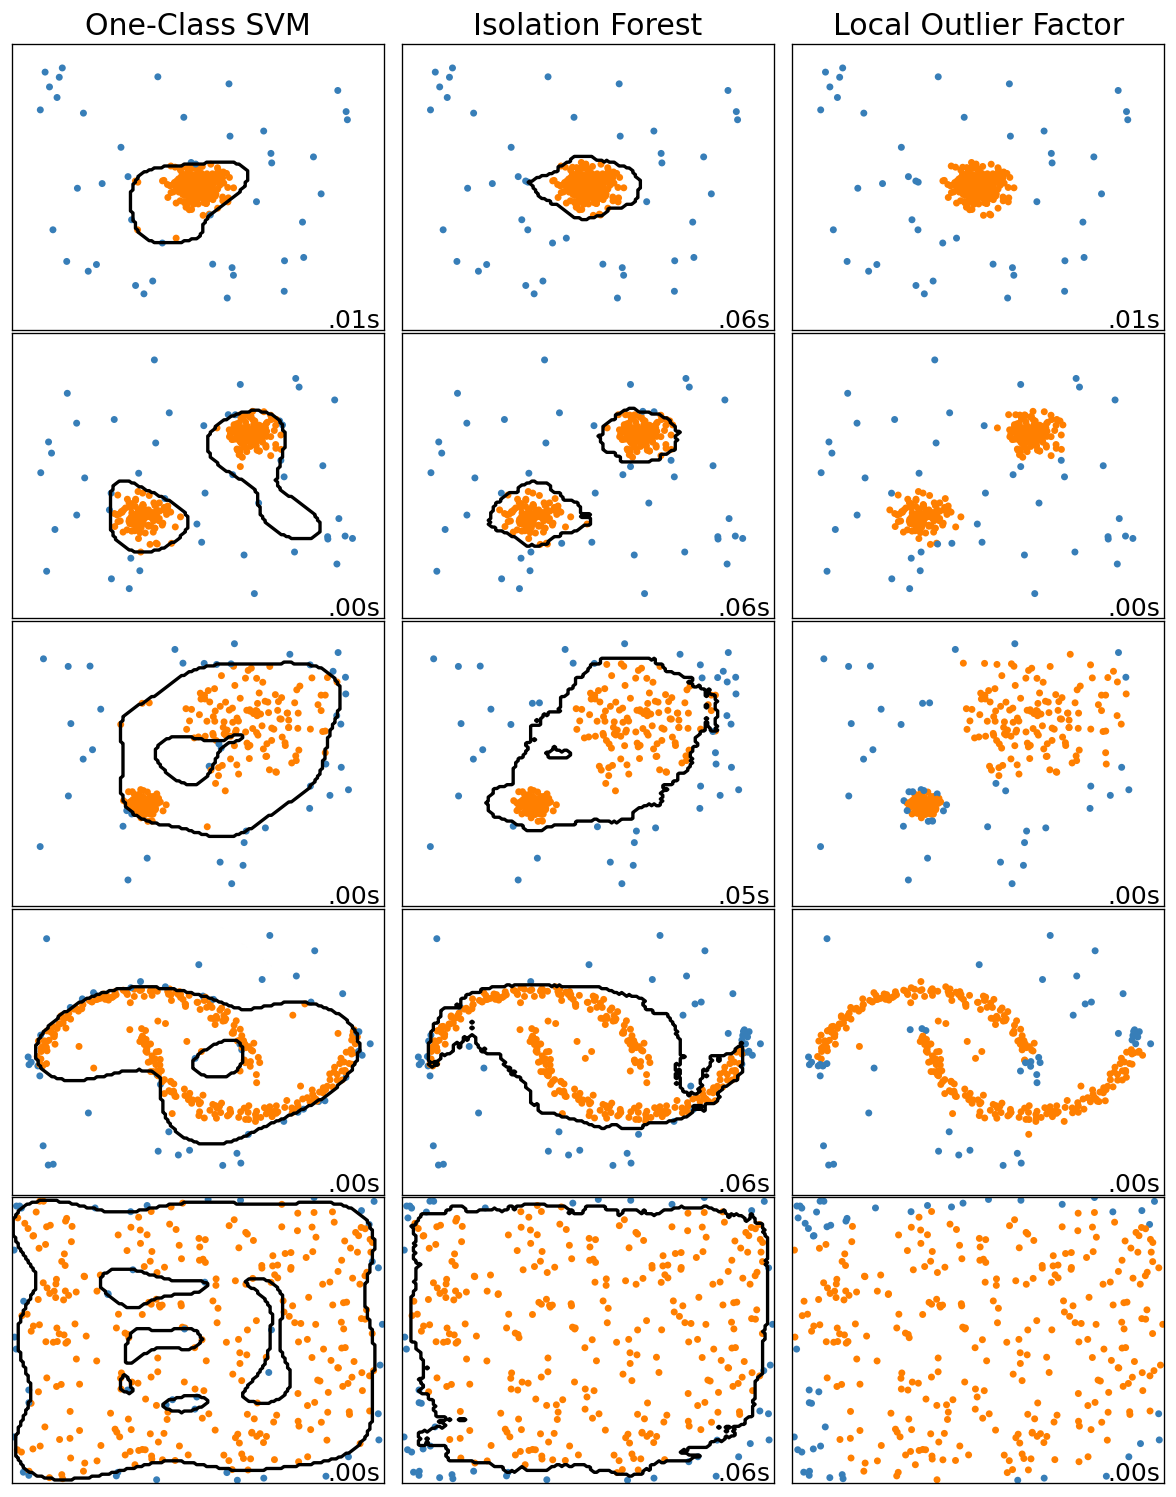

In [541]:
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.pipeline import make_pipeline

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared.


anomaly_algorithms = [
    
    ("One-Class SVM", OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),

    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    ),
]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0
    * (
        make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
    14.0 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5),
]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

In [542]:
scores_anomaly = pd.DataFrame(
    columns=['silhouette', 'davies_bouldin', 'calinski_harabasz', 'duration'],
    index=[
        'OneClassSVM',
        'IsolationForest',
        'LocalOutlierFactor', 
        'DBSCAN', 
        'EllipticEnvelope'
    ]
)

In [543]:
from sklearn import metrics
import time

def get_metrics(X, y_pred):
    silhouette = metrics.silhouette_score(X, y_pred)
    davies_bouldin = metrics.davies_bouldin_score(X, y_pred)
    calinski_harabasz = metrics.calinski_harabasz_score(X, y_pred)
    return pd.Series(
        (silhouette, davies_bouldin, calinski_harabasz),
        index=['silhouette', 'davies_bouldin', 'calinski_harabasz']
    )

In [544]:
def test_anomaly_detection(dataset, algorithm):

    algorithm = algorithm
    X = np.array(dataset)

    start = time.time()
    algorithm.fit(X)
    y_pred = algorithm.fit_predict(X)
    end = time.time()

    n_features = X.shape[1]
    plt.figure(figsize=(6, 4))

    if n_features >= 2:
        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])
    else:
        plt.hist(X[y_pred == 1], bins=30, alpha=0.5, color="#377eb8", label="Inliers")
        plt.hist(X[y_pred == -1], bins=30, alpha=0.5, color="#ff7f00", label="Outliers")
        plt.legend()
        
    plt.title(f"{algorithm}")
    plt.grid()

    duration = pd.Series([end - start])
    returned = pd.concat([get_metrics(X, y_pred), duration])
    return returned

#### Одноклассовый метод опорных векторов


Будем строить линейную функцию $a(x) = sign \langle w, x \rangle$, и потребуем,
чтобы она отделяла выборку от начала координат с максимальным отступом.
Соответствующая оптимизационная задача будет иметь следующий вид:

$$
\left\{
        \begin{aligned}
            & \frac{1}{2} \|w\|^2
            +
            \frac{1}{\nu \ell} \sum_{i = 1}^{\ell} \xi_i
            -
            \rho
            \to \min_{w, \xi, \rho} \\
            & \langle w, x_i \rangle
            \geq
            \rho - \xi_i,
            \quad i = 1, \dots, \ell, \\
            & \xi_i \geq 0, \quad i = 1, \dots, \ell.
        \end{aligned}
\right.
$$


Здесь гиперпараметр $\nu$ отвечает за корректность на обучающей выборке -
можно показать, что он является верхней границей на число аномалий (объектов выборки,
на которых $a(x) = -1$).
Решающее правило будет иметь вид

$$
\
    a(x)
    =
    sign\left(
        \langle w, x \rangle
        -
        \rho
    \right),
\
$$
где ответ -1 будет соответствовать выбросу.

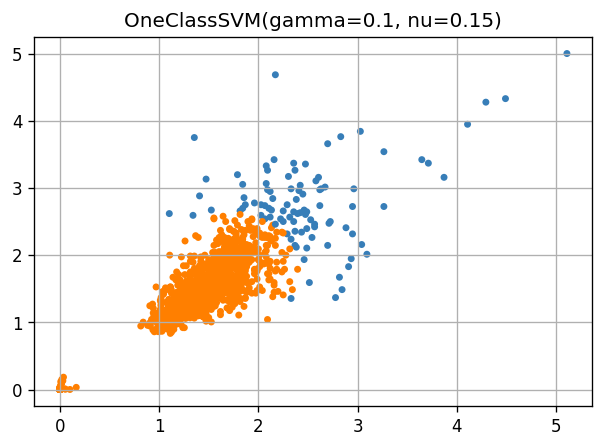

In [545]:
from sklearn.svm import OneClassSVM

scores_anomaly.iloc[0] = test_anomaly_detection(feature_engineering_data[['Income', 'Outcome']], OneClassSVM(nu=0.15, kernel="rbf", gamma=0.1))

#### Isolation forest

На этапе обучения будем строить лес, состоящий из N деревьев.
Каждое дерево будем строить стандартным жадным алгоритмом,
но при этом признак и порог будем выбирать случайно.
Строить дерево будем до тех пор, пока в вершине не окажется ровно один объект,
либо пока не будет достигнута максимальная высота.


Метод основан на предположении о том, что чем сильнее объект отличается от большинства,
тем быстрее он будет отделён от основной выборки с помощью случайных разбиений.
Соответственно, выбросами будем считать те объекты, которые оказались на небольшой глубине.

Чтобы вычислить оценку аномальности объекта $x$, найдём расстояние от соответствующего ему листа
до корня в каждом дереве.
Если лист, в котором оказался объект, содержит только его, то в качестве оценки $h_n(x)$
от данного $n$-го дерева будем брать саму глубину $k$;
если же в листе оказалось $m$ объектов, то в качестве оценки возьмём величину $h_n(x) = k + c(m)$.
Здесь $c(m)$ - средняя длина пути от корня до листа в бинарном дереве поиска, которая вычисляется по формуле
$$
\
    c(m)
    =
    2H(m - 1) - 2\frac{m - 1}{m},
\
$$
а $H(i) \approx \ln(i) + 0.5772156649$ - $i$-е гармоническое число.
Оценку аномальности вычислим на основе средней глубины, нормированной на среднюю длину пути в дереве,
построенном на выборке размера $\ell$:
$$
\
    a(x)
    =
    2^{-\frac{
            \frac{1}{N} \sum_{n = 1}^{N} h_n(x)
        }{
            c(\ell)
        }
    }.
\
$$


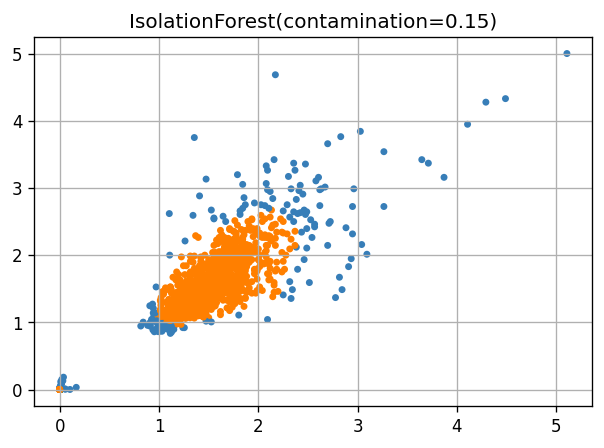

In [546]:
from sklearn.ensemble import IsolationForest

scores_anomaly.iloc[1] = test_anomaly_detection(feature_engineering_data[['Income', 'Outcome']], IsolationForest(contamination=0.15))

#### Метрический метод LOF (Local Outlier Factor)

измерение локального отклонения плотности конкретной точки данных по отношению к ее соседям. Идея состоит в том, чтобы обнаружить наблюдения, которые имеют значительно меньшую плотность, чем их соседи. Именно эти точки и будут являться аномалиями. 

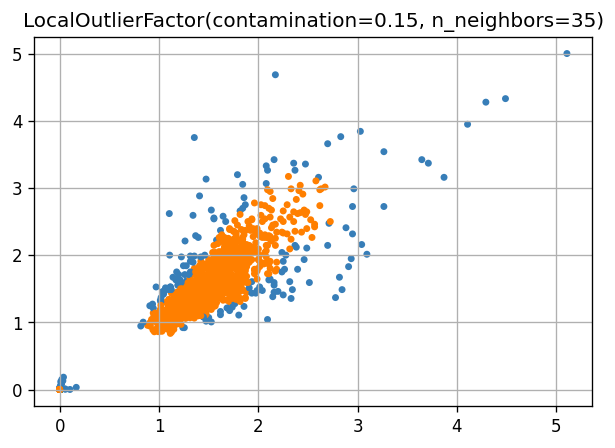

In [547]:
from sklearn.neighbors import LocalOutlierFactor

scores_anomaly.iloc[2] = test_anomaly_detection(feature_engineering_data[['Income', 'Outcome']], LocalOutlierFactor(n_neighbors=35, contamination=0.15))

#### Кластерный метод DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

группирует точки на основе их плотности, определяя кластеры как области с высокой плотностью. Точки в разреженных областях или не входящие в кластеры помечаются как аномалии.

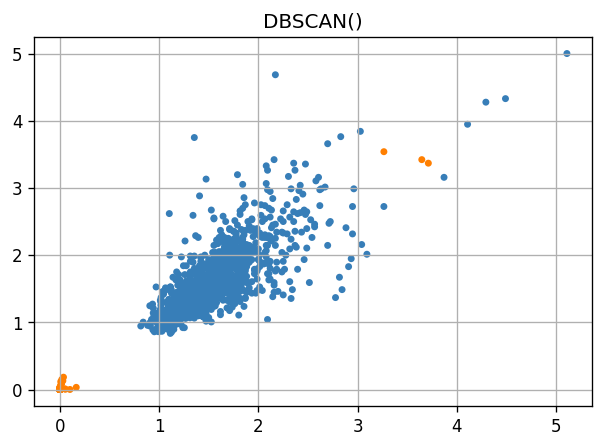

In [548]:
from sklearn.cluster import DBSCAN

scores_anomaly.iloc[3] = test_anomaly_detection(feature_engineering_data[['Income', 'Outcome']], DBSCAN(eps=0.5, min_samples=5))

#### Статистический метод Elliptic Envelope (Robust Covariance)

предполагает, что нормальные данные следуют многомерному нормальному распределению. Аномалии выявляются как точки, лежащие за пределами эллиптической области, описывающей нормальные данные.

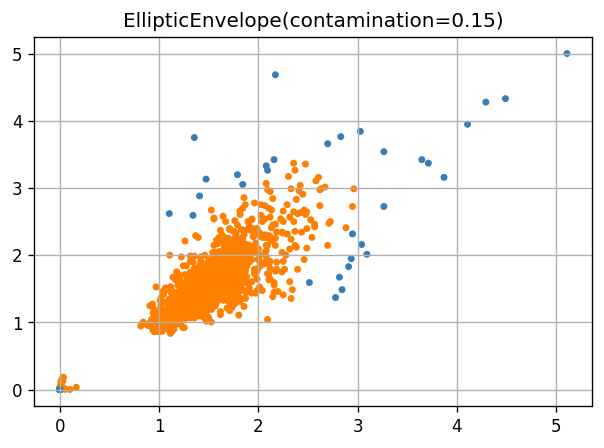

In [549]:
from sklearn.covariance import EllipticEnvelope

scores_anomaly.iloc[4] = test_anomaly_detection(feature_engineering_data[['Income', 'Outcome']], EllipticEnvelope(contamination=0.15))

In [550]:
scores_anomaly

,silhouette,davies_bouldin,calinski_harabasz,duration
OneClassSVM,0.429918,0.751081,376.543195,0.020973
IsolationForest,0.288326,4.919786,28.868099,0.146108
LocalOutlierFactor,0.230506,9.790794,6.37052,0.018309
DBSCAN,0.686179,1.180029,1320.68249,0.02917
EllipticEnvelope,0.585299,0.930569,602.996649,0.268255


- Silhouette Score (выше — лучше): насколько хорошо точки разделены на нормальные и аномальные
- Davies-Bouldin Index (ниже — лучше): компактность и разделимость кластеров
- Calinski-Harabasz Index (выше — лучше): отношение межкластерной дисперсии к внутрикластерной

DBSCAN доминирует по Silhouette и Calinski-Harabasz, но имеет средний Davies-Bouldin. На нем и остановимся, обеспечивает лучшее разделение нормальных точек и аномалий для данного датасета.


# Модуль отбора фичей

In [563]:
data = feature_engineering_data.copy()

target = 'Balance'
features = [col for col in data.columns if col not in ['Date', target]]

X = data[features]
y = data[target]

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_scaled = pd.DataFrame(X_scaled, columns=features)
X.shape

(1543, 67)

##### Встроенные методы отбора признаков
**RandomForestRegressor**

ансамбль деревьев решений, где каждое дерево обучается на случайной подвыборке данных и признаков. Для отбора фичей используется важность признаков, рассчитанная на основе того, насколько каждый признак уменьшает ошибку предсказания (например, дисперсию). Признаки с большей важностью считаются более значимыми.

исследует нелинейную зависимость

In [318]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_select(X, y, random_state=42):
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=random_state)
    rf.fit(X, y)

    feature_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
    selected_features = feature_importance[feature_importance > 0.005].index.tolist()

    return selected_features

#### Elastic Net

**Описание**  
Комбинированный метод регуляризации, сочетающий L1- (Lasso) и L2-регуляризацию (Ridge). Используется для регрессии и отбора признаков, особенно эффективен при работе с коррелированными признаками.

**Формула**  
$$
\min_{\beta} \left( \frac{1}{2n} \sum_{i=1}^n (y_i - \beta_0 - \sum_{j=1}^p \beta_j x_{ij})^2 + \alpha \left( \lambda \sum_{j=1}^p |\beta_j| + \frac{1-\lambda}{2} \sum_{j=1}^p \beta_j^2 \right) \right)
$$

**Где**  
- $y_i$ — целевая переменная для $i$-го наблюдения,  
- $x_{ij}$ — значение $j$-го признака для $i$-го наблюдения,  
- $\beta_0$ — свободный член (intercept),  
- $\beta_j$ — коэффициент при $j$-м признаке,  
- $n$ — количество наблюдений в выборке,  
- $p$ — количество признаков,  
- $\alpha$ — общий коэффициент регуляризации (контролирует силу воздействия),  
- $\lambda$ (или `l1_ratio`) — параметр смешивания (0 ≤ $\lambda$ ≤ 1):  
  - $\lambda = 1$: Pure Lasso (только L1-регуляризация),  
  - $\lambda = 0$: Pure Ridge (только L2-регуляризация).

**Компоненты формулы**  
1. $\frac{1}{2n} \sum_{i=1}^n (y_i - \beta_0 - \sum_{j=1}^p \beta_j x_{ij})^2$ — MSE-ошибка (усредненная),  
2. $\alpha \lambda \sum_{j=1}^p |\beta_j|$ — L1-компонента (Lasso),  
3. $\alpha \frac{1-\lambda}{2} \sum_{j=1}^p \beta_j^2$ — L2-компонента (Ridge).

**Алгоритм работы**  
1. Инициализация коэффициентов $\beta$,  
2. Оптимизация функции потерь методом координатного спуска,  
3. Итеративное обновление $\beta$ до сходимости.

**Преимущества**  
- L1-компонента производит отбор признаков (обнуляет незначимые $\beta_j$),  
- L2-компонента улучшает устойчивость к мультиколлинеарности,  
- Гибкая настройка баланса через параметр $\lambda$.

In [366]:
from sklearn.linear_model import ElasticNet

def elastic_net_selection(X, y, n_features_to_select=30, random_state=42):
    # balances L1 and L2
    model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=random_state, max_iter=1000)
    model.fit(X, y)
    coef = np.abs(model.coef_)
    
    top_indices = np.argsort(coef)[-min(n_features_to_select, X.shape[1]):]
    selected_features = X.columns[top_indices].tolist()
    
    return selected_features

#### Оберточные методы отбора признаков
оценивают подмножества признаков, обучая модель на каждом подмножестве и измеряя ее производительность

**RFE (Recursive Feature Elimination)**

Метод рекурсивного исключения признаков. Последовательно удалет наименее важные фичи на основе весов модели и оценивает производительность, пока не останется заданное количество признаков

In [319]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

def rfe_select(X, y, n_features_to_select=30):
    model = LinearRegression()
    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)
    rfe.fit(X, y)

    selected_features = X.columns[rfe.support_].tolist()

    return selected_features

#### Пошаговый отбор (Forward Selection)

Начинает с пустого набора признаков, добавляя по одному признаку, минимизируя ошибку

In [320]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def forward_selection(X, y, n_features_to_select=30):
    features = X.columns.tolist()
    X = X.values
    
    selected_features = []
    remaining_features = features.copy()
    model = LinearRegression()
    
    while len(selected_features) < n_features_to_select and remaining_features:
        best_score = float('inf')
        best_feature = None
        
        for feature in remaining_features:
            # добавляем текущий признак
            current_features = selected_features + [feature]
            feature_indices = [features.index(f) for f in current_features]
            X_subset = X[:, feature_indices]
            
            model.fit(X_subset, y)
            y_pred = model.predict(X_subset)
            score = metrics.mean_squared_error(y, y_pred)
            
            if score < best_score:
                best_score = score
                best_feature = feature
        
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
    
    return selected_features

#### Фильтрационные методы отбора признаков

**Mutual Information Regression**

измеряет взаимную информацию между признаком и целевой переменной, оценивая, насколько признак уменьшает неопределенность о целевой переменной. Используется для отбора фичей: признаки с высокой взаимной информацией считаются более информативными и предпочтительными для модели.

In [321]:
from sklearn.feature_selection import mutual_info_regression

def mutual_info(X, y, random_state=42):
    mi_scores = mutual_info_regression(X, y, random_state=random_state)
    mi_scores_list = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
    selected_features = mi_scores_list[mi_scores_list > 0.1].index.tolist()

    return selected_features

#### Дисперсия признаков (Variance Threshold)

Удаляет признаки с дисперсией ниже заданного порога. Идея - низкая дисперсия указывает на низкую информативность

In [322]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold(X, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X)
    selected_features = X.columns[selector.get_support()].tolist()
    
    return selected_features

#### Корреляция (Correlation-based Feature Selection)

Выбирает признаки с высокой корреляцией с целевой переменно по модулю коэффициента Пирсона и низкой корреляцией между собой

In [356]:
from scipy.stats import pearsonr

def correlation_based_selection(X, y, n_features_to_select=30):

    features = X.columns.tolist()
    X_values = X.values
    
    # корреляция с целевой переменной
    correlations = []
    for i in range(X_values.shape[1]):
        corr, _ = pearsonr(X_values[:, i], y)
        correlations.append((features[i], abs(corr)))
    
    correlations.sort(key=lambda x: x[1], reverse=True)
    selected_features = [f for f, _ in correlations[:n_features_to_select]]
    
    # удаляем сильно коррелированные
    final_features = []
    for feature in selected_features:
        if len(final_features) >= n_features_to_select:
            break
        add_feature = True
        feature_idx = features.index(feature)
        for selected in final_features:
            selected_idx = features.index(selected)
            corr, _ = pearsonr(X_values[:, feature_idx], X_values[:, selected_idx])
            if abs(corr) > 0.9:
                add_feature = False
                break
        if add_feature:
            final_features.append(feature)
    
    return final_features

# Модуль оценки стабильности признаковой выборки

Проанализируем методы, согласно статье "Quantifying the stablility of feature selection"

В ней стабильность выборки оценивается по бинарной матрице, где значениями является факт попадания признака в текущую выборку

#### Jaccard Index

**Описание** 
Отношение размера пересечения к объединению двух подмножеств признаков.  
Используется для оценки сходства между множествами отобранных признаков.

**Формула**
$$
\hat{\Phi}_{\text{Jaccard}}(\mathcal{Z}) = \frac{1}{M(M-1)} \sum_{i \neq j} \frac{|s_i \cap s_j|}{|s_i \cup s_j|}
$$

**Где**
- $s_i, s_j$ — множества признаков, отобранных в $i$-м и $j$-м запусках,  
- $M$ — общее количество запусков,  

In [ ]:
def jaccard_index(Z):
    M, d = Z.shape
    stability = 0
    for i in range(M):
        for j in range(i + 1, M):
            intersection = np.sum(Z[i] & Z[j])
            union = np.sum(Z[i] | Z[j])
            if union > 0:  # Избегаем деления на 0
                stability += intersection / union
    return stability * 2 / (M * (M - 1)) if M > 1 else 0

#### Dice-Sørensen Index

**Описание**  
Нормализованное пересечение, акцентирует внимание на совпадающих признаках.  
Альтернатива Jaccard Index, более чувствительная к общим элементам.

**Формула**  
$$
\hat{\Phi}_{\text{Dice}}(\mathcal{Z}) = \frac{1}{M(M-1)} \sum_{i \neq j} \frac{2|s_i \cap s_j|}{|s_i| + |s_j|}
$$

**Где**  
- $s_i, s_j$ — множества признаков, отобранных в $i$-м и $j$-м запусках,  
- $M$ — общее количество запусков,  
- $|s_i \cap s_j|$ — мощность пересечения множеств,  
- $|s_i|, |s_j|$ — размеры индивидуальных множеств.

In [ ]:
def dice_sorensen_index(Z):
    M, d = Z.shape
    stability = 0
    for i in range(M):
        for j in range(i + 1, M):
            intersection = np.sum(Z[i] & Z[j])
            size_i = np.sum(Z[i])
            size_j = np.sum(Z[j])
            if size_i + size_j > 0:  # Избегаем деления на 0
                stability += 2 * intersection / (size_i + size_j)
    return stability * 2 / (M * (M - 1)) if M > 1 else 0

#### Percentage Overlapping Genes (POG)

**Описание**  
Симметричная мера, учитывающая долю пересечения относительно размеров подмножеств.  
Используется для оценки согласованности между множествами отобранных признаков.

**Формула**  
$$
\hat{\Phi}_{\text{POG}}(\mathcal{Z}) = \frac{1}{M(M-1)} \sum_{i \neq j} \left( \frac{|s_i \cap s_j|}{2|s_i|} + \frac{|s_i \cap s_j|}{2|s_j|} \right)
$$

**Где**  
- $s_i, s_j$ — множества признаков, отобранных в $i$-м и $j$-м запусках,  
- $M$ — общее количество запусков,  
- $|s_i \cap s_j|$ — мощность пересечения множеств,  
- $|s_i|, |s_j|$ — размеры соответствующих множеств.  

In [ ]:
def pog(Z):
    M, d = Z.shape
    stability = 0
    for i in range(M):
        for j in range(i + 1, M):
            intersection = np.sum(Z[i] & Z[j])
            size_i = np.sum(Z[i])
            size_j = np.sum(Z[j])
            if size_i > 0 and size_j > 0:  # Избегаем деления на 0
                stability += (intersection / (2 * size_i) + intersection / (2 * size_j))
    return stability * 2 / (M * (M - 1)) if M > 1 else 0

#### Ochiai’s Index

**Описание**  
Геометрическое среднее доли общих признаков, устойчиво к различиям в размерах подмножеств.  
Используется для оценки сходства между множествами отобранных признаков.

**Формула**  
$$
\hat{\Phi}_{\text{Ochiai}}(\mathcal{Z}) = \frac{1}{M(M-1)} \sum_{i \neq j} \frac{|s_i \cap s_j|}{\sqrt{|s_i||s_j|}}
$$

**Где**  
- $s_i, s_j$ — множества признаков, отобранных в $i$-м и $j$-м запусках,  
- $M$ — общее количество запусков,  
- $|s_i \cap s_j|$ — мощность пересечения множеств,  
- $|s_i|, |s_j|$ — размеры соответствующих множеств.  

In [ ]:
def ochiai_index(Z):
    M, d = Z.shape
    stability = 0
    for i in range(M):
        for j in range(i + 1, M):
            intersection = np.sum(Z[i] & Z[j])
            size_i = np.sum(Z[i])
            size_j = np.sum(Z[j])
            if size_i > 0 and size_j > 0:  # Избегаем деления на 0
                stability += intersection / np.sqrt(size_i * size_j)
    return stability * 2 / (M * (M - 1)) if M > 1 else 0

#### Normalized Hamming Similarity

**Описание**  
Основана на симметричной разнице, учитывает ложноположительные и ложноотрицательные выборы.  
Используется для оценки различий между множествами отобранных признаков.

**Формула**  
$$
\hat{\Phi}_{\text{Hamming}}(\mathcal{Z}) = 1 - \frac{1}{M(M-1)} \sum_{i \neq j} \frac{|s_i \triangle s_j|}{d}
$$

**Где**  
- $s_i, s_j$ — множества признаков, отобранных в $i$-м и $j$-м запусках,  
- $M$ — общее количество запусков,  
- $|s_i \triangle s_j|$ — мощность симметрической разницы множеств,  
- $d$ — общее количество признаков

In [ ]:
def normalized_hamming(Z):
    M, d = Z.shape
    stability = 0
    for i in range(M):
        for j in range(i + 1, M):
            symmetric_diff = np.sum(Z[i] ^ Z[j])  # XOR для симметричной разницы
            stability += symmetric_diff / d
    return 1 - (stability * 2 / (M * (M - 1))) if M > 1 else 0

#### Kuncheva’s Index

**Описание**  
Корректирует пересечение с учетом случайного совпадения, предполагая гипергеометрическое распределение.  
Используется для оценки устойчивости отбора признаков с поправкой на случайность.

**Формула**  
$$
\hat{\Phi}_{\text{Kuncheva}}(\mathcal{Z}) = \frac{1}{M(M-1)} \sum_{i \neq j} \frac{|s_i \cap s_j| - \frac{|s_i||s_j|}{d}}{|s_i| - \frac{|s_i||s_j|}{d}}
$$

**Где**  
- $s_i, s_j$ — множества признаков, отобранных в $i$-м и $j$-м запусках,  
- $|s_i \cap s_j|$ — мощность пересечения множеств $s_i$ и $s_j$,  
- $|s_i|, |s_j|$ — мощности множеств $s_i$ и $s_j$ соответственно,  
- $d$ — общее количество признаков в исходном наборе данных,  
- $M$ — общее количество запусков отбора признаков.  

In [ ]:
def kuncheva_index(Z):
    M, d = Z.shape
    stability = 0
    for i in range(M):
        for j in range(i + 1, M):
            intersection = np.sum(Z[i] & Z[j])
            size_i = np.sum(Z[i])
            size_j = np.sum(Z[j])
            expected = size_i * size_j / d
            denominator = size_i - expected
            if denominator > 0:  # Избегаем деления на 0
                stability += (intersection - expected) / denominator
    return stability * 2 / (M * (M - 1)) if M > 1 else 0

#### Wald’s Measure

**Описание**  
Похожа на Kuncheva’s, но с другой нормализацией.  
Используется для оценки устойчивости выбора признаков.

**Формула**  
$$
\hat{\Phi}_{\text{Wald}}(\mathcal{Z}) = \frac{1}{M(M-1)} \sum_{i \neq j} \frac{|s_i \cap s_j| - \frac{|s_i||s_j|}{d}}{1 - \frac{|s_i||s_j|}{d}}
$$

**Где**  
- $s_i, s_j$ — множества признаков, отобранных в $i$-м и $j$-м запусках,  
- $|s_i \cap s_j|$ — мощность пересечения множеств $s_i$ и $s_j$,  
- $|s_i|, |s_j|$ — размеры (количество элементов) множеств $s_i$ и $s_j$,  
- $d$ — общее количество признаков в исходном наборе данных,  
- $M$ — общее количество запусков отбора признаков.  

In [ ]:
def wald_measure(Z):
    M, d = Z.shape
    stability = 0
    for i in range(M):
        for j in range(i + 1, M):
            intersection = np.sum(Z[i] & Z[j])
            size_i = np.sum(Z[i])
            size_j = np.sum(Z[j])
            expected = size_i * size_j / d
            denominator = 1 - expected
            if denominator != 0:  # Избегаем деления на 0
                stability += (intersection - expected) / denominator
    return stability * 2 / (M * (M - 1)) if M > 1 else 0

#### Goh’s Measure

**Описание**  
Средняя частота выбора признаков.  
Используется для оценки стабильности отбора признаков.

**Формула**  
$$
\hat{\Phi}_{\text{Goh}}(\mathcal{Z}) = \frac{\bar{k}}{d}
$$

**Где**  
- $\bar{k}$ — среднее количество выбранных признаков,  
- $d$ — общее количество признаков в исходном наборе данных

In [ ]:
def goh_measure(Z):
    M, d = Z.shape
    k_bar = np.sum(Z) / M  # Среднее число выбранных признаков
    return k_bar / d

#### Krízek’s Measure

**Описание**  
Энтропия распределения подмножеств признаков, низкая энтропия = высокая стабильность.  
Используется для оценки устойчивости выбора признаков.

**Формула**  
$$
\hat{\Phi}_{\text{Krizek}}(\mathcal{Z}) = -\sum_{s_i \in \mathcal{Z}} \hat{p}(s_i) \log_2 \hat{p}(s_i)
$$

**Где**  
- $s_i$ — подмножество признаков, отобранных в $i$-м запуске,
- $\hat{p}(s_i)$ — эмпирическая вероятность появления подмножества $s_i$

In [ ]:
def krizek_measure(Z):
    M, d = Z.shape
    # Преобразуем строки Z в строки для подсчета уникальных подмножеств
    sets = [tuple(row) for row in Z]
    unique_sets, counts = np.unique(sets, axis=0, return_counts=True)
    probs = counts / M
    entropy = -np.sum(probs * np.log2(probs + 1e-10))  # Добавляем малое значение для избежания log(0)
    return entropy

#### Guzmán-Martínez’s Measure

**Описание**  
Энтропия частот выбора признаков, нормализована для коррекции случайного выбора.  
Используется для оценки устойчивости выбора признаков.

**Формула**  
$$
\hat{\Phi}_{\text{Guzman}}(\mathcal{Z}) = 1 - \frac{\frac{1}{d} \sum_{f=1}^d \hat{p}_f \log \hat{p}_f}{\frac{1}{d} \log \left(\frac{1}{d}\right)}
$$

**Где**  
- $\hat{p}_f$ — вероятность выбора $f$-го признака (частота встречаемости в подвыборках),  
- $d$ — общее количество возможных признаков в исходном наборе данных,  
- $\log$ — натуральный логарифм (основание $e$),  
- Знаменатель представляет энтропию равномерного распределения (максимальную неопределенность). 

In [ ]:
def guzman_measure(Z):
    M, d = Z.shape
    p_f = np.mean(Z, axis=0)  # Частоты выбора признаков
    entropy = np.sum(p_f * np.log(p_f + 1e-10)) / d  # Средняя энтропия, избегаем log(0)
    denominator = np.log(1 / d) / d
    return 1 - (entropy / denominator) if denominator != 0 else 0


#### Relative Weighted Consistency (CW_rel)

**Описание**  
Учитывает дисперсию частот выбора с коррекцией на размер подмножеств.  
Позволяет оценить согласованность выбора признаков с учетом их частоты и размера подмножеств.

**Формула**  
$$
\hat{\Phi}_{CW_{\text{rel}}}(\mathcal{Z}) = \frac{-\frac{1}{d} \frac{M-1}{M} \sum_{f=1}^d s_f^2 + \frac{\bar{k}}{d}\left(1-\frac{\bar{k}}{d}\right) - \frac{D}{M^2 d}\left(1-\frac{D}{d}\right)}{\frac{\bar{k}}{d}\left(1-\frac{\bar{k}}{d}\right) - \frac{D}{M^2 d}\left(1-\frac{D}{d}\right) + \frac{H^2}{M^2 d} - \frac{H}{Md}}
$$

**Где**  
- $d$ — общее количество признаков в данных,  
- $M$ — количество запусков алгоритма отбора признаков,  
- $\bar{k}$ — среднее количество отобранных признаков за один запуск ($\bar{k} = \frac{1}{M}\sum_{m=1}^M |s_m|$),  
- $s_f$ — частота выбора $f$-го признака ($s_f = \frac{1}{M}\sum_{m=1}^M I(f \in s_m)$),  
- $D$ — сумма квадратов размеров подмножеств ($D = \sum_{m=1}^M |s_m|^2$),  
- $H$ — сумма размеров подмножеств ($H = \sum_{m=1}^M |s_m|$),  
- $I(f \in s_m)$ — индикаторная функция (1 если признак $f$ выбран в $m$-м запуске, иначе 0).  

In [ ]:
def cw_rel(Z):
    M, d = Z.shape
    p_f = np.mean(Z, axis=0)  # Частоты выбора
    s_f2 = p_f * (1 - p_f)  # Дисперсия для каждого признака
    k_bar = np.sum(Z) / M  # Среднее число выбранных признаков
    k_i = np.sum(Z, axis=1)  # Число признаков в каждой выборке
    D = np.sum(k_i**2) / M
    H = (M * k_bar) % M
    numerator = (-np.sum(s_f2) * (M-1) / (M * d)) + (k_bar / d) * (1 - k_bar / d) - (D / (M**2 * d)) * (1 - D / d)
    denominator = (k_bar / d) * (1 - k_bar / d) - (D / (M**2 * d)) * (1 - D / d) + (H**2 / (M**2 * d)) - (H / (M * d))
    return numerator / denominator if denominator != 0 else 0

#### Lausser’s Measure

**Описание**  
Среднее квадратов частот выбора, акцентирует внимание на доминирующих признаках.  
Используется для оценки устойчивости выбора признаков.

**Формула**  
$$
\hat{\Phi}_{\text{Lausser}}(\mathcal{Z}) = \frac{1}{\bar{k}} \sum_{f=1}^d \hat{p}_f^2
$$

**Где**  
- $\hat{p}_f$ — частота выбора $f$-го признака,  
- $\bar{k}$ — средний размер подмножества отобранных признаков,  
- $d$ — общее количество признаков в исходном наборе.

In [ ]:
def lausser_measure(Z):
    M, d = Z.shape
    p_f = np.mean(Z, axis=0)  # Частоты выбора
    k_bar = np.sum(Z) / M  # Среднее число выбранных признаков
    return np.sum(p_f**2) / k_bar if k_bar > 0 else 0

#### Proposed Measure

**Описание**  
Новая мера, основанная на дисперсии частот выбора признаков, с коррекцией на случайное совпадение.  

**Формула**  
$$
\hat{\Phi}(\mathcal{Z}) = 1 - \frac{\frac{1}{d} \frac{M}{M-1} \sum_{f=1}^d \hat{p}_f(1-\hat{p}_f)}{\frac{\bar{k}}{d}\left(1-\frac{\bar{k}}{d}\right)}
$$

**Где**  
- $\hat{p}_f$ — частота выбора $f$-го признака,  
- $d$ — общее количество признаков,  
- $M$ — количество запусков отбора признаков,  
- $\bar{k}$ — среднее количество отобранных признаков за запуск.  

In [ ]:
def proposed_measure(Z):
    M, d = Z.shape
    p_f = np.mean(Z, axis=0)  # Частоты выбора
    variance = np.sum(p_f * (1 - p_f)) / d  # Средняя дисперсия
    k_bar = np.sum(Z) / M  # Среднее число выбранных признаков
    denominator = (k_bar / d) * (1 - k_bar / d)
    if denominator > 0 and M > 1:
        return 1 - (variance * M / (M - 1)) / denominator
    return 0

In [288]:
def get_metrics_feature_select(Z):
    jaccard = jaccard_index(Z)
    dice_sorensen = dice_sorensen_index(Z)
    ochiai = ochiai_index(Z)
    hamming = normalized_hamming(Z)
    kuncheva = kuncheva_index(Z)
    wald = wald_measure(Z)
    goh = goh_measure(Z)
    krizek = krizek_measure(Z)
    cw = cw_rel(Z)
    lausser = lausser_measure(Z)
    proposed = proposed_measure(Z)
    pog_in = pog(Z)
    return pd.Series(
        (jaccard, dice_sorensen, ochiai, hamming, kuncheva, wald, goh, krizek, cw, lausser, proposed, pog_in),
        index=['jaccard_index', 'dice_sorensen_index', 'ochiai_index', 'normalized_hamming', 'kuncheva_index', 'wald_measure', 'goh_measure', 'krizek_measure', 'cw_rel', 'lausser_measure', 'proposed_measure', 'pog']
    )

In [375]:
scores_feature_select = pd.DataFrame(
    columns=['Jaccard Index', 'Dice-Sørensen Index', 'Ochiai’s Index', 'Normalized Hamming', 'Kuncheva’s Index', 'Wald’s Measure', 'Goh’s Measure', 'Krízek’s Measure', 'CW_rel', 'Lausser’s Measure', 'Proposed Measure', 'POG'],
    index=[
        'random_forest_select',
        'elastic_net_selection',
        'rfe_select',
        'forward_selection',
        'mutual_info', 
        'variance_threshold', 
        'correlation_based_selection'
    ]
)

In [377]:
from sklearn.utils import resample

feature_selection_matrix = pd.DataFrame(
    columns=X.columns,
    index=[f'run_{i+1}' for i in range(20)]
)

for i in range(20):
    # X_sample, y_sample = resample(X, y, replace=True, n_samples=len(X), random_state=i) # бутстрап
    selected_features = random_forest_select(X, y, random_state=i)
    row = {feature: 1 if feature in selected_features else 0 for feature in X.columns}
    feature_selection_matrix.loc[f'run_{i+1}'] = row

scores_feature_select.iloc[0] = get_metrics_feature_select(feature_selection_matrix.values)

for i in range(20):
    # X_sample, y_sample = resample(X, y, replace=True, n_samples=len(X), random_state=i) # бутстрап
    selected_features = elastic_net_selection(X, y, random_state=i)
    row = {feature: 1 if feature in selected_features else 0 for feature in X.columns}
    feature_selection_matrix.loc[f'run_{i+1}'] = row

scores_feature_select.iloc[1] = get_metrics_feature_select(feature_selection_matrix.values)

for i in range(20):
    selected_features = rfe_select(X, y)
    row = {feature: 1 if feature in selected_features else 0 for feature in X.columns}
    feature_selection_matrix.loc[f'run_{i+1}'] = row

scores_feature_select.iloc[2] = get_metrics_feature_select(feature_selection_matrix.values)

for i in range(20):
    selected_features = forward_selection(X, y)
    row = {feature: 1 if feature in selected_features else 0 for feature in X.columns}
    feature_selection_matrix.loc[f'run_{i+1}'] = row

scores_feature_select.iloc[3] = get_metrics_feature_select(feature_selection_matrix.values)

for i in range(20):
    selected_features = mutual_info(X, y, random_state=i)
    row = {feature: 1 if feature in selected_features else 0 for feature in X.columns}
    feature_selection_matrix.loc[f'run_{i+1}'] = row

scores_feature_select.iloc[4] = get_metrics_feature_select(feature_selection_matrix.values)

for i in range(20):
    selected_features = variance_threshold(X)
    row = {feature: 1 if feature in selected_features else 0 for feature in X.columns}
    feature_selection_matrix.loc[f'run_{i+1}'] = row

scores_feature_select.iloc[5] = get_metrics_feature_select(feature_selection_matrix.values)

for i in range(20):
    selected_features = correlation_based_selection(X, y)
    row = {feature: 1 if feature in selected_features else 0 for feature in X.columns}
    feature_selection_matrix.loc[f'run_{i+1}'] = row

scores_feature_select.iloc[6] = get_metrics_feature_select(feature_selection_matrix.values)

scores_feature_select

,Jaccard Index,Dice-Sørensen Index,Ochiai’s Index,Normalized Hamming,Kuncheva’s Index,Wald’s Measure,Goh’s Measure,Krízek’s Measure,CW_rel,Lausser’s Measure,Proposed Measure,POG
random_forest_select,0.882518,0.936556,0.936935,0.943441,0.89116,-1.173976,0.449254,3.984184,0.963953,0.940199,0.885704,0.937315
elastic_net_selection,1.0,1.0,1.0,1.0,1.0,-1.332533,0.447761,-0.0,1.0,1.0,1.0,1.0
rfe_select,1.0,1.0,1.0,1.0,1.0,-1.332533,0.447761,-0.0,1.0,1.0,1.0,1.0
forward_selection,1.0,1.0,1.0,1.0,1.0,-1.332533,0.447761,-0.0,1.0,1.0,1.0,1.0
mutual_info,0.989588,0.994737,0.994765,0.992852,0.981532,-0.47539,0.681343,0.934068,1.000066,0.995016,0.983538,0.994794
variance_threshold,1.0,1.0,1.0,1.0,1.0,-0.082076,0.925373,-0.0,1.0,1.0,1.0,1.0
correlation_based_selection,1.0,1.0,1.0,1.0,1.0,-3.828829,0.253731,-0.0,1.0,1.0,1.0,1.0


В большинстве методов отсутсвует случайность, бутстрапирование также неовзомжно в виду временной переменной. Предлагаю использовать комбинацию методов для фильтрации признаков. 

forward_selection - пошаговое добавление признаков, подходит для линейных моделей <br>
mutual_info - оценивает взаимную информацию между признаками и целевой переменной <br>

In [384]:
data = feature_engineering_data.copy()

target = 'Balance'
features = [col for col in data.columns if col not in ['Date', target]]

X = data[features]
y = data[target]

# forward_selection_features = forward_selection(X, y)
mutual_info_features = mutual_info(X, y)
elastic_net_features = elastic_net_selection(X, y)
# correlation_based_selection_features = correlation_based_selection(X, y)
intersection_features = set(elastic_net_features) & set(mutual_info_features)
intersection_features = list(intersection_features)
X[intersection_features]

,2M,roll_mean_14_Income,Rate,close_MOEX,6M,roll_sum_7_Income,high_MOEX,roll_std_3_Income,1M,lag_2_Income,roll_max_3_Income,open_MOEX,roll_mean_7_Income,2W,low_MOEX,3M,roll_std_7_Income,roll_max_7_Income,cumsum_Outcome
15,10.49,0.745089,10.0,131.61,10.50,4.880016,131.75,0.621988,10.46,0.000000,1.110718,130.50,0.697145,10.43,130.10,10.50,0.489062,1.110718,7.632787
16,10.49,0.754770,10.0,131.86,10.50,5.205221,132.45,0.035211,10.46,1.110718,1.110718,131.50,0.743603,10.43,131.06,10.50,0.510427,1.110718,8.826514
17,10.49,0.705205,10.0,136.42,10.52,5.233640,136.99,0.051255,10.48,1.040476,1.079964,132.30,0.747663,10.46,132.21,10.52,0.512450,1.110718,9.938873
18,10.49,0.722382,0.0,138.50,10.52,5.405849,139.80,0.109133,10.49,1.079964,1.196396,136.45,0.772264,10.46,136.08,10.52,0.531709,1.196396,11.334570
19,0.00,0.722382,0.0,0.00,0.00,5.405849,0.00,0.637180,0.00,0.978296,1.196396,0.00,0.772264,0.00,0.00,0.00,0.531709,1.196396,11.334570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537,5.09,1.493508,0.0,169.57,5.35,10.862730,169.84,0.186828,4.90,1.935541,2.304215,168.65,1.551819,4.76,168.30,5.23,1.077075,2.488553,1735.419718
1538,0.00,1.493508,0.0,0.00,0.00,10.862730,0.00,1.294006,0.00,2.304215,2.304215,0.00,1.551819,0.00,0.00,0.00,1.077075,2.488553,1735.419718
1540,5.10,1.488805,4.5,169.94,5.38,11.257738,170.23,1.360747,4.90,0.000000,2.356883,169.80,1.608248,4.76,168.61,5.28,1.111923,2.488553,1738.790456
1541,5.11,1.535830,4.5,170.55,5.42,11.086568,171.46,1.349489,4.90,0.000000,2.356883,169.24,1.583795,4.77,168.24,5.32,1.091023,2.356883,1741.358010


# Построение модели

In [585]:
from sklearn.model_selection import train_test_split

data = feature_engineering_data.copy()

y = data['Balance']
X = data.drop(['Balance'], axis=1)

x_sample = X[intersection_features]

X_train, X_test, y_train, y_test = train_test_split(x_sample, y, test_size=0.4, random_state=42)

In [586]:
from sklearn import metrics

def get_metrics(y_test, y_pred):
    mean_absolute_error = metrics.mean_absolute_error(y_test, y_pred)
    mean_squared_error = metrics.mean_squared_error(y_test, y_pred)
    r2_score = metrics.r2_score(y_test, y_pred)
    explained_variance_score = metrics.explained_variance_score(y_test, y_pred)
    return pd.Series(
        (mean_absolute_error, mean_squared_error, r2_score, explained_variance_score),
        index=['mean_absolute_error', 'mean_squared_error', 'r2_score', 'explained_variance_score']
    )

In [587]:
scores_models = pd.DataFrame(
    columns=['mean_absolute_error', 'mean_squared_error', 'r2_score', 'explained_variance_score'],
    index=[
        'ARCH',
        'GARCH',
        'ARIMA',
        'SARIMAX',
        'LinearRegression',
        'Lasso',
        'Ridge',
        'Elastic Net'
    ]
)

#### ARCH (Autoregressive Conditional Heteroskedasticity)

**Описание**  
Моделирует изменяющуюся во времени волатильность, предполагая, что дисперсия ошибок зависит от прошлых ошибок.

**Формула**  
$$
\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \dots + \alpha_p \epsilon_{t-p}^2
$$

**Где**  
- $\sigma_t^2$ — условная дисперсия в момент времени $t$
- $\epsilon_{t-1}, \dots, \epsilon_{t-p}$ — прошлые ошибки (инновации) модели
- $\alpha_0$ — константа, минимальный уровень волатильности
- $\alpha_1, \dots, \alpha_p$ — коэффициенты, определяющие влияние прошлых квадратов ошибок на текущую волатильность
- $p$ — порядок модели ARCH (количество лагов)

In [588]:
from arch import arch_model

arch = arch_model(y_train, vol='ARCH', p=1)
model = arch.fit(disp='off')
y_pred = model.forecast(horizon=len(y_test)).mean.values[-1, :]

scores_models.iloc[0] = get_metrics(y_test, y_pred)

In [589]:
print(model.params)

mu         -1.214536e-01
omega       1.653871e-01
alpha[1]    4.009834e-09
Name: params, dtype: float64


In [590]:
print(model.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                Balance   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -480.265
Distribution:                  Normal   AIC:                           966.529
Method:            Maximum Likelihood   BIC:                           981.019
                                        No. Observations:                  925
Date:                Fri, May 02 2025   Df Residuals:                      924
Time:                        15:39:37   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu            -0.1215  1.339e-02     -9.070  1.186e-19 [ -0.1

#### GARCH (Generalized ARCH)

добавлет зависимость от прошлых значений условной дисперсии 

GARCH(p,q):


$$ h_n = \sigma_n \varepsilon_n,$$

$$\sigma_n^2 = a_0+ \sum_{i=1}^q a_i h_{n-i}^2 + \sum_{j=1}^{p} b_{j} \sigma_{n-j}^2.$$

**Где**  
- $\sigma_t^2$ — условная дисперсия в момент времени $t$
- $\alpha_0$ — постоянная составляющая (базовый уровень волатильности) 
- $\alpha_i$ — коэффициенты при квадратах прошлых инноваций (ARCH компоненты)
- $\epsilon_{t-i}^2$ — квадраты прошлых ошибок модели (инноваций)
- $\beta_j$ — коэффициенты при прошлых значениях условной дисперсии (GARCH компоненты) 
- $p$ — порядок ARCH компоненты
- $q$ — порядок GARCH компоненты
    
   Основное преимущество GARCH(𝑝, 𝑞)-моделей перед ARCH(𝑝)-моделью, состоит в подборе параметров модели. На практике периодически может оказаться так, что при подгонке статистических данных моделями ARCH(𝑝) параметр 𝑝 становится слишком большим (что усложняет анализ модели), в то время как при подгонке GARCH(𝑝, 𝑞)-моделями можно ограничиваться небольшими значениями 𝑝 и 𝑞.

GARCH – это ARMA-процесс для дисперсии серии.

In [591]:
from arch import arch_model

garch = arch_model(y_train, vol='GARCH', p=1, q=1)
model = garch.fit(disp='off')
y_pred = model.forecast(horizon=len(y_test)).mean.values[-1, :]
scores_models.iloc[1] = get_metrics(y_test, y_pred)

In [592]:
print(model.params)

mu         -0.120922
omega       0.060803
alpha[1]    0.019296
beta[1]     0.613769
Name: params, dtype: float64


In [593]:
print(model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Balance   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -480.035
Distribution:                  Normal   AIC:                           968.071
Method:            Maximum Likelihood   BIC:                           987.390
                                        No. Observations:                  925
Date:                Fri, May 02 2025   Df Residuals:                      924
Time:                        15:39:39   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu            -0.1209  1.317e-02     -9.183  4.204e-20 [ -0.1

Обычно коэффициент  GARCH модели   β1  близок к 0.9 для многих ежедневных финансовых данных.

Можно показать, что чем   α1+β1 ближе к 1, тем дольше мы ощущаем эффекты "шоков" в волатильности.

Если в модели a1 + b1 > 1, GARCH прогноз будет нестационарным и волатильность со временем возрастет до бесконечности.

#### ARIMA (AutoRegressive Integrated Moving Average)

**Описание**  
ARIMA (AutoRegressive Integrated Moving Average) — модель для анализа и прогнозирования стационарных временных рядов. Состоит из трех компонентов: авторегрессия (AR), интегрирование (I), скользящее среднее (MA).

**AR (Autoregression)** 
Зависимость от предыдущих значений ряда  
**I (Integrated)** 
Дифференцирование ряда для достижения стационарности  
**MA (Moving Average)** 
Зависимость от прошлых ошибок прогноза  

**Формула**  
$$
y_t = c + \phi_1 y_{t-1} + \dots + \phi_p y_{t-p} + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q} + \epsilon_t

$$
**Где**  
- $y_t$ — значение временного ряда в момент времени $t$  
- $c$ — константа (смещение)
- $\phi_1, \dots, \phi_p$ — коэффициенты авторегрессии (AR)
- $\theta_1, \dots, \theta_q$ — коэффициенты скользящего среднего (MA)
- $\epsilon_t$ — белый шум (ошибка) в момент времени $t$
- $p$ — порядок авторегрессии
- $q$ — порядок скользящего среднего



In [594]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(y_train, order=(1, 1, 1))
model = arima.fit()
y_pred = model.forecast(steps=len(y_test))
scores_models.iloc[2] = get_metrics(y_test, y_pred)

#### SARIMAX (Seasonal ARIMA with Exogenous variables)

**Описание**  
Расширение ARIMA, учитывающее сезонность и внешние регрессоры. Модель подходит для временных рядов с сезонными паттернами и влиянием внешних факторов.

**Формула**  
$$
y_t = c + \phi(L)y_t + \theta(L)\epsilon_t + \Phi(L^s)y_t + \Theta(L^s)\epsilon_t + \beta X_t 
$$

**Где**  
- $y_t$ — значение временного ряда в момент $t$
- $c$ — константа (смещение)
- $\phi(L)$ — несезонные авторегрессионные коэффициенты (оператор лага $L$) 
- $\theta(L)$ — несезонные коэффициенты скользящего среднего
- $\Phi(L^s)$ — сезонные авторегрессионные коэффициенты
- $\Theta(L^s)$ — сезонные коэффициенты скользящего среднего
- $\epsilon_t$ — ошибка (белый шум) в момент $t$
- $s$ — сезонный период (например, 12 для месячных данных с годовой сезонностью)
- $X_t$ — вектор экзогенных переменных в момент $t$
- $\beta$ — коэффициенты экзогенных переменных

In [595]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model = sarimax.fit(disp=0)
y_pred = model.forecast(steps=len(y_test), exog=X_test)
scores_models.iloc[3] = get_metrics(y_test, y_pred)

#### Линейная регрессия

**Описание**  
Модель, связывающая зависимую переменную с линейной комбинацией независимых переменных.  

**Формула**  
$$
y = \beta_0 + \beta_1 x_1 + \dots + \beta_n x_n + \epsilon
$$

**Где**  
- $y$ — целевая (зависимая) переменная
- $x_1, \dots, x_n$ — независимые переменные (признаки) 
- $\beta_0$ — свободный член (интерсепт)
- $\beta_1, \dots, \beta_n$ — коэффициенты регрессии
- $\epsilon$ — случайная ошибка модели

In [596]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
scores_models.iloc[4] = get_metrics(y_test, y_pred)

#### Lasso (L1-регуляризация)

**Описание**  
Линейная регрессия с L1-регуляризацией, способствующей отбору признаков за счет обнуления коэффициентов незначимых переменных. 
При увеличении $\lambda$ больше коэффициентов стремятся к нулю, что эквивалентно отбору признаков.

**Формула**  
$$
\min \left( \sum (y - \hat{y})^2 + \lambda \sum |\beta_i| \right)
$$

**Где**  
- $y$ — истинные значения целевой переменной
- $\hat{y}$ — предсказанные значения модели
- $\beta_i$ — коэффициенты модели (веса признаков)
- $\lambda$ — параметр регуляризации, контролирующий силу штрафа за сложность модели
- $\sum (y - \hat{y})^2$ — сумма квадратов ошибок (MSE)
- $\sum |\beta_i|$ — L1-норма весов (способствует разреженности решения)



In [597]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
scores_models.iloc[5] = get_metrics(y_test, y_pred)

#### Ridge (L2-регуляризация)

**Описание**  
Линейная регрессия с L2-регуляризацией, уменьшающей переобучение за счет штрафа за большие значения коэффициентов

**Формула**  
$$
\min_{\beta} \left( \sum_{i=1}^n (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^p \beta_j^2 \right)
$$

**Где**  
- $y_i$ — истинное значение целевой переменной для $i$-го наблюдения
- $\hat{y}_i$ — предсказанное значение ($\hat{y}_i = \beta_0 + \sum_{j=1}^p \beta_j x_{ij}$)
- $\beta_j$ — коэффициенты модели (включая intercept $\beta_0$)
- $\lambda$ ($\alpha$) — параметр регуляризации (контролирует силу штрафа)
- $n$ — количество наблюдений 
- $p$ — количество признаков

In [598]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
scores_models.iloc[6] = get_metrics(y_test, y_pred)

#### Elastic Net (L1 + L2-регуляризация)

**Описание**   
Объединяет преимущества обоих методов для работы с коррелированными признаками и отбора переменных.

**Формула**  
$$
\min \left( \sum (y - \hat{y})^2 + \lambda_1 \sum |\beta_i| + \lambda_2 \sum \beta_i^2 \right)
$$

**Где**  
- $y$ — истинные значения целевой переменной
- $\hat{y}$ — предсказанные значения модели
- $\beta_i$ — коэффициенты модели (веса признаков)
- $\lambda_1$ — коэффициент L1-регуляризации (контролирует разреженность модели) 
- $\lambda_2$ — коэффициент L2-регуляризации (контролирует величину коэффициентов)

In [599]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=1.0, l1_ratio=0.5)
model.fit(X_train, y_train)
elastic_pred = model.predict(X_test)
scores_models.iloc[7] = get_metrics(y_test, y_pred)

In [600]:
scores_models

,mean_absolute_error,mean_squared_error,r2_score,explained_variance_score
ARCH,0.315138,0.187731,-0.0,0.0
GARCH,0.315067,0.187731,-0.000001,0.0
ARIMA,0.316711,0.187837,-0.000568,0.000009
SARIMAX,0.298697,0.170852,0.089912,0.218488
LinearRegression,0.275681,0.143482,0.235702,0.235836
Lasso,0.279993,0.151635,0.192273,0.192683
Ridge,0.2757,0.14353,0.235445,0.235507
Elastic Net,0.2757,0.14353,0.235445,0.235507


In [579]:
scores_models

,mean_absolute_error,mean_squared_error,r2_score,explained_variance_score
ARCH,0.27937,0.149128,-0.000205,0.0
GARCH,0.279369,0.149128,-0.000205,0.0
ARIMA,0.279364,0.149127,-0.000198,0.000006
SARIMAX,0.307632,0.17981,-0.205991,0.048657
LinearRegression,0.27098,0.138508,0.071025,0.071444
Lasso,0.273969,0.145778,0.022263,0.022619
Ridge,0.270703,0.138541,0.070805,0.071049
Elastic Net,0.270703,0.138541,0.070805,0.071049


# Оценка модели на адекватность
Если GARCH оценена адекватно, то остатки не должны содержать автокорреляцию или любой другой тип нелинейной зависимости.

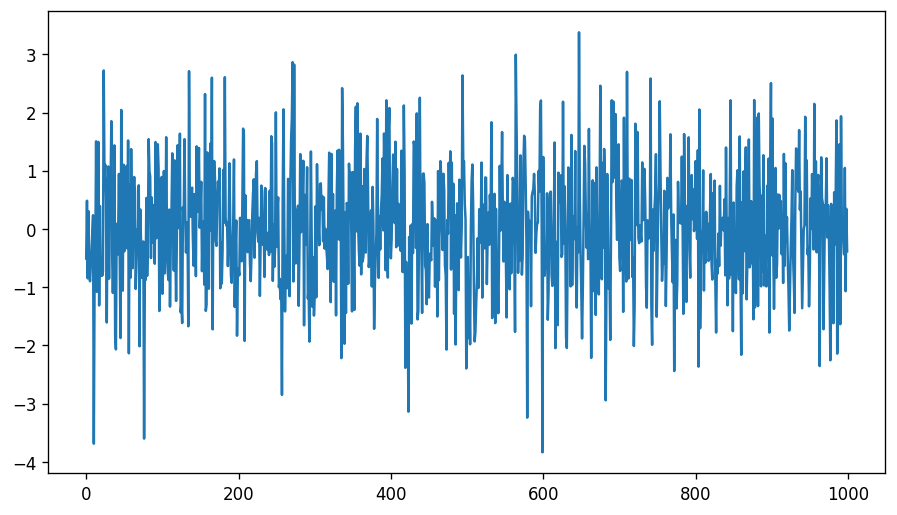

In [84]:
normal = pd.Series(np.random.normal(0, 1, size=1000))
normal.plot();

Оценим параметры на 7 года, построим прогноз на 1 год вперед.

<Axes: xlabel='Date'>

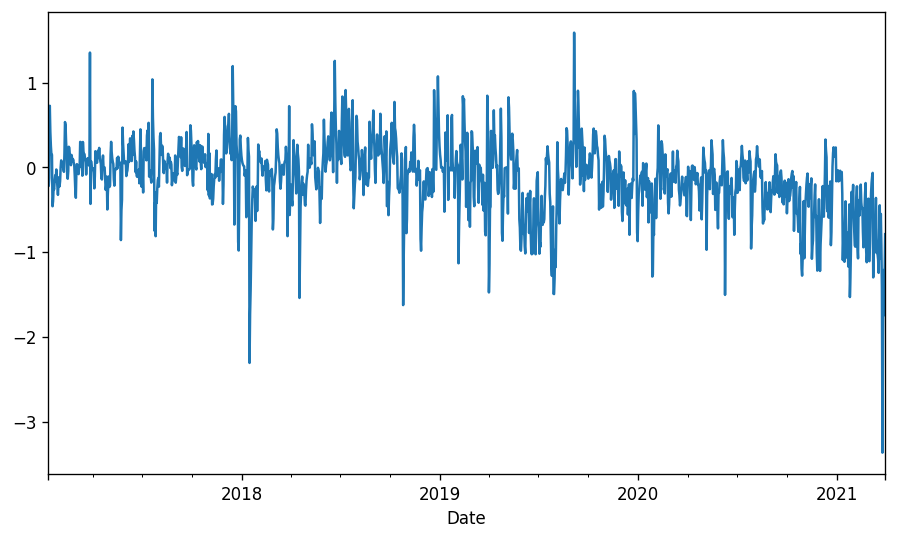

In [613]:
data = feature_engineering_data.copy()
data = data.set_index(data['Date'])
data['Balance'].plot()

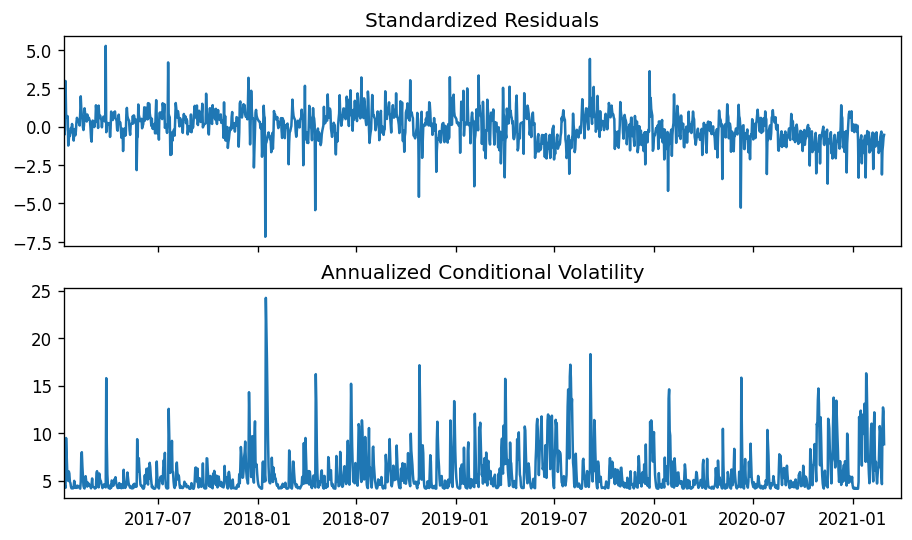

In [615]:
split_date = pd.to_datetime('2021-03-01') 
am = arch_model(data['Balance'])
model = am.fit(last_obs=split_date, disp='off')

fig = model.plot(annualize='D')

# остатки после фита модели:

После вызова forecast()  возвращается ARCHModelForecast объект с атрибутами:

mean - The forecast conditional mean.

variance - The forecast conditional variance.

residual_variance - The forecast conditional variance of residuals. 

In [616]:
# строим прогноз на 30 горизонтов от даты split_date
forecasts = model.forecast(horizon=30, start=split_date) 
forecasts.variance.tail()

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-27,2.824690,1.910733,1.310111,0.915402,0.656013,0.485550,0.373528,0.299911,0.251533,0.219740,...,0.159399,0.159192,0.159057,0.158968,0.158909,0.158871,0.158845,0.158829,0.158818,0.158811
2021-03-28,1.219766,0.856030,0.616996,0.459910,0.356678,0.288838,0.244255,0.214957,0.195704,0.183051,...,0.159036,0.158954,0.158900,0.158865,0.158842,0.158826,0.158816,0.158810,0.158805,0.158802
2021-03-29,1.567195,1.084349,0.767039,0.558513,0.421477,0.331422,0.272240,0.233348,0.207789,0.190993,...,0.159115,0.159006,0.158934,0.158887,0.158856,0.158836,0.158822,0.158814,0.158808,0.158804
2021-03-30,1.063086,0.753065,0.549330,0.415442,0.327456,0.269634,0.231635,0.206664,0.190253,0.179469,...,0.159001,0.158931,0.158885,0.158855,0.158835,0.158822,0.158813,0.158808,0.158804,0.158802
2021-03-31,0.503714,0.385465,0.307756,0.256688,0.223127,0.201073,0.186579,0.177054,0.170795,0.166682,...,0.158875,0.158848,0.158830,0.158819,0.158811,0.158806,0.158803,0.158801,0.158800,0.158799


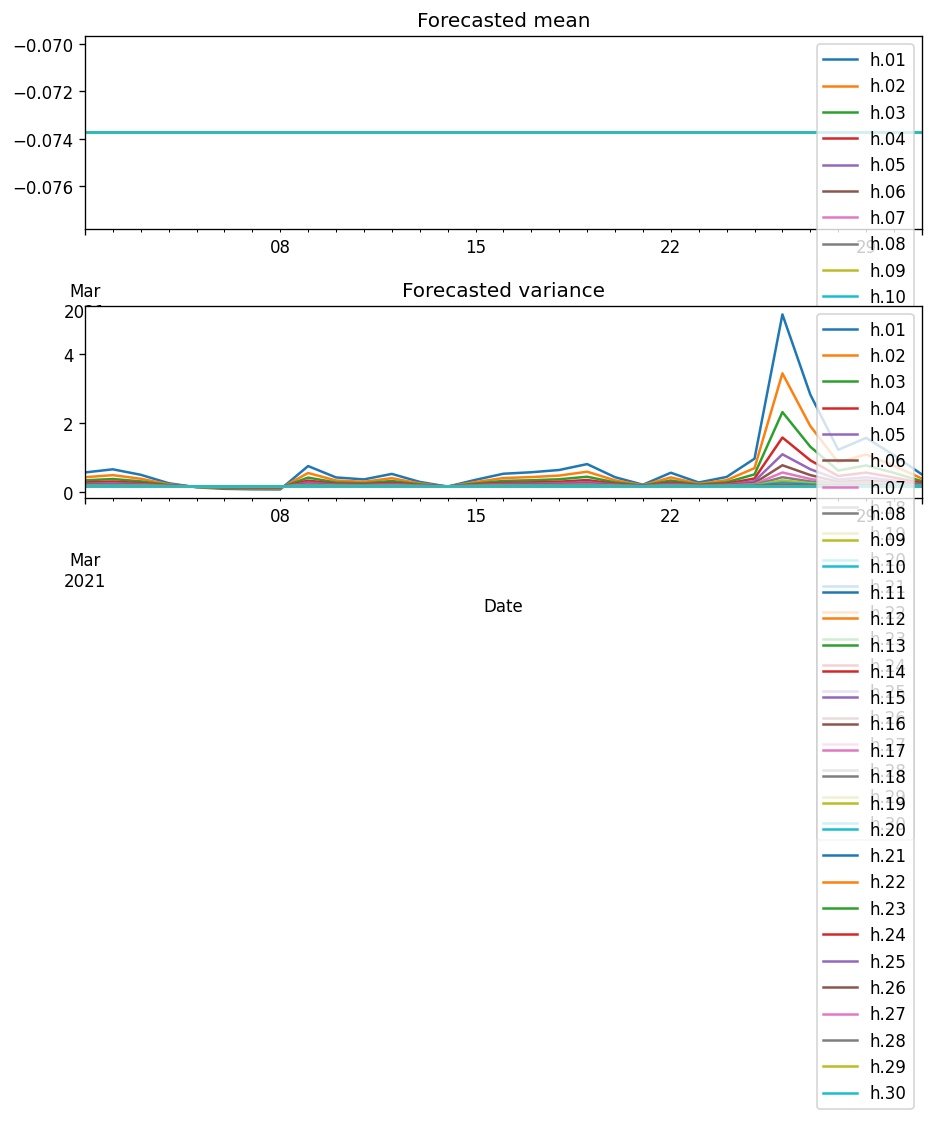

In [617]:
# среднее прогноза 
forecasts.mean[split_date:].plot(ax=plt.subplot(2, 1, 1));
plt.title('Forecasted mean')

# дисперсия прогноза 
forecasts.variance[split_date:].plot(ax=plt.subplot(2, 1, 2));
plt.title('Forecasted variance')
plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.show()

# Обоснование выбора метрики для оптимизации

Для выбора метрики важно понимать последствия ошибок. 
- Недооценка сальдо (прогноз ниже фактического). Отсутсвие возможности разместить больше средств на рынке деривативов. То есть потери прибыли в размере = value * (credit_rate + 0.5)/365.
- Переоценка сальдо (прогноз выше фактического). Допуск дефицит, что приведет к необходимости заимствования по высокой ставке (ключ + 1%), увеличивая затраты. То есть потери прибыли в размере = value * (credit_rate + 1)/365.

Ошибка по переоценке сальдо имеет большие потери, но оба варианта сильно зависят от разницы между прогнозом и фактическим значением

Рассмотрим несколько метрик и их применимость:

**MAE (Mean Absolute Error)**:
- Непосредственно измеряет среднюю абсолютную ошибку, что соответствует требованию заказчика (ошибка ≤ 0.42).
- Показывает среднее отклонение прогноза от фактического сальдо.
- Устойчива к знаку ошибки, что важно для сальдо, которое может быть положительным или отрицательным.
- Линейно штрафует ошибки, что отражает финансовые последствия, так как затраты/упущенная выгода пропорциональны величине ошибки.
- Не учитывает квадратичные эффекты, если крупные ошибки имеют непропорционально большие последствия.


**MSE (Mean Squared Error)**:
- Сильнее штрафует большие ошибки из-за квадратичной зависимости, что может быть полезно, если крупные отклонения критичны.
- Менее интерпретируема в контексте требования заказчика (0.42 в абсолютном значении).
- Чувствительна к выбросам, что может исказить оптимизацию, если в данных есть аномалии (например, в налоговые дни).

**RMSE (Root Mean Squared Error)**:
- Сохраняет интерпретируемость в единицах исходной переменной (как MAE).
- Учитывает большие ошибки сильнее, чем MAE.

**Custom Loss (асимметричная потеря)**:<br>
Можно разработать метрику, которая по-разному штрафует переоценку и недооценку сальдо, учитывая разницу в доходности/затратах (например, +0.5% для деривативов vs. +1% для заимствований).
- Точно отражает финансовые последствия.
- Сложнее реализовать и оптимизировать.

В датасете есть дни с нулевым сальдо (выходные), а также аномалии (налоговые дни). MAE менее чувствительна к выбросам, чем MSE или RMSE, что делает ее более стабильной для оптимизации, еще MAE легко объяснить бизнесу - средняя ошибка в единицах сальдо.

# Выбор модели

#### GARCH

Так как GARCH модель может быть рассмотрена как  ARMA для квадратов отклонений, можно использовать информационный критерий  (AIC) или (BIC).

Если для ежедневных доходностей мы ограничемся только ARCH(p) модель, то мы можем подобрать очень большое значение p по информационному критерию. 

Для  GARCH(p,q) обычно подбираем p,q ≤ 2 по информационным критериям. Модель GARCH(p,q) с меньшим параметрами предпочтительна перед ARCH(p) с  большим параметром p (устойчивость оценок и переобучение)

Тажке баланс может иметь изменяющуюся волатильность (рыночные шоки), что хорошо отловит модель

#### ARIMA

Хорошо подходит для прогнозирования самого баланса, так как она эффективно моделирует нестационарные ряды с трендами. Подбор параметров по AIC минимизирует переобучение

#### Linear regression

Лучший учёт внешних факторов. Регуляризация (Ridge) и проверка VIF обеспечивают устойчивость модели

### GridSearch

перебор всех возможных комбинаций заданных значений гиперпараметров

In [621]:
import itertools
from sklearn.metrics import mean_absolute_error

In [619]:
data = feature_engineering_data.copy()

y = data['Balance']
X = data.drop(['Balance'], axis=1)

x_sample = X[intersection_features]

X_train, X_test, y_train, y_test = train_test_split(x_sample, y, test_size=0.4, random_state=42)

In [ ]:
def arima_grid_search(y, p_range, d_range, q_range):
    best_aic = np.inf
    best_params = None
    best_model = None
    
    param_grid = list(itertools.product(p_range, d_range, q_range))
    
    for params in param_grid:
        p, d, q = params
        try:
            model = ARIMA(y, order=(p, d, q))
            fit = model.fit()
            aic = fit.aic
            if aic < best_aic:
                best_aic = aic
                best_params = params
                best_model = fit
        except:
            continue
    
    return best_model, best_params, best_aic

p_range = [0, 1, 2, 3, 4] # количество прошлых значений временного ряда
d_range = [0, 1, 2] # сколько дифференцировать до стационарности
q_range = [0, 1, 2, 3, 4] # число влияющих ошибок

arima_model, arima_params, arima_aic = arima_grid_search(y_train, p_range, d_range, q_range)
arima_pred = arima_model.forecast(steps=len(y_test))
arima_mse = mean_absolute_error(y_test, arima_pred)

print(f"params: {arima_params}, AIC: {arima_aic:.4f}, MAE: {arima_mse:.4f}")

ARIMA Best Params: (0, 0, 0), AIC: 964.5294, MAE: 0.3151


In [ ]:
def garch_grid_search(y, p_range, q_range):
    best_aic = np.inf
    best_params = None
    best_model = None

    param_grid = list(itertools.product(p_range, q_range))
    
    for params in param_grid:
        p, q = params
        try:
            model = arch_model(y, vol='GARCH', p=p, q=q)
            fit = model.fit(disp='off')
            aic = fit.aic
            if aic < best_aic:
                best_aic = aic
                best_params = params
                best_model = fit
        except:
            continue
    
    return best_model, best_params, best_aic

p_range = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # число влияющих квадратов ошибок
q_range = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # число влияющих условных дисперсий

garch_model, garch_params, garch_aic = garch_grid_search(y_train, p_range, q_range)
garch_pred = garch_model.forecast(horizon=len(y_test)).mean.values[-1, :]
garch_mse = mean_absolute_error(y_test, garch_pred)

print(f"params: {garch_params}, AIC: {garch_aic:.4f}, MAE: {garch_mse:.4f}")

GARCH Best Params: (4, 0), AIC: 965.0325, MAE: 0.3147


In [629]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
}

# Кросс-валидация для временных рядов
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV
ridge_grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
ridge_grid.fit(X_train, y_train)

# Предсказания и оценка
ridge_pred = ridge_grid.predict(X_test)
ridge_mse = mean_absolute_error(y_test, ridge_pred)

print(f"params: {ridge_grid.best_params_}, score: {-ridge_grid.best_score_:.4f}, MAE: {ridge_mse:.4f}")

Ridge Best Params: {'ridge__alpha': 100.0}, Best Score: 0.2579, MAE: 0.2759


Exception ignored in: <function ResourceTracker.__del__ at 0x105247880>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104ea3880>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/m

#### Генетический алгоритм

эволюционный поиск гиперпараметров путем случайных комбинаций

In [635]:
class GeneticAlgorithmGARCH:
    def __init__(self, population_size=20, generations=10, mutation_rate=0.1, tournament_size=3):
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.tournament_size = tournament_size
        self.p_range = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        self.q_range = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    def initialize_population(self):
        """Создаёт начальную популяцию случайных комбинаций (p, q)."""
        return [(random.choice(self.p_range), random.choice(self.q_range)) 
                for _ in range(self.population_size)]

    def fitness(self, params, y):
        """Оценивает пригодность (меньший AIC = лучше)."""
        p, q = params
        try:
            model = arch_model(y, vol='GARCH', p=p, q=q)
            fit = model.fit(disp='off')
            return fit.aic
        except:
            return np.inf  # Если модель не сошлась, возвращаем плохую пригодность

    def select_parents(self, population, fitnesses):
        """Турнирная селекция: выбирает лучших из случайной подгруппы."""
        selected = []
        for _ in range(2):  # Выбираем двух родителей
            tournament = random.sample(list(zip(population, fitnesses)), self.tournament_size)
            winner = min(tournament, key=lambda x: x[1])[0]  # Минимизируем AIC
            selected.append(winner)
        return selected

    def crossover(self, parent1, parent2):
        """Кроссовер: случайный выбор p и q от родителей."""
        p = random.choice([parent1[0], parent2[0]])
        q = random.choice([parent1[1], parent2[1]])
        return (p, q)

    def mutate(self, individual):
        """Мутация: случайное изменение p или q с вероятностью mutation_rate."""
        p, q = individual
        if random.random() < self.mutation_rate:
            p = random.choice(self.p_range)
        if random.random() < self.mutation_rate:
            q = random.choice(self.q_range)
        return (p, q)

    def run(self, y):
        """Запуск генетического алгоритма."""
        population = self.initialize_population()
        best_params = None
        best_aic = np.inf

        for generation in range(self.generations):
            # Оценка пригодности всей популяции
            fitnesses = [self.fitness(params, y) for params in population]
            
            # Сохранение лучшего решения
            min_aic = min(fitnesses)
            if min_aic < best_aic:
                best_aic = min_aic
                best_params = population[fitnesses.index(min_aic)]
            
            # Создание нового поколения
            new_population = []
            for _ in range(self.population_size // 2):
                # Селекция
                parent1, parent2 = self.select_parents(population, fitnesses)
                # Кроссовер
                offspring1 = self.crossover(parent1, parent2)
                offspring2 = self.crossover(parent1, parent2)
                # Мутация
                offspring1 = self.mutate(offspring1)
                offspring2 = self.mutate(offspring2)
                new_population.extend([offspring1, offspring2])
            
            population = new_population[:self.population_size]
            print(f"Generation {generation + 1}, AIC: {best_aic:.4f}, params: {best_params}")

        return best_params, best_aic

In [637]:
ga = GeneticAlgorithmGARCH(population_size=20, generations=10, mutation_rate=0.1, tournament_size=3)
best_params, best_aic = ga.run(y_train)

p, q = best_params
best_model = arch_model(y_train, vol='GARCH', p=p, q=q)
fit = best_model.fit(disp='off')
pred = fit.forecast(horizon=len(y_test)).mean.values[-1, :]
mae = np.mean(np.abs(y_test - pred))
# mse = np.mean((y_test - pred) ** 2)

print(f"params: (p={p}, q={q}), AIC: {best_aic:.4f}, MAE: {mae:.4f}")

Generation 1, AIC: 965.9097, params: (3, 0)
Generation 2, AIC: 965.9097, params: (3, 0)
Generation 3, AIC: 965.9097, params: (3, 0)
Generation 4, AIC: 965.9097, params: (3, 0)
Generation 5, AIC: 965.9097, params: (3, 0)
Generation 6, AIC: 965.0325, params: (4, 0)
Generation 7, AIC: 965.0325, params: (4, 0)
Generation 8, AIC: 965.0325, params: (4, 0)
Generation 9, AIC: 965.0325, params: (4, 0)
Generation 10, AIC: 965.0325, params: (4, 0)
params: (p=4, q=0), AIC: 965.0325, MAE: 0.3147



 # Анализ остатков

Анализ остатков — это техника, которая помогает понять, есть ли у прогнозирующей модели небольшие
недостатки, которые можно устранить доработкой, или же фундаментальные проблемы.

Остатки — это разность между фактом и прогнозом:
$$\hat ε_t = y_t − \hat y_t.$$

Их можно вычислять двумя способами. 

1. Прогнозы, которые участвуют в остатках, можно строить
с фиксированной отсрочкой. Например, начиная с момента R прогноз всегда делается на одну точку вперёд,
затем происходит переход в момент R + 1, получается новое истинное значение ряда, которое сравнивается с
прогнозом, затем следующий прогноз делается ещё на одну точку вперёд, и так далее до самого конца ряда:
$$\hat y_{R+d|R}, \dots , \hat y_{T|T −d}.$$


2. Остатки можно строить с фиксированным концом истории при разных отсрочках. Например,
берётся начальная часть ряда от 0 до T − D, и далее делаются прогнозы


$$ \hat y_{T −D+1|T −D},\dots , \hat y_{T|T −D},$$
полученные прогнозы сравниваются с истинными значениями ряда, и с их помощью вычисляются остатки.


В зависимости от задачи могут использоваться разные определения остатков, однако чаще используется
первое. Остатки оценивают ошибку, то есть шумовую компоненту, которую наблюдать невозможно. При
построении модели делаются предположения об этой шумовой компоненте, и логично, что свойства остатков
должны согласовываться с выдвинутыми предположениями.


# Несмещённость
Во-первых, остатки должны быть несмещёнными, то есть в среднем они должны быть равны нулю.

Гипотезу о несмещённости остатков $H_0 : ε = 0$ можно формально проверить с помощью какого-либо стандартного одновыборочного критерия (например, критерия Стьюдента или Уилкоксона). Если выясняется,
что остатки смещены, значит с моделью что-то не так. В этом случае рекомендуется провести визуальный
анализ, чтобы посмотреть, почему прогнозы систематически завышаются или занижаются.


На самом деле, модель очень легко скорректировать в случае, если остатки имеют смещение. Достаточно
вычислить среднее значение остатков, это и будет константой, на которую необходимо скорректировать все
прогнозы, чтобы остатки стали несмещёнными. После этого преобразования прогнозирующая модель улучшится.

# Стационарность

Ещё одно свойство, наличие которого предполагается у ошибок, — это стационарность, то есть отсутствие
зависимости от времени. Таким образом, остатки во времени должны быть распределены примерно одинаково.

Формально гипотезу о стационарности можно проверить с помощью критерия Дики-Фуллера. Если стационарность отсутствует, то модель неодинаково точна в разные периоды времени. Необходимо провести
визуальный анализ, чтобы понять, что с моделью не так, и почему прогнозы в разные периоды времени
систематически имеют разную ошибку.

 # Неавтокоррелированность


Ещё одно желаемое свойство остатков — это неавтокоррелированность, то есть отсутствие зависимости от
предыдущих наблюдений.


Гипотезу о неавтокоррелированности можно проверить по коррелограмме, а также с помощью Q-критерия Льюнга-Бокса (таблица 1.3). Этот критерий позволяет проверить гипотезу о равенстве нулю одновременно
нескольких автокорреляций при разных лагах (с лага 1 по лаг Q). Параметр Q можно выбирать, например,
перебором, а можно пользоваться значением по умолчанию, использующемся в функции, которая производит
оценку модели ARIMA.

ряд ошибок прогноза: $ε^T = ε_1, \dots, ε_T$
нулевая гипотеза: $H_0 : r_1 = · · · = r_Q = 0$
альтернатива: $H_1 : H_0 $ неверна
статистика: $Q(ε^T)= T (T + 2)\sum_{\tau=1}^Q \frac{r^2_τ}{T −τ}$
нулевое распределение: $Q(ε^T) ∼ χ^2_{Q−K}$ при $H_0$, 
K — число настраиваемых параметров модели.




Автокоррелированность остатков — признак того, что в данных присутствует информация, которая не
вошла в модель. 

Если в остатках есть структура, то можно попытаться её внести в модель явным образом.


Скорректированная модель будет лучше, а её остатки будут больше похожи на белый шум. 

Таким образом, автокоррелированность остатков только указывает на
потенциальную возможность улучшить модель, и не факт, что улучшения можно добиться на практике с
помощью рассматриваемого класса моделей.

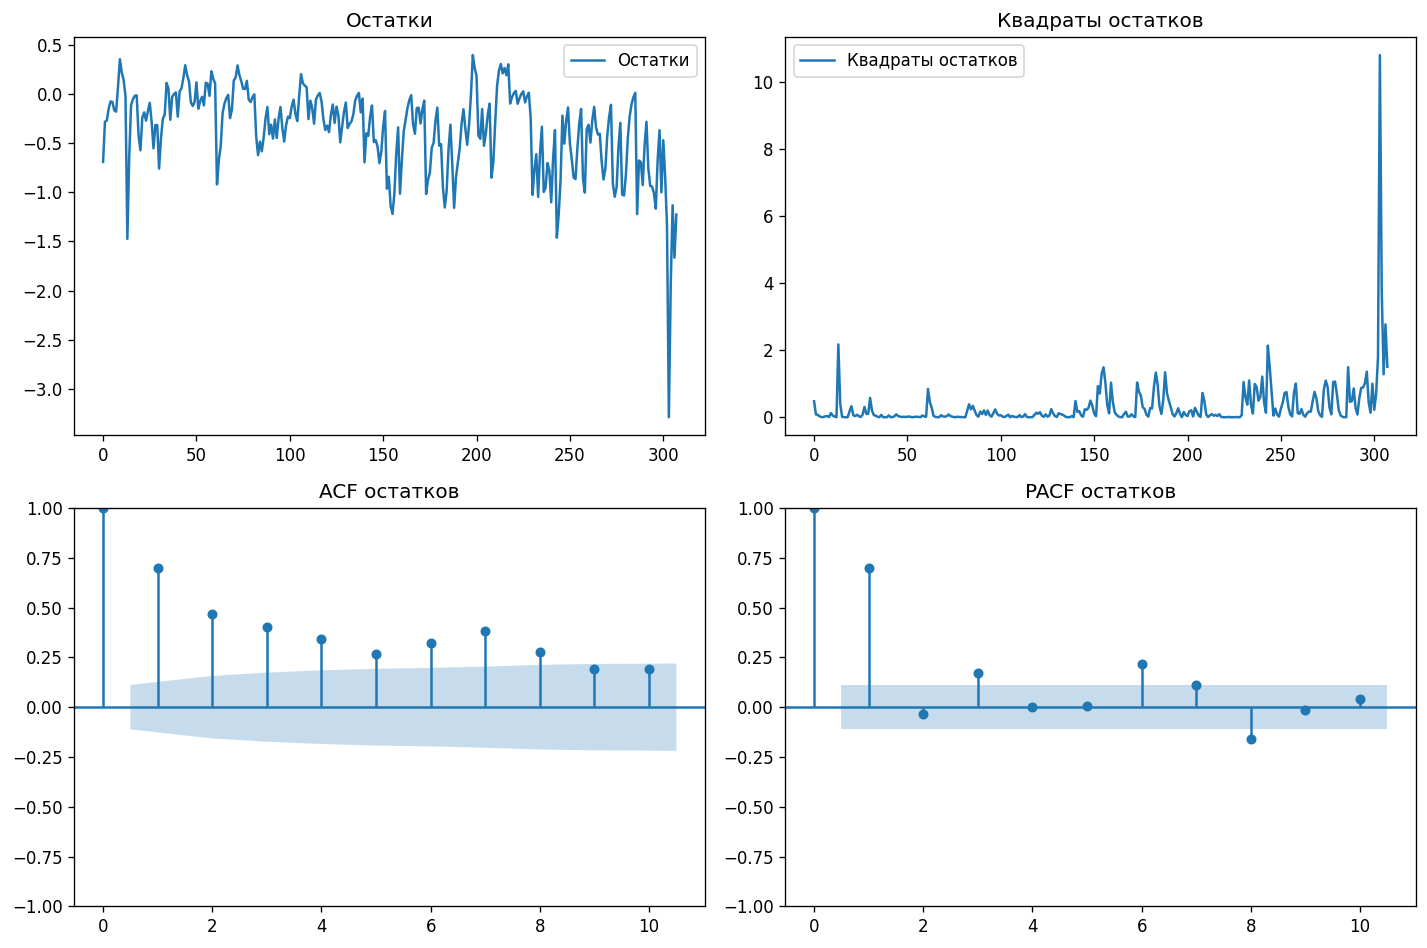

mean_residuals: -0.36253568515089096, t_test (statistic, p_value): (np.float64(-14.795487518872802), np.float64(9.176540864003453e-38)), wilcoxon (statistic, p_value):(np.float64(3883.0), np.float64(4.102715230257164e-37))
Остатки смещены. Среднее остатков: -0.3625
Рекомендуется скорректировать прогнозы на константу: -0.36253568515089096
adf_statistic: -2.382222719147113, p_value: 0.14681690495318445, critical_values {'1%': np.float64(-3.4523371197407404), '5%': np.float64(-2.871222860740741), '10%': np.float64(-2.571929211111111)}
Ljung-Box Test (lag=10): p-value = 0.0000
MAE: 0.4068


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, acf
from scipy.stats import ttest_1samp, wilcoxon

R = int(len(y) * 0.8)  
p, q = 4, 0
max_lags=10

residuals = []
forecasts = []
true_values = []

# рекурсивное обучение
for t in range(R, len(y)-1):
    model = arch_model(y[:t], vol='GARCH', p=p, q=q).fit(disp='off')
    forecast = model.forecast(horizon=1).mean.values[0, 0]
    true_value = y[t]
    residual = true_value - forecast
    residuals.append(residual)
    forecasts.append(forecast)
    true_values.append(true_value)

residuals = np.array(residuals)
forecasts = np.array(forecasts)
true_values = np.array(true_values)

mae = np.mean(np.abs(residuals))

plt.figure(figsize=(12, 8))

# График остатков
plt.subplot(2, 2, 1)
plt.plot(residuals, label='Остатки')
plt.title('Остатки')
plt.legend()

# График квадратов остатков
plt.subplot(2, 2, 2)
plt.plot(residuals**2, label='Квадраты остатков')
plt.title('Квадраты остатков')
plt.legend()

# ACF остатков
plt.subplot(2, 2, 3)
plot_acf(residuals, ax=plt.gca(), lags=max_lags)
plt.title('ACF остатков')

# PACF остатков
plt.subplot(2, 2, 4)
plot_pacf(residuals, ax=plt.gca(), lags=max_lags)
plt.title('PACF остатков')

plt.tight_layout()
plt.show()

# Проверка несмещённости (H0: среднее остатков = 0)
t_stat, t_pvalue = ttest_1samp(residuals, 0)
wilcoxon_stat, wilcoxon_pvalue = wilcoxon(residuals)
    
mean_residuals = np.mean(residuals)
print(f"mean_residuals: {mean_residuals}, t_test (statistic, p_value): {t_stat, t_pvalue}, wilcoxon (statistic, p_value):{wilcoxon_stat, wilcoxon_pvalue}")

if t_pvalue < 0.05 or wilcoxon_pvalue < 0.05:
    print(f"Остатки смещены. Среднее остатков: {mean_residuals:.4f}")
    print("Рекомендуется скорректировать прогнозы на константу:", mean_residuals)

# Проверка стационарности (критерий Дики-Фуллера)
adf_result = adfuller(residuals)
print(f"adf_statistic: {adf_result[0]}, p_value: {adf_result[1]}, critical_values {adf_result[4]}")

# Проверка неавтокоррелированности (Тест Льюнга-Бокса)Тест Лижунга-Бокса
lb_test = acorr_ljungbox(residuals, lags=[max_lags], return_df=True)
print(f"Ljung-Box Test (lag=10): p-value = {lb_test['lb_pvalue'].iloc[0]:.4f}")
print(f"MAE: {mae:.4f}")

1. Автокорреляция в остатках
Тест Лижунга-Бокса: Значение p-value = 0.0000 при лаге 10 указывает на то, что нулевая гипотеза об отсутствии автокорреляции в остатках отвергается. Это означает, что остатки не являются белым шумом, как ожидается от адекватной модели GARCH, и в них присутствует значимая автокорреляция.
Интерпретация: Модель GARCH не смогла полностью учесть временную структуру данных. Наличие автокорреляции говорит о том, что в остатках остались неучтенные зависимости, которые модель не объясняет.

2. Точность прогнозов
MAE (Mean Absolute Error): Значение MAE = 0.4068 отражает среднюю абсолютную ошибку прогнозов модели. Это дает общее представление о точности, но само по себе не является достаточным показателем качества модели, особенно в условиях выявленной автокорреляции в остатках.
Ограничение: Поскольку остатки не являются белым шумом, значение MAE не может считаться надежным критерием для оценки модели, так как её базовые предположения нарушены.

1. Несмещённость
t-тест указывает на статистически значимое отклонение среднего остатков от нуля (p-value < 0.05), что подтверждает наличие смещения. Остатки в среднем отрицательны, то есть модель систематически завышает прогнозы на величину около 0.0432.
Критерий Уилкоксона не отвергает гипотезу о нулевом среднем (p-value > 0.05), что может быть связано с ненормальным распределением остатков или меньшей мощностью теста в данном случае.
Рекомендация: Поскольку t-тест подтверждает смещение, модель можно улучшить, скорректировав прогнозы на константу +0.0432 (то есть прибавить эту величину к прогнозам). Это устранит смещение, делая остатки в среднем равными нулю.
Дополнительно: Рекомендуется провести визуальный анализ остатков (например, построить график остатков во времени), чтобы понять, является ли смещение постоянным или варьируется во времени.

2. Стационарность
Статистика ADF (-3.8033) меньше критических значений на всех уровнях значимости (1%, 5%, 10%), а p-value (0.0029) значительно ниже 0.05. Это означает, что нулевая гипотеза о наличии единичного корня (нестационарности) уверенно отвергается.
Остатки стационарны, то есть их распределение не зависит от времени, и модель в этом аспекте работает корректно.
Рекомендация: Дополнительных действий не требуется, так как стационарность подтверждена. Однако стоит проверить, нет ли других форм нестационарности (например, гетероскедастичности), если это не учтено моделью GARCH.

3. Неавтокоррелированность
Очень высокая статистика Льюнга-Бокса и p-value, равное 0.0 (< 0.05), указывают на уверенное отвержение нулевой гипотезы о неавтокоррелированности остатков. Это означает, что в остатках присутствует значительная автокорреляция на лагах до 10.
Наличие автокорреляции говорит о том, что модель GARCH не полностью улавливает динамику временного ряда, и в остатках остаются неучтённые зависимости.



# Добавить ARMA-компоненту в модель (например, ARMA-GARCH)

Смещение: Скорректируйте прогнозы на константу +0.0432, чтобы устранить смещение. Проверьте, сохраняется ли смещение после корректировки.

Стационарность: Остатки стационарны, что хорошо. Дополнительных действий в этом направлении не требуется.

Автокорреляция: Значительная автокорреляция указывает на недостатки модели. Проверьте коррелограмму, чтобы определить лаги с высокой автокорреляцией, и попробуйте усложнить модель (увеличить p, q или добавить ARMA-компоненту).

Визуальный анализ:
Постройте график остатков во времени, чтобы проверить, есть ли систематические паттерны (например, тренды или выбросы).
Изучите коррелограмму и PACF для определения структуры автокорреляции.

Дальнейшая диагностика:
Проверьте остатки на гетероскедастичность (например, с помощью теста ARCH-LM), чтобы убедиться, что GARCH-компонента адекватно моделирует волатильность.

Рассмотрите возможность включения экзогенных переменных, если автокорреляция связана с неучтёнными факторами.

# Последовательное обнаружение разладок временных рядов

1. Всюду в рассматриваемых задачах
имеется две гипотезы $\mathbb{H}_0$ и $\mathbb{H}_1$ 
(иногда они обозначаются $\mathbb{H}_{\infty}$ и
$\mathbb{H}_0$, соответственно), причем каждая 
из гипотез делает явные предположения о распределении
или его параметрах.
\item Критерий Неймана-Пирсона предписывает
принимать гипотезу исходя из значения величины
$$
L_n(X_1, \ldots, X_n) = \frac{f_0(X_1, \ldots, X_n)}{f_{\infty}(X_1, \ldots, X_n)},
$$
называемой отношением правдоподобия.
А именно, пусть $\varphi(X_1, \ldots, X_n)$~-- 
рандомизированное решающее правило, значение
которого равно вероятности принять 
гипотезу $\mathbb{H}_1$. Тогда найдутся такие
константы $\lambda_a$ и $h_a$, что 
$$
\varphi(X_1, \ldots, X_n) = 
\begin{cases}
    1, & L_n(X_1, \ldots, X_n) > h_a, \\
    \lambda_a, & L_n(X_1, \ldots, X_n) = h_a, \\
    0, & L_n(X_1, \ldots, X_n) < h_a,
\end{cases}
$$
является наиболее мощным 
(т.е. с наименьшей вероятностью пропуска цели 
или ошибки 2 рода $\beta(\varphi)$) тестом 
среди тестов, вероятность ложной
тревоги $\alpha(\varphi)$
(ошибки 1 рода) которых не выше $a$.

2. Разладкой процесса $X_t$
называется ситуация, в которой траектория
процесса генерируется двумя (или 
в общем случае несколькими) независимыми
вероятностными мерами $\mathrm{P}_{\infty}$
и $\mathrm{P}_{0}$, причем наблюдения имеют структуру
$$
X_n = 
\begin{cases}
    X^{\infty}_n, & \text{если } 1 \leqslant n < \theta, \\
    X^{0}_n, & \text{если } n \geqslant \theta,
\end{cases}
$$
где $X^{\infty}_t$ --- 
процесс, соответствующий мере $\mathrm{P}_{\infty}$,
и $X^{0}_t$ ---
процесс, соответствующий мере $\mathrm{P}_{0}$.
Момент $\theta \in [0, \infty]$
называется моментом разладки, причем
ситуация $\theta = 0$ соответствует тому, что 
с самого начала идут наблюдения от 
_разлаженного_ процесса $X^{0}$,
а ситуация $\theta = \infty$ заключается в том,
что разладка не появляется никогда.
Таким образом, траектория процесса $X$ выглядит
следующим образом:
$$
\underbrace{X^{\infty}_1, X^{\infty}_2, \ldots, 
X^{\infty}_{\theta - 1}}
    _{\text{мера } \mathrm{P}^{\infty}},
\underbrace{X^{0}_{\theta}, X^{0}_{\theta + 1}, \ldots}
    _{\text{мера } \mathrm{P}^{0}}
$$

3. **Статистика кумулятивных сумм.**

 - Вводятся статистики $\gamma_t$ 
 и $T_t$ 
$$
\gamma_n = \sup\limits_{\theta \geqslant 0} \frac{f_{\theta}(X_1, \ldots, X_n)}{f_{\infty}(X_1, \ldots, X_n)}
 \qquad T_n = \log \gamma_n
$$

 - Если случайные величины
$X_1, \ldots, X_n$ независимы, то
$$
\gamma_n = \max\Big\{1, \max\limits_{1 \leqslant \theta \leqslant n} \prod\limits_{k=\theta}^{n}
    \frac{f_{0}(X_k)}{f_{\infty}(X_k)} \Big\}
$$
$$
T_n = \max\Big\{0, \max\limits_{1 \leqslant \theta \leqslant n} \sum\limits_{k=\theta}^{n}
    \log \frac{f_{0}(X_k)}{f_{\infty}(X_k)} \Big\} = 
    \max\Big\{0, \max\limits_{1 \leqslant \theta \leqslant n} \sum\limits_{k=\theta}^{n}
    \zeta_k \Big\}
$$

 - Статистика $T_n$ обладает свойством $T_n = \max (0, T_{n-1} + \zeta_n)$
и называется статистикой кумулятивных сумм (CUmulative SUMs, CUSUM).

 - Момент остановки
$$
\tau_{\mathrm{CUSUM}} = \inf \{n \geqslant 0: T_n \geqslant B\},
$$
построенный по статистике кумулятивных сумм,
оптимален (т.\,е.~обладает наименьшей задержкой
в обнаружении разладки) в~классе
$$
\mathcal{M}_T = \{\tau : 
    {\textstyle \mathrm{E}_{\infty}} \tau \geqslant T\}
$$
тех моментов остановки, для которых среднее время
до~ложной тревоги не меньше $T$.

4. **Статистика Ширяева-Робертса.**

 - Вводится статистика
$$
R_n = \sum\limits_{\theta = 1}^{n} \frac{f_{\theta}(X_1, \ldots, X_n)}{f_{\infty}(X_1, \ldots, X_n)}
$$

 - Если случайные величины $X_1, \ldots, X_n$ независимы, то
$$
R_n = \sum\limits_{\theta = 1}^{n} \prod\limits_{k=\theta}^{n}
    \frac{f_{0}(X_k)}{f_{\infty}(X_k)} =
        \sum\limits_{\theta = 1}^{n} \prod\limits_{k=\theta}^{n}
    l_k.
$$ 

 - Статистика $R_n$ обладает свойством $R_n = (1 + R_{n-1}) l_k$ и~называется статистикой Ширяева-Робертса (Shiryaev-Roberts, SR).
 
 - Момент остановки 
$$
\tau_{\mathrm{SR}} = \inf \{n \geqslant 0: R_n \geqslant B\},
$$
построенный по статистике Ширяева-Робертса,
оптимален (т.\,е.~обладает наименьшей задержкой
в обнаружении разладки) в~классе
$$
\mathcal{M}_T = \{\tau : 
    {\textstyle \mathrm{E}_{\infty}} \tau \geqslant T\}
$$
тех моментов остановки, для которых среднее время
до~ложной тревоги не меньше $T$.


## Разладки

In [ ]:
# округляем как в данных 8 цифр после запятой
# методы для создания синтетических данных с разными видами разладки


# 1. Разладка: Скачок среднего
def get_avg_shift_data(n, avg1,avg2,disp):
    data = np.round(np.concatenate([
    np.random.normal(avg1, disp, n),
    np.random.normal(avg2, disp, n)
]), 8)
    
    return data


# 2. Разладка: Увеличение дисперсии
def get_disp_shift_data(n,disp1,disp2,avg):
    data = np.round(np.concatenate([
    np.random.normal(avg, disp1, n),
    np.random.normal(avg, disp2, n)
]), 8)
    
    return data



# 3. Разладка: Линейный тренд
def get_lin_trend_data(n, avg, disp, k):
    trend = np.linspace(0, avg*k, n)
    data = np.round(np.concatenate([
    np.random.normal(avg, disp, n),
    avg + trend + np.random.normal(0, disp, n)
]), 8)
    
    return data



# 4. Разладка: Периодичность
def get_period_data(n, avg, disp, freq , d):
    x = np.arange(n)
    data = np.round(np.concatenate([
    np.random.normal(avg, disp, n),
    avg + d *np.sin(x*freq*np.pi/10) + np.random.normal(0, disp, n)
]), 8)
    
    return data

# Получение размеченных данных
def get_pd_razm(data, rasm_mark):
    df = pd.DataFrame({'data': data})
    df["shift_target"] = 0
    df["shift_target"][rasm_mark] = 1
    return df


data1 = get_avg_shift_data(10,5,8,0.5)
data2 = get_disp_shift_data(10,0.5,1,5)
data3 = get_lin_trend_data(10,5,0.3,0.5)
data4 = get_period_data(10, 5 , 0.5, 5, 2)

print("1. Скачок среднего:", data1)
print("2. Рост дисперсии:", data2)
print("3. Линейный тренд:", data3)
print("4. Периодичность:", data4)
# print("4. Периодичность:", type(data4))
print("Размеченные данные", get_pd_razm(data4,10))

1. Скачок среднего: [4.89363534 5.01814736 4.43122685 4.84744983 5.34099742 5.4455667
 4.69986914 4.95185224 5.29294437 5.00600421 8.19122462 8.21920038
 7.47661756 7.41056049 8.18793901 8.31700472 8.32382343 8.50007531
 7.67761758 7.56517027]
2. Рост дисперсии: [5.56580352 4.58212338 4.51442358 5.42035282 5.64085205 3.80531266
 5.40196029 4.75997172 5.67245697 5.27321067 6.16843676 4.36701572
 6.1468359  5.3374185  4.85194031 5.82150916 5.04478671 4.79759595
 3.92197962 4.74533812]
3. Линейный тренд: [4.9273473  4.42827907 5.40831535 4.56772133 5.42002182 4.71081464
 5.28126874 5.08691739 4.63707338 4.82811755 5.3798586  5.47752891
 5.65896999 6.03091937 5.93138263 6.10566274 6.27311939 6.48358397
 7.35685026 6.78648584]
4. Периодичность: [4.24151042 5.29441041 5.50023344 4.95958821 4.09569423 4.61039213
 5.87450053 5.75076883 5.25016626 5.33715679 5.79768311 7.47755625
 5.25234978 3.02722959 5.34661658 6.90768713 5.6875115  3.24436703
 5.69317585 6.82914908]
Размеченные данные       

In [ ]:
# В этой части мы сделаем методы которые будут считать метрики по котрым будет выбран алгоритм поиска разладки


# • Хорошо : E∞τ → ∞ (редкие ложные тревоги)
# • E0τ или E∞[ τ − θ|τ > θ] : средняя задержка в обнаружении
# (average detection delay, ADD(τ ))
# • Хорошо : E0τ → 0 (быстрое обнаружение)

# • Плохо : Pθ(τ < θ) → 1 (частые ложные тревоги)
# • E0τ или Eθ[ τ − θ|τ > θ] : средняя задержка в обнаружении
# (average detection delay, ADD(τ ))
# • Плохо : Eθ(τ < θ) → ∞
# (медленное обнаружение)
# • В практике: задержка срабатывания ADD(τ )
# и время без ложных тревог FDD(τ ) — конфликтующие критерии (строится зависимость одного отдругого)




# задержка срабатывания
def detect_delay(target_col, predict_col):
    # Находим первую 1 в target_col
    shift_ind_target = target_col.eq(1).idxmax()
    
    # Выбираем часть predict_col после shift_ind_target
    predict_subset = predict_col[predict_col.index > shift_ind_target]
    
    # Проверяем есть ли 1 в этой части
    if predict_subset.eq(1).any():
        # Если есть, находим первую 1 и считаем задержку
        shift_ind_predict = predict_subset.eq(1).idxmax()
        return int(shift_ind_predict) - shift_ind_target
    else:
        # Если нет 1, возвращаем shift_ind_target * 5
        return shift_ind_target * 5



# среднее время до ложного срабатывания
def detect_wrong_delay( target_col, predict_col):
    shift_ind_target = target_col.eq(1).idxmax()
    num_wrong_detect = predict_col.loc[:shift_ind_target].eq(1).sum()
    return min(shift_ind_target/(num_wrong_detect+1),shift_ind_target+1)


# функция которую мы будем максимизировать на разных данных 
# будем пытаться увеличить время до ложного срабатывания и уменьшить время до правильного срабатывания
def shift_quality_metric(target_col, predict_col):
    return detect_wrong_delay( target_col, predict_col)/detect_delay(target_col,predict_col) 



In [ ]:
target_col =  pd.Series([0, 0, 0, 1, 0, 0, 0, 0])

# Predict series (предсказание) с задержкой в 2 периода
predict_col = pd.Series([1, 1, 0, 0, 0, 0, 0, 1])

# Применяем функцию
delay = detect_delay(target_col, predict_col)
w_delay = detect_wrong_delay(target_col, predict_col)
q_metric = shift_quality_metric(target_col, predict_col)
print(f"Задержка: {delay}")  # Выведет 2 (разница индексов между первыми 1)
print(f"w_delay: {w_delay}")  # Выведет 2 (разница индексов между первыми 1)
print(f"shift_quality_metric: {q_metric}")  # Выведет 2 (разница индексов между первыми 1)

Задержка: 4
w_delay: 1.0
shift_quality_metric: 0.25


In [ ]:
# генерим данные(так как мы не знаем какие у нас будут разладки будем готовится ко всем)

from sklearn.model_selection import ParameterGrid

def get_test_data():
    vectorized_avg_shift = np.vectorize(get_avg_shift_data, excluded=['n'])
    vectorized_disp_shift = np.vectorize(get_disp_shift_data, excluded=['n'])
    vectorized_lin_trend = np.vectorize(get_lin_trend_data, excluded=['n'])
    vectorized_period = np.vectorize(get_period_data, excluded=['n'])

    n = 2000
    avg_min = 0
    avg_max = 10
    disp_min = 0.1
    disp_max = 3
    k_min = -3
    k_max = 3
    freq_min = 0.1
    freq_max = 10
    d_min = 0.2
    d_max = 4
    n_iter = 1000 # нужно чтобы кол-во датасетов с периодами не было слишком много



    param_grid_avg = {
    'avg1': np.linspace(avg_min, avg_max, num=int(np.round(n_iter**(1/3)))),
    'avg2': np.linspace(avg_max*1.1, avg_max*2, num=int(np.round(n_iter**(1/3)))),
    'disp': np.linspace(disp_min, disp_max, num=int(np.round(n_iter**(1/3))))
}

    grid = ParameterGrid(param_grid_avg)
    results = []

    for params in grid:
        data = vectorized_avg_shift(n=n, **params)
        results.append(data)



    param_grid_disp = {
    'disp1': np.linspace(disp_min,disp_max, num=int(np.round(n_iter**(1/3)))),
    'disp2': np.linspace(disp_max*1.1, disp_max*2, num=int(np.round(n_iter**(1/3)))),
    'avg': np.linspace(avg_min, avg_max, num=int(np.round(n_iter**(1/3))))
}

    for params in ParameterGrid(param_grid_disp):
        data = vectorized_disp_shift(n=n, **params)
        results.append(data)


    param_grid_trend = {
    'avg': np.linspace(avg_min, avg_max, num=int(np.round(n_iter**(1/3)))),
    'disp': np.linspace(disp_min,disp_max, num=int(np.round(n_iter**(1/3)))),
    'k': np.linspace(k_min, k_max, num=int(np.round(n_iter**(1/3))))
}

    for params in ParameterGrid(param_grid_trend):
        data = vectorized_lin_trend(n=n, **params)
        results.append(data)


    param_grid_period = {
    'avg': np.linspace(avg_min, avg_max, num=int(np.round(n_iter**(1/4)))),
    'disp': np.linspace(disp_min,disp_max, num=int(np.round(n_iter**(1/4)))),
    'freq': np.linspace(freq_min, freq_max, num=int(np.round(n_iter**(1/4)))),
    'd': np.linspace(d_min, d_max, num=int(np.round(n_iter**(1/4))))
}

    for params in ParameterGrid(param_grid_period):
        data = vectorized_period(n=n, **params)
        results.append(data)

    rasm_res = []
    for a in results:
        rasm_res.append(get_pd_razm(a,n))
    return rasm_res

test_data = get_test_data()





In [ ]:
test_data[0][test_data[0]["shift_target"]==1]

,data,shift_target
2000,10.969065,1


1. **Статистика кумулятивных сумм.**

 - Вводятся статистики $\gamma_t$ 
 и $T_t$ 
$$
\gamma_n = \sup\limits_{\theta \geqslant 0} \frac{f_{\theta}(X_1, \ldots, X_n)}{f_{\infty}(X_1, \ldots, X_n)}
 \qquad T_n = \log \gamma_n
$$

 - Если случайные величины
$X_1, \ldots, X_n$ независимы, то
$$
\gamma_n = \max\Big\{1, \max\limits_{1 \leqslant \theta \leqslant n} \prod\limits_{k=\theta}^{n}
    \frac{f_{0}(X_k)}{f_{\infty}(X_k)} \Big\}
$$
$$
T_n = \max\Big\{0, \max\limits_{1 \leqslant \theta \leqslant n} \sum\limits_{k=\theta}^{n}
    \log \frac{f_{0}(X_k)}{f_{\infty}(X_k)} \Big\} = 
    \max\Big\{0, \max\limits_{1 \leqslant \theta \leqslant n} \sum\limits_{k=\theta}^{n}
    \zeta_k \Big\}
$$

 - Статистика $T_n$ обладает свойством $T_n = \max (0, T_{n-1} + \zeta_n)$
и называется статистикой кумулятивных сумм (CUmulative SUMs, CUSUM).

 - Момент остановки
$$
\tau_{\mathrm{CUSUM}} = \inf \{n \geqslant 0: T_n \geqslant B\},
$$
построенный по статистике кумулятивных сумм,
оптимален (т.\,е.~обладает наименьшей задержкой
в обнаружении разладки) в~классе
$$
\mathcal{M}_T = \{\tau : 
    {\textstyle \mathrm{E}_{\infty}} \tau \geqslant T\}
$$
тех моментов остановки, для которых среднее время
до~ложной тревоги не меньше $T$.

2. **Статистика Ширяева-Робертса.**

 - Вводится статистика
$$
R_n = \sum\limits_{\theta = 1}^{n} \frac{f_{\theta}(X_1, \ldots, X_n)}{f_{\infty}(X_1, \ldots, X_n)}
$$

 - Если случайные величины $X_1, \ldots, X_n$ независимы, то
$$
R_n = \sum\limits_{\theta = 1}^{n} \prod\limits_{k=\theta}^{n}
    \frac{f_{0}(X_k)}{f_{\infty}(X_k)} =
        \sum\limits_{\theta = 1}^{n} \prod\limits_{k=\theta}^{n}
    l_k.
$$ 

 - Статистика $R_n$ обладает свойством $R_n = (1 + R_{n-1}) l_k$ и~называется статистикой Ширяева-Робертса (Shiryaev-Roberts, SR).
 
 - Момент остановки 
$$
\tau_{\mathrm{SR}} = \inf \{n \geqslant 0: R_n \geqslant B\},
$$
построенный по статистике Ширяева-Робертса,
оптимален (т.\,е.~обладает наименьшей задержкой
в обнаружении разладки) в~классе
$$
\mathcal{M}_T = \{\tau : 
    {\textstyle \mathrm{E}_{\infty}} \tau \geqslant T\}
$$
тех моментов остановки, для которых среднее время
до~ложной тревоги не меньше $T$.

In [ ]:
# методы для выявления разладки

class CUSUM:
    def __init__(self, data, k, h):
        self.data = data
        self.target = data.mean()
        self.k = np.var(data) * k
        self.h = np.var(data) * k + h
        self.S_upper = 0
        self.S_lower = 0

    def update(self, num):
        self.S_upper = max(0, self.S_upper + (num - self.target - self.k))
        self.S_lower = max(0, self.S_lower + (self.target - self.k - num))
        
        if self.S_upper > self.h or self.S_lower > self.h:
            return 1
        return 0






In [ ]:

class ShiryaevRobertsDetector:
    def __init__(self,data, threshold, h, window_size=5):
        """
        mu: величина сдвига среднего (для отношения правдоподобия).
        threshold: порог обнаружения разладки.
        """
        self.mu = data.mean()
        self.threshold = np.var(data) * threshold + h
        self.var = np.var(data)
        self.R = 0
        self.steps = 0
        self.window_size = window_size
        self.R_history = []
    
    
    def update(self, x):
        """
        Обновляет статистику ШР для нового наблюдения x.
        Возвращает:
            - текущее значение R,
            - флаг срабатывания (True, если R > порога).
        """
        self.steps += 1
        likelihood_ratio = np.exp((self.mu * x - self.mu**2 / 2)/self.var)
        self.R = (1 + self.R) * likelihood_ratio
        self.R_history.append(self.R)
        
        # Суммируем последние window_size значений R
        sum_last_R = sum(self.R_history[-self.window_size:])/self.window_size
        
        if sum_last_R > self.threshold:
            return 1
        return 0


Предполагается что в детектор будут попадать данные ошибок предсказаний
В общем смысл этих тестов в том что мы пытаемся подобрать универсальный детектор разладок так как мы не можем знать какая разладка у нас случится и мы должны быть готовы к любой(по сути этого мы добиваемся разными данными) метрика которую мы выбрали shift_quality_metric должна максимизировать полезность наших параметров. При создании детектора указывается параметр data который берет некоторые статы с данных чтобы привязывать трешхолды сигналов к данным (чтобы детектор был универсальным). Для примера трешхолд для данных с высокой дисперсией должен больше чем для данных с низкой дисперсией и поэтому константа нам не подходит

In [ ]:
def evaluate_cusum_flags(data, k, h):
    train = 1000
    detector = CUSUM(data["data"][:1000], k, h)
    # Применяем детектор к данным после обучающей выборки
    flags = data['data'].iloc[train:-train].apply(lambda x: int(detector.update(x)))
    
    return shift_quality_metric(
        data['shift_target'].iloc[train:-train],
        flags
    )

# Диапазоны параметров
k_values = np.linspace(0.1, 2.0, 3)
h_values = np.linspace(1, 10, 3)

best_score = -1
best_k = None
best_h = None


for k in k_values:
    for h in h_values:
        score = 0
        for data in test_data:
            score = score + evaluate_cusum_flags(data, k, h)
        if score > best_score:
            best_score = score
            best_k = k
            best_h = h
print(f"Лучшие параметры CUSUM: best_k={best_k}, best_h={best_h}, метрика: {best_score}")

KeyboardInterrupt: 

In [ ]:
def evaluate_sr_flags(data, threshold, h):
    train = 1000
    detector = ShiryaevRobertsDetector(data["data"][:train], threshold, h)
    
    # Применяем детектор к данным после обучающей выборки
    flags = data["data"].iloc[train:-train].apply(lambda x: int(detector.update(x)))
    
    return shift_quality_metric(
        data["shift_target"].iloc[train:-train],
        flags
    )

# Диапазоны параметров для SR-детектора
threshold_values = np.linspace(0.0, 3.0, 10)
h_values = np.linspace(0, 10, 10)

best_score = -1
best_threshold = None
best_h = None

for threshold in threshold_values:
    for h in h_values:
        score = 0
        for data in test_data:
            score += evaluate_sr_flags(data,  threshold, h)
        if score > best_score:
            best_score = score
            best_threshold = threshold
            best_h = h

print(f"Лучшие параметры SR: threshold={best_threshold}, h={best_h}, метрика: {best_score}")

Лучшие параметры SR: threshold=3.0, h=10.0, метрика: 8559.789018367537


In [ ]:
df_pred = pd.read_csv("data/predict_vremen_ryad.csv")
df_pred["delay"] = df_pred["y_pred"]-df_pred["y_test"]
df_test = df_pred["delay"][100:].to_frame()
# CUSUM: best_k=1.05, best_h=5.5, метрика: 1592102.2834922085
cusum = CUSUM(df_pred["delay"][:100], 1.05, 5.5)

df_test['shift'] = df_test['delay'].apply(cusum.update)
has_one_shift = (df_test['shift'] == 1).any()
print(f"В столбце 'shift' есть 1: {has_one_shift}")
# мы знаем что в наших данных нет разладок но удостоверились в этом нашим детектором

В столбце 'shift' есть 1: False


Получили универсальный детектор который по крайней мере ложно не срабатывает и быстро обнаруживает разладки судя по скору

## Часть 1. Временные ряды с известными характеристиками

В этой части задания вы исследуете временные ряды с разладками, модель которых вам полностью известна.

Данные $X_1, \ldots, X_n$ порождены нормальным $\mathcal{N}(0, 1)$ распределением до момента появления разладки, и нормальным $\mathcal{N}(\mu, 1)$ распределением после момента появления разладки. Момент разладки $\theta = 100$ -- неизвестная величина.

In [ ]:
class Stat(object):
    def __init__(self, threshold, direction="unknown", init_stat=0.0):
        self._direction = str(direction)
        self._threshold = float(threshold)
        self._stat = float(init_stat)
        self._alarm = self._stat / self._threshold
    
    @classmethod
    def from_config(cls, config):
        check_empty_config(config)
        return cls(threshold=1.0)
    
    @property
    def direction(self):
        return self._direction

    @property
    def stat(self):
        return self._stat
        
    @property
    def alarm(self):
        return self._alarm
        
    @property
    def threshold(self):
        return self._threshold
    
    @property
    def debug_output(self):
        return {self.__class__.__name__: self.alarm}
        
    def update(self, **kwargs):
        # Statistics may use any of the following kwargs:
        #   ts - timestamp for the value
        #   value - original value
        #   mean - current estimated mean
        #   std - current estimated std
        #   adjusted_value - usually (value - mean) / std
        # Statistics call this after updating '_stat'
        
        # Extract relevant kwargs
        value = kwargs.get('value', 0.0)
        mean = kwargs.get('mean', 0.0)
        std = kwargs.get('std', 1.0)
        adjusted_value = kwargs.get('adjusted_value', (value - mean) / max(std, 1e-6))
        
        if self._direction == "up":
            self._stat = max(0, self._stat + adjusted_value)
        elif self._direction == "down":
            self._stat = min(0, self._stat + adjusted_value)
        else:  # two-sided
            self._stat = abs(self._stat + adjusted_value)
    
        self._alarm = self._stat / self._threshold

# отношение правдоподобия для элемента выборки $X_i$. Реализуйте процедуру подсчета отношения правдоподобия для этого элемента выборки в предположении, что данные нормальны.


Для вычисления отношения правдоподобия элемента выборки $X_i$ в предположении, что данные имеют нормальное распределение, необходимо определить две гипотезы и вычислить отношение их правдоподобий. Предположим, что мы тестируем две гипотезы:

- **Нулевая гипотеза $H_0$**: $X_i \sim \mathcal{N}(\mu_0, \sigma^2)$, где $\mu_0$ — известное среднее, $\sigma^2$ — известная дисперсия.
- **Альтернативная гипотеза $H_1$**: $X_i \sim \mathcal{N}(\mu_1, \sigma^2)$, где $\mu_1$ — другое известное среднее, а дисперсия $\sigma^2$ та же.

Отношение правдоподобия для элемента $X_i$ определяется как:

$$
\Lambda(X_i) = \frac{L(X_i | H_1)}{L(X_i | H_0)} = \frac{f(X_i | \mu_1, \sigma^2)}{f(X_i | \mu_0, \sigma^2)},
$$

где $f(x | \mu, \sigma^2)$ — плотность нормального распределения:

$$
f(x | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right).
$$

Для $X_i$, отношение правдоподобия:

$$
\Lambda(X_i) = \frac{\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(X_i - \mu_1)^2}{2\sigma^2}\right)}{\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(X_i - \mu_0)^2}{2\sigma^2}\right)}.
$$

Упрощаем:

$$
\Lambda(X_i) = \frac{\exp\left(-\frac{(X_i - \mu_1)^2}{2\sigma^2}\right)}{\exp\left(-\frac{(X_i - \mu_0)^2}{2\sigma^2}\right)} = \exp\left(\frac{(X_i - \mu_0)^2 - (X_i - \mu_1)^2}{2\sigma^2}\right).
$$

Разложим разность квадратов:

$$
(X_i - \mu_0)^2 - (X_i - \mu_1)^2 = (X_i - \mu_0 - X_i + \mu_1)(X_i - \mu_0 + X_i - \mu_1) = (\mu_1 - \mu_0)(2X_i - \mu_0 - \mu_1).
$$

Тогда:

$$
\Lambda(X_i) = \exp\left(\frac{(\mu_1 - \mu_0)(2X_i - \mu_0 - \mu_1)}{2\sigma^2}\right).
$$

Для реализации предположим, что $\mu_0$, $\mu_1$, и $\sigma^2$ известны (например, $\mu_0 = 0$, $\mu_1 = 1$, $\sigma^2 = 1$). Код будет вычислять $\Lambda(X_i)$ для заданного $X_i$.

In [ ]:
def likelihood_ratio(x, mu_0=0.0, mu_1=1.0, sigma=1.0):
    """
    Вычисляет отношение правдоподобия для элемента выборки x.
    
    Параметры:
    x (float): Значение элемента выборки.
    mu_0 (float): Среднее под H0 (по умолчанию 0.0).
    mu_1 (float): Среднее под H1 (по умолчанию 1.0).
    sigma (float): Стандартное отклонение (по умолчанию 1.0).
    
    Возвращает:
    float: Отношение правдоподобия Lambda(x).
    """
    exponent = ((mu_1 - mu_0) * (2 * x - mu_0 - mu_1)) / (2 * sigma**2)
    return np.exp(exponent)

In [ ]:
for x in X:
    lr = likelihood_ratio(x)
    print(f"Для x = {x:.2f}, отношение правдоподобия = {lr:.4f}")

# статистику кумулятивных сумм для обнаружения разладки в среднем значении процесса $X_n$. В какой момент $\tau$ следует подавать сигнал тревоги об обнаружении разладки?

In [ ]:
def cusum(data, mu_0=0.0, mu_1=1.0, h=5.0):
    """
    Выполняет двухсторонний CUSUM для обнаружения разладки в среднем.
    
    Параметры:
    data (np.ndarray): Входные данные.
    mu_0 (float): Среднее до разладки.
    mu_1 (float): Среднее после разладки.
    h (float): Порог для сигнала тревоги.
    
    Возвращает:
    tau (int or None): Момент разладки (индекс) или None, если не обнаружена.
    s_plus (np.ndarray): Статистика CUSUM для положительного сдвига.
    s_minus (np.ndarray): Статистика CUSUM для отрицательного сдвига.
    """
    n = len(data)
    s_plus = np.zeros(n)
    s_minus = np.zeros(n)
    k = (mu_1 - mu_0) / 2  # Референсное значение
    
    for i in range(1, n):
        s_plus[i] = max(0, s_plus[i-1] + (data[i] - mu_0 - k))
        s_minus[i] = min(0, s_minus[i-1] + (data[i] - mu_0 + k))
        
        # Проверка на превышение порога
        if s_plus[i] >= h or -s_minus[i] >= h:
            return i, s_plus, s_minus
    
    return None, s_plus, s_minus

In [ ]:
# Применение CUSUM
mu_0, mu_1, sigma = 0.0, 1.0, 1.0
h = 5.0
tau, s_plus, s_minus = cusum(X, mu_0=mu_0, mu_1=mu_1, h=h)
timestamps = np.arange(len(X)-theta)

# Визуализация
plt.figure(figsize=(12, 8))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(timestamps, X, label="Данные")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.axvline(x=theta, color='r', linestyle='--', label=f"Истинная разладка (θ={theta})")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title("Синтетические данные с разладкой")
plt.legend()

In [ ]:
# ПСтатистики CUSUM
plt.subplot(2, 1, 2)
plt.plot(timestamps, s_plus, label="S⁺ (положительный сдвиг)")
plt.plot(timestamps, -s_minus, label="−S⁻ (отрицательный сдвиг)")
plt.axhline(y=h, color='k', linestyle='--', label=f"Порог h={h}")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.xlabel("Время")
plt.ylabel("Статистика CUSUM")
plt.title("Статистики CUSUM")
plt.legend()
plt.tight_layout()

In [ ]:
if tau is not None:
    print(f"Сигнал тревоги подан в момент τ = {tau}")
else:
    print("Разладка не обнаружена.")

# моделирование Монте-Карло для подсчета средней величины задержки в обнаружении разладки для заданных данных. 

_Подсказка:_ сгенерируйте $N$ независимых выборок, для каждой из них вычислите значения статистики кумулятивных сумм и момент подачи тревоги $\tau$. Полученные _задержки_ $\tau - \theta$ усредните.

In [ ]:
def cusum(data, mu_0=0.0, mu_1=1.0, h=5.0):
    """
    Выполняет двухсторонний CUSUM для обнаружения разладки в среднем.
    
    Параметры:
    data (np.ndarray): Входные данные.
    mu_0 (float): Среднее до разладки.
    mu_1 (float): Среднее после разладки.
    h (float): Порог для сигнала тревоги.
    
    Возвращает:
    tau (int or None): Момент разладки (индекс) или None, если не обнаружена.
    """
    n = len(data)
    s_plus = np.zeros(n)
    s_minus = np.zeros(n)
    k = (mu_1 - mu_0) / 2  # Референсное значение
    
    for i in range(1, n):
        s_plus[i] = max(0, s_plus[i-1] + (data[i] - mu_0 - k))
        s_minus[i] = min(0, s_minus[i-1] + (data[i] - mu_0 + k))
        
        if s_plus[i] >= h or -s_minus[i] >= h:
            return i
    
    return None

def monte_carlo_delay(n_simulations=1000, n=200, theta=100, mu_0=0.0, mu_1=1.0, sigma=1.0, h=5.0):
    """
    Проводит моделирование Монте-Карло для оценки средней задержки в обнаружении разладки.
    
    Параметры:
    n_simulations (int): Количество выборок.
    n (int): Длина каждой выборки.
    theta (int): Момент разладки.
    mu_0 (float): Среднее до разладки.
    mu_1 (float): Среднее после разладки.
    sigma (float): Стандартное отклонение.
    h (float): Порог CUSUM.
    
    Возвращает:
    delays (np.ndarray): Массив задержек (tau - theta).
    mean_delay (float): Средняя задержка.
    std_delay (float): Стандартное отклонение задержек.
    """
    delays = []
    
    for _ in range(n_simulations):
        data = np.concatenate([
            np.random.normal(mu_0, sigma, theta),
            np.random.normal(mu_1, sigma, n - theta)
        ])
        
        tau = cusum(data, mu_0=mu_0, mu_1=mu_1, h=h)
        
        # Проверка, обнаружена ли разладка и tau >= theta
        if tau is not None and tau >= theta:
            delay = tau - theta
            delays.append(delay)

        # # Генерация данных: все из N(mu_1, sigma^2), так как theta = 0
        #     np.random.normal(mu_0, sigma, theta),
        #     np.random.normal(mu_1, sigma, n - theta)
        #     data = np.random.normal(mu_1, sigma, n)
        # ])
            
        #     # Применение CUSUM
        #     tau = cusum(data, mu_0=mu_0, mu_1=mu_1, h=h)
            
        #     # Сохранение задержки (tau), если разладка обнаружена
        #     if tau is not None:
        #         delays.append(tau)
    
    delays = np.array(delays)
    mean_delay = np.mean(delays) if len(delays) > 0 else np.nan
    std_delay = np.std(delays) if len(delays) > 0 else np.nan
    
    return delays, mean_delay, std_delay

In [ ]:
n_simulations = 1000
n = 200
theta = 100
mu_0 = 0.0
mu_1 = 1.0
sigma = 1.0
h = 5.0

np.random.seed(42) 
delays, mean_delay, std_delay = monte_carlo_delay(n_simulations, n, theta, mu_0, mu_1, sigma, h)
print(f"Количество успешных обнаружений: {len(delays)} из {n_simulations}")
print(f"Средняя задержка: {mean_delay:.2f}")
print(f"Стандартное отклонение задержек: {std_delay:.2f}")


In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(delays, bins=30, density=True, alpha=0.7, color='blue', label='Распределение задержек')
plt.axvline(mean_delay, color='red', linestyle='--', label=f'Средняя задержка = {mean_delay:.2f}')
plt.xlabel('Задержка (τ - θ)')
plt.ylabel('Плотность')
plt.title('Распределение задержек в обнаружении разладки (Монте-Карло)')
plt.legend()

# моделирование Монте-Карло для подсчета зависимости средней величины задержки в обнаружении разладки, которая появляется в момент времени $\theta = 0$, от значения порога срабатывания $h$. Отобразите полученную зависимость.

_Подсказка:_ для нескольких значений порога срабатывания $h$ сгенерируйте $N$ независимых выборок из распределения _с разладкой_ $\mathrm{P}_{0}$, для каждой из них вычислите значения статистики кумулятивных сумм и момент подачи тревоги $\tau$. Полученные _задержки_ $\tau - \theta$ усредните.

In [ ]:
n_simulations = 1000
n = 200
theta = 0
mu_0 = 0.0
mu_1 = 1.0
sigma = 1.0
h_values = [1, 3, 5, 7, 10]

_, mean_delays, std_delays = monte_carlo_delay(h_values, n_simulations, n, mu_0, mu_1, sigma)
print("Зависимость средней задержки от порога h:")
for h, mean_delay, std_delay in zip(h_values, mean_delays, std_delays):
    print(f"h = {h:.1f}: Средняя задержка = {mean_delay:.2f}, Стандартное отклонение = {std_delay:.2f}")


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(h_values, mean_delays, marker='o', linestyle='-', color='blue', label='Средняя задержка')
plt.fill_between(h_values, mean_delays - std_delays, mean_delays + std_delays, 
                 color='blue', alpha=0.2, label='±1 Стандартное отклонение')
plt.xlabel('Порог срабатывания h')
plt.ylabel('Средняя задержка (τ)')
plt.title('Зависимость средней задержки от порога h (Монте-Карло)')
plt.grid(True)
plt.legend()
plt.savefig('delay_vs_threshold.png')
plt.close()

## Часть 2. Временные ряды с неизвестными характеристиками

В этой части задания вам необходимо разработать процедуру обнаружения разладки для данных, распределение которых вам неизвестно. Вам задан набор данных `seminar.train_data`. Процедура чтения реализована для вас.

In [ ]:
from datasets import read_simple_dataset
from itertools import izip

In [ ]:
with open('seminar.train_data') as f:
    data, changepoint, targets = read_simple_dataset(f, keep_target=True)

In [ ]:
timestamps, values, changepoint = [], [], []
for (ts, value), cp_indicator in izip(data[1], targets[1]):
    timestamps.append(ts)
    values.append(value)
    changepoint.append(cp_indicator)
plot(timestamps, values)
plot(timestamps, changepoint, 'r', linewidth=3)

**Задание 1.** Модифицируйте процедуру кумулятивных сумм для случая, когда среднее значение временного ряда после разладки неизвестно.

In [ ]:
def modified_cusum(data, mu_0=0.0, sigma=1.0, h=5.0, window_size=20):
    """
    Модифицированный двухсторонний CUSUM для неизвестного среднего после разладки.
    
    Параметры:
    data (np.ndarray): Входные данные.
    mu_0 (float): Среднее до разладки.
    sigma (float): Стандартное отклонение.
    h (float): Порог для сигнала тревоги.
    window_size (int): Размер скользящего окна для оценки mu_1.
    
    Возвращает:
    tau (int or None): Момент разладки (индекс) или None, если не обнаружена.
    s_plus (np.ndarray): Статистика CUSUM для положительного сдвига.
    s_minus (np.ndarray): Статистика CUSUM для отрицательного сдвига.
    """
    n = len(data)
    s_plus = np.zeros(n)
    s_minus = np.zeros(n)
    mu_hat = np.zeros(n)  # Оценки mu_1
    
    for i in range(n):
        # Оценка mu_1 на основе скользящего окна
        if i < window_size:
            # Для первых window_size точек используем mu_0 или частичное окно
            mu_hat[i] = np.mean(data[:i+1]) if i > 0 else mu_0
        else:
            mu_hat[i] = np.mean(data[i-window_size+1:i+1])
        
        # Вычисление k на основе текущей оценки mu_1
        k = (mu_hat[i] - mu_0) / 2
        
        # Обновление статистик CUSUM
        if i > 0:
            s_plus[i] = max(0, s_plus[i-1] + (data[i] - mu_0 - k))
            s_minus[i] = min(0, s_minus[i-1] + (data[i] - mu_0 + k))
        
        # Проверка на превышение порога
        if i >= window_size and (s_plus[i] >= h or -s_minus[i] >= h):
            return i, s_plus, s_minus
    
    return None, s_plus, s_minus

In [ ]:
window_size = 20

tau, s_plus, s_minus = modified_cusum(data, mu_0=mu_0, sigma=sigma, h=h, window_size=window_size)

plt.figure(figsize=(12, 8))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(timestamps, data, label="Данные")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.axvline(x=theta, color='r', linestyle='--', label=f"Истинная разладка (θ={theta})")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title("Синтетические данные с разладкой")
plt.legend()

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(timestamps, s_plus, label="S⁺ (положительный сдвиг)")
plt.plot(timestamps, -s_minus, label="−S⁻ (отрицательный сдвиг)")
plt.axhline(y=h, color='k', linestyle='--', label=f"Порог h={h}")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.xlabel("Время")
plt.ylabel("Статистика CUSUM")
plt.title("Модифицированные статистики CUSUM (неизвестное μ₁)")
plt.legend()

plt.tight_layout()
plt.savefig("modified_cusum.png")
plt.close()

In [ ]:
if tau is not None:
    print(f"Сигнал тревоги подан в момент τ = {tau}")
else:
    print("Разладка не обнаружена.")

**Задание 2.** Реализуйте процедуру оценивания среднего значения временного ряда с помощью скользящего среднего. Постройте статистику кумулятивных сумм для обнаружения разладки в среднем значении процесса $X_n$. В какой момент $\tau$ следует подавать сигнал тревоги об обнаружении разладки?

In [ ]:
def moving_average(data, window_size):
    """
    Вычисляет скользящее среднее для временного ряда.
    
    Параметры:
    data (np.ndarray): Входные данные.
    window_size (int): Размер окна.
    
    Возвращает:
    np.ndarray: Скользящее среднее для каждого момента времени.
    """
    n = len(data)
    ma = np.zeros(n)
    for i in range(n):
        if i < window_size:
            ma[i] = np.mean(data[:i+1])  # Используем все доступные данные
        else:
            ma[i] = np.mean(data[i-window_size+1:i+1])
    return ma

def cusum_with_moving_average(data, window_size=20, h=5.0, k=0.5):
    """
    CUSUM с использованием скользящего среднего для оценки mu_0.
    
    Параметры:
    data (np.ndarray): Входные данные.
    window_size (int): Размер окна для скользящего среднего.
    h (float): Порог для сигнала тревоги.
    k (float): Референсное значение (минимальный сдвиг).
    
    Возвращает:
    tau (int or None): Момент разладки (индекс) или None, если не обнаружена.
    s_plus (np.ndarray): Статистика CUSUM для положительного сдвига.
    s_minus (np.ndarray): Статистика CUSUM для отрицательного сдвига.
    mu_hat (np.ndarray): Оценки mu_0.
    """
    n = len(data)
    s_plus = np.zeros(n)
    s_minus = np.zeros(n)
    mu_hat = moving_average(data, window_size)  # Оценка mu_0
    
    for i in range(1, n):
        # Обновление статистик CUSUM с использованием mu_hat как mu_0
        s_plus[i] = max(0, s_plus[i-1] + (data[i] - mu_hat[i-1] - k))
        s_minus[i] = min(0, s_minus[i-1] + (data[i] - mu_hat[i-1] + k))
        
        # Проверка на превышение порога
        if i >= window_size and (s_plus[i] >= h or -s_minus[i] >= h):
            return i, s_plus, s_minus, mu_hat
    
    return None, s_plus, s_minus, mu_hat

In [ ]:
k = 0.5  # Минимальный сдвиг (mu_1 - mu_0 = 1)

tau, s_plus, s_minus, mu_hat = cusum_with_moving_average(data, window_size=window_size, h=h, k=k)
plt.figure(figsize=(12, 8))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(timestamps, data, label="Данные")
plt.plot(timestamps, mu_hat, color='orange', label="Скользящее среднее")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.axvline(x=theta, color='r', linestyle='--', label=f"Истинная разладка (θ={theta})")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title("Данные и скользящее среднее")
plt.legend()

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(timestamps, s_plus, label="S⁺ (положительный сдвиг)")
plt.plot(timestamps, -s_minus, label="−S⁻ (отрицательный сдвиг)")
plt.axhline(y=h, color='k', linestyle='--', label=f"Порог h={h}")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.xlabel("Время")
plt.ylabel("Статистика CUSUM")
plt.title("Статистики CUSUM с скользящим средним")
plt.legend()

plt.tight_layout()
plt.savefig("cusum_with_moving_average.png")
plt.close()

In [ ]:
if tau is not None:
    print(f"Сигнал тревоги подан в момент τ = {tau}")
else:
    print("Разладка не обнаружена.")

**Задание 3.** Постройте статистику Ширяева-Робертса для обнаружения разладки в дисперсии временного ряда.

Данные $X_1, \ldots, X_n$ порождены нормальным $\mathcal{N}(0, \sigma^2_{\infty})$ распределением до момента появления разладки, и нормальным $\mathcal{N}(0, \sigma^2_{0})$ распределением после момента появления разладки. Момент разладки $\theta$ -- неизвестная величина.

**Статистика Ширяева-Робертса**:
   - Статистика SR предназначена для обнаружения изменений в распределении, основываясь на предположении, что разладка может произойти в любой момент $k = 1, 2, \dots, n$.
   - Для каждого наблюдения $X_n$, статистика SR $R_n$ вычисляется как сумма отношений правдоподобия для всех возможных моментов разладки:
     $$
     R_n = \sum_{k=1}^n \prod_{i=k}^n \frac{f(X_i | \sigma_0^2)}{f(X_i | \sigma_\infty^2)},
     $$
     где $f(X_i | \sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(-\frac{X_i^2}{2\sigma^2}\right)$ — плотность нормального распределения $\mathcal{N}(0, \sigma^2)$.
   - Отношение правдоподобия для наблюдения $X_i$:
     $$
     \frac{f(X_i | \sigma_0^2)}{f(X_i | \sigma_\infty^2)} = \frac{\frac{1}{\sqrt{2\pi \sigma_0^2}} \exp\left(-\frac{X_i^2}{2\sigma_0^2}\right)}{\frac{1}{\sqrt{2\pi \sigma_\infty^2}} \exp\left(-\frac{X_i^2}{2\sigma_\infty^2}\right)} = \sqrt{\frac{\sigma_\infty^2}{\sigma_0^2}} \exp\left(\frac{X_i^2}{2} \left( \frac{1}{\sigma_\infty^2} - \frac{1}{\sigma_0^2} \right)\right).
     $$
   - Рекуррентная форма SR статистики:
     $$
     R_n = (1 + R_{n-1}) \cdot \frac{f(X_n | \sigma_0^2)}{f(X_n | \sigma_\infty^2)}, \quad R_0 = 0.
     $$
   - Сигнал тревоги подается в момент $\tau$, когда $R_n \geq h$, где $h$ — порог.

**Особенности**:
   - Если $\sigma_0^2 > \sigma_\infty^2$, дисперсия увеличивается после разладки, и статистика SR будет расти при больших значениях $X_n^2$.
   - Если $\sigma_0^2 < \sigma_\infty^2$, дисперсия уменьшается, и статистика реагирует на меньшие $X_n^2$.
   - Порог $h$ определяет чувствительность обнаружения.

**Функция `shiryaev_roberts`**:
   - Принимает данные, $\sigma_\infty$, $\sigma_0$, и порог $h$.
   - Вычисляет отношение правдоподобия для каждого $X_n$:
     $$
     \frac{f(X_n | \sigma_0^2)}{f(X_n | \sigma_\infty^2)} = \sqrt{\frac{\sigma_\infty^2}{\sigma_0^2}} \exp\left(\frac{X_n^2}{2} \left( \frac{1}{\sigma_\infty^2} - \frac{1}{\sigma_0^2} \right)\right).
     $$
   - Обновляет статистику $R_n$ рекуррентно: $R_n = (1 + R_{n-1}) \cdot \text{LR}_n$.
   - Возвращает $\tau$ (первый индекс, где $R_n \geq h$) и массив $R_n$.

In [ ]:
def shiryaev_roberts(data, sigma_inf=1.0, sigma_0=2.0, h=1000.0):
    """
    Статистика Ширяева-Робертса для обнаружения разладки в дисперсии.
    
    Параметры:
    data (np.ndarray): Входные данные.
    sigma_inf (float): Стандартное отклонение до разладки (sqrt(sigma_inf^2)).
    sigma_0 (float): Стандартное отклонение после разладки (sqrt(sigma_0^2)).
    h (float): Порог для сигнала тревоги.
    
    Возвращает:
    tau (int or None): Момент разладки (индекс) или None, если не обнаружена.
    R (np.ndarray): Статистика SR для каждого момента времени.
    """
    n = len(data)
    R = np.zeros(n)
    R[0] = 0
    
    # Квадраты дисперсий
    var_inf = sigma_inf**2
    var_0 = sigma_0**2
    
    for i in range(1, n):
        # Отношение правдоподобия
        lr = np.sqrt(var_inf / var_0) * np.exp(0.5 * data[i]**2 * (1/var_inf - 1/var_0))
        # Рекуррентное обновление R_n
        R[i] = (1 + R[i-1]) * lr
        
        # Проверка на превышение порога
        if R[i] >= h:
            return i, R
    
    return None, R

In [ ]:
sigma_inf = 1.0  # До разладки
sigma_0 = 2.0   # После разладки

data = np.concatenate([
    np.random.normal(0, sigma_inf, theta),
    np.random.normal(0, sigma_0, n - theta)
])
timestamps = np.arange(n)

tau, R = shiryaev_roberts(data, sigma_inf=sigma_inf, sigma_0=sigma_0, h=h)
plt.figure(figsize=(12, 8))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(timestamps, data, label="Данные")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.axvline(x=theta, color='r', linestyle='--', label=f"Истинная разладка (θ={theta})")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title("Синтетические данные с разладкой в дисперсии")
plt.legend()

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(timestamps, R, label="Статистика Ширяева-Робертса")
plt.axhline(y=h, color='k', linestyle='--', label=f"Порог h={h}")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.xlabel("Время")
plt.ylabel("R_n")
plt.title("Статистика Ширяева-Робертса")
plt.legend()

plt.tight_layout()
plt.savefig("shiryaev_roberts_variance.png")
plt.close()

In [ ]:
if tau is not None:
    print(f"Сигнал тревоги подан в момент τ = {tau}")
else:
    print("Разладка не обнаружена.")

# Модифицируйте процедуру обнаружения разладки с помощью статистики Ширяева-Робертса для обнаружения разладки в дисперсии временного ряда, заданного данными из файлов. Подсказка: постройте вначале процедуру оценивания значения дисперсии до момента разладки, а затем воспользуйтесь идеей из Задания 1.

In [ ]:
with open('seminar_var.train_data') as f:
    data_var, changepoint_var, targets_var = read_simple_dataset(f, keep_target=True)

In [ ]:
timestamps, values, changepoint = [], [], []
for (ts, value), cp_indicator in izip(data_var[0], targets_var[0]):
    timestamps.append(ts)
    values.append(value)
    changepoint.append(cp_indicator)
plot(timestamps, values)
plot(timestamps, changepoint, 'r', linewidth=3)

В Задании 1 для неизвестного среднего после разладки ($\mu_1$) использовалось скользящее окно для оценки $\mu_1$. Здесь мы аналогично оцениваем $\sigma_0^2$ через скользящее окно, чтобы адаптировать SR к неизвестной дисперсии после разладки.

**Функция `modified_shiryaev_roberts`**:
   - Оценивает $\sigma_\infty^2$ по первым $initial\_samples = 50$ наблюдениям.
   - Оценивает $\sigma_0^2$ на каждом шаге через скользящее окно размера $window\_size = 20$:
     $$
     \hat{\sigma}_{0,n}^2 = \frac{1}{window\_size}\sum_{i=n-window\_size+1}^n X_i^2
     $$
   - Вычисляет отношение правдоподобия, используя оценки дисперсий:
     $$
     \frac{f(X_n | \hat{\sigma}_{0,n}^2)}{f(X_n | \hat{\sigma}_\infty^2)} = \sqrt{\frac{\hat{\sigma}_\infty^2}{\hat{\sigma}_{0,n}^2}} \exp\left(\frac{X_n^2}{2} \left( \frac{1}{\hat{\sigma}_\infty^2} - \frac{1}{\hat{\sigma}_{0,n}^2} \right)\right).
     $$
   - Обновляет статистику $R_n$ рекуррентно:
     $$
     R_n = (1 + R_{n-1}) \cdot \frac{f(X_n | \hat{\sigma}_{0,n}^2)}{f(X_n | \hat{\sigma}_\infty^2)}, \quad R_0 = 0.
     $$
   - Возвращает:
     - $\tau$ - первый индекс, где $R_n \geq h$
     - $R_n$ - массив значений статистики
     - $\hat{\sigma}_{0,n}^2$ - массив оценок дисперсии

In [ ]:
def estimate_variance(data, window_size, start_idx=0, end_idx=None):
    """
    Оценивает дисперсию по скользящему окну или для заданного диапазона.
    
    Параметры:
    data (np.ndarray): Входные данные.
    window_size (int): Размер окна (если end_idx=None).
    start_idx (int): Начальный индекс (для фиксированного диапазона).
    end_idx (int): Конечный индекс (для фиксированного диапазона).
    
    Возвращает:
    np.ndarray или float: Оценки дисперсии.
    """
    if end_idx is not None:
        # Оценка для фиксированного диапазона
        segment = data[start_idx:end_idx]
        mean = np.mean(segment)
        return np.var(segment, ddof=1) if len(segment) > 1 else 1.0
    
    # Скользящее окно
    n = len(data)
    variances = np.zeros(n)
    for i in range(n):
        if i < window_size:
            segment = data[:i+1]
        else:
            segment = data[i-window_size+1:i+1]
        mean = np.mean(segment)
        variances[i] = np.var(segment, ddof=1) if len(segment) > 1 else 1.0
    return variances

def modified_shiryaev_roberts(data, sigma_inf=None, window_size=20, h=1000.0, initial_samples=50):
    """
    Модифицированная статистика Ширяева-Робертса для неизвестной дисперсии после разладки.
    
    Параметры:
    data (np.ndarray): Входные данные.
    sigma_inf (float): Стандартное отклонение до разладки (если None, оценивается).
    window_size (int): Размер окна для оценки sigma_0^2.
    h (float): Порог для сигнала тревоги.
    initial_samples (int): Количество начальных наблюдений для оценки sigma_inf^2.
    
    Возвращает:
    tau (int or None): Момент разладки.
    R (np.ndarray): Статистика SR.
    var_0_hat (np.ndarray): Оценки sigma_0^2.
    """
    n = len(data)
    R = np.zeros(n)
    R[0] = 0
    
    # Оценка sigma_inf^2 из начальных initial_samples наблюдений
    if sigma_inf is None:
        var_inf = estimate_variance(data, window_size, start_idx=0, end_idx=initial_samples)
        sigma_inf = np.sqrt(var_inf) if var_inf > 0 else 1.0
    var_inf = sigma_inf**2
    
    # Оценка sigma_0^2 по скользящему окну
    var_0_hat = estimate_variance(data, window_size)
    
    for i in range(1, n):
        # Отношение правдоподобия с оценками дисперсий
        var_0 = var_0_hat[i] if var_0_hat[i] > 0 else 1.0  # Избегаем деления на 0
        lr = np.sqrt(var_inf / var_0) * np.exp(0.5 * data[i]**2 * (1/var_inf - 1/var_0))
        # Рекуррентное обновление R_n
        R[i] = (1 + R[i-1]) * lr
        
        # Проверка на превышение порога
        if i >= window_size and R[i] >= h:
            return i, R, var_0_hat
    
    return None, R, var_0_hat

In [ ]:
initial_samples = 50

tau, R, var_0_hat = modified_shiryaev_roberts(
    data, sigma_inf=None, window_size=window_size, h=h, initial_samples=initial_samples
)
plt.figure(figsize=(12, 8))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(timestamps, data, label="Данные")
plt.plot(timestamps, changepoint, 'r', linewidth=3, label="Истинная разладка")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title("Данные с разладкой в дисперсии")
plt.legend()

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(timestamps, R, label="Статистика Ширяева-Робертса")
plt.axhline(y=h, color='k', linestyle='--', label=f"Порог h={h}")
if tau is not None:
    plt.axvline(x=tau, color='g', linestyle='--', label=f"Обнаружена разладка (τ={tau})")
plt.xlabel("Время")
plt.ylabel("R_n")
plt.title("Модифицированная статистика Ширяева-Робертса")
plt.legend()
plt.tight_layout()


In [ ]:
if tau is not None:
    print(f"Сигнал тревоги подан в момент τ = {tau}")
else:
    print("Разладка не обнаружена.")

# CUSUM

$$
T_n = \max\{0, T_{n-1} + \log\frac{f_1(z_n)}{f_0(z_n)}\} ,~C_0=0
$$

The task is to implement two types of CUSUM:
* Two-Sided CUSUM:
    * $f_0 = \mathcal{N}(m_0, \sigma_0)$
    * $f_1 = \mathcal{N}(m_0 \pm \delta, \sigma_0)$
* Bayes CUSUM:
    * $f_0 = \mathcal{N}(m_0, \sigma_0)$
    * $f_1(x | m_1) = \mathcal{N}(m_1, \sigma_0)$, prior distribution on $m_1$: $m_1 \sim \mathcal{N}(\mu_0, \sigma^2)$
    
    $$
    \tilde{L_n^k} = \int_{-\infty}^{\infty} \frac{\prod_{i=k}^n f(x_i | \mu_1) dF(\mu_1)}{\prod_{i=k}^n f(x_i | \mu_0)}
    $$
    $$
    \tilde{S_j^k} = \frac{1}{\sigma}\sum_{i=j}^{k} (x_i - \mu_0)
    $$
    $$
    \log \tilde{L_j^k} = \frac{\sigma^2}{2(\sigma^2 (k-j+1) + 1) } (\tilde{S_j^k})^2 - \frac{1}{2} \ln [\sigma^2(k-j+1) + 1]
    $$
    
    

In [ ]:
def likelihood_ratio(train, kind='two-sided'):
    """
    Computes likelihood ratio function.
    train: np.array with train samples for estimation f_0
    kind: str, 'two-sided' or 'bayes'
    """
    
    assert kind in ('two-sided', 'bayes')
    
    # Оценка параметров f_0: N(mu_0, sigma_0^2)
    mu_0 = np.mean(train)
    sigma_0 = np.std(train, ddof=1)
    if sigma_0 == 0:
        sigma_0 = 1e-6  # Избегаем деления на ноль
    f_0 = norm(mu_0, sigma_0).pdf  # Плотность N(mu_0, sigma_0^2)
    
    def evaluate_lr(test_data):
        if kind == 'two-sided':
            # Двусторонний тест: H_+ (mu = mu_0 + k), H_- (mu = mu_0 - k)
            k = 0.5 * sigma_0  # Величина сдвига среднего
            f_pos = norm(mu_0 + k, sigma_0).pdf  # Плотность N(mu_0 + k, sigma_0^2)
            f_neg = norm(mu_0 - k, sigma_0).pdf  # Плотность N(mu_0 - k, sigma_0^2)
            lr_pos = f_pos(test_data) / f_0(test_data)  # LR для H_+
            lr_neg = f_neg(test_data) / f_0(test_data)  # LR для H_-
            # Избегаем деления на ноль
            lr_pos = np.where(f_0(test_data) > 0, lr_pos, 1.0)
            lr_neg = np.where(f_0(test_data) > 0, lr_neg, 1.0)
            return lr_pos, lr_neg
        else:
            # Байесовский подход: априорное распределение mu_1 ~ N(mu_0, tau^2)
            tau = sigma_0  # Априорная дисперсия
            # Маргинальная плотность под H_1: интегрируем по mu_1
            # f_1(x) = N(x | mu_0, sqrt(sigma_0^2 + tau^2))
            sigma_1 = np.sqrt(sigma_0**2 + tau**2)
            f_1 = norm(mu_0, sigma_1).pdf  # Маргинальная плотность
            lr = f_1(test_data) / f_0(test_data)
            # Избегаем деления на ноль
            lr = np.where(f_0(test_data) > 0, lr, 1.0)
            return lr
    
    return evaluate_lr

def CUSUM(test, lr):
    """
    test: np.array with test samples
    lr: likelihood ratio function
    """    
    
    cs = np.zeros_like(test, dtype=float)
    
    # Проверяем, возвращает ли lr два массива (two-sided) или один (bayes)
    result = lr(test)
    
    if isinstance(result, tuple):
        # Двусторонний тест: lr_pos и lr_neg
        lr_pos, lr_neg = result
        S_plus = 0
        S_minus = 0
        for i in range(len(test)):
            # Логарифмы отношения правдоподобия с защитой от log(0)
            log_lr_pos = np.log(np.maximum(lr_pos[i], 1e-10))
            log_lr_neg = np.log(np.maximum(lr_neg[i], 1e-10))
            S_plus = max(0, S_plus + log_lr_pos)   # CUSUM для H_+
            S_minus = max(0, S_minus + log_lr_neg) # CUSUM для H_-
            cs[i] = max(S_plus, S_minus)           # Максимум из двух статистик
    else:
        # Байесовский подход: один lr
        lr = result
        S = 0
        for i in range(len(test)):
            # Логарифм отношения правдоподобия с защитой от log(0)
            log_lr = np.log(np.maximum(lr[i], 1e-10))
            S = max(0, S + log_lr)  # CUSUM
            cs[i] = S
    
    return cs

Plot the result statistics

In [ ]:
lr_neg, lr_pos = likelihood_ratio(train, kind='two-sided')
lr_bayes = likelihood_ratio(train, kind='bayes')

cusum_pos = CUSUM(test, lr=lr_pos)
cusum_neg = CUSUM(test, lr=lr_neg)
cusum_neg = CUSUM(test, lr=lr_bayes)

# your code here

Our next goal is to select the threshold $h$ s.t. $\tau = \min\{t: T_n > h\}$. Depending on the selected threshold, we will obtain different Probabilities of false alarm $\mathbb{P}(\tau < \theta)$. Use Monte-Carlo method for modelling.

The less the probability of false alarm, the more the mean delay $\mathbb{E}[\tau - \theta | \tau > \theta]$.
Plot the dependancy of Probability of false alarm $P(\tau < \theta)$ from mean delay (variing the value of threshold $h$).

In [ ]:
# your code here (use value true_theta for testing)
true_theta

# Shiryaev-Roberts

$$R_n = (1 + R_{n-1}) \frac{f_1(z_n)}{f_0(z_n)}$$

The task is the same, as for CUSUM:
* Implement S-R algorithm;
* Plot the dependancy of probability of false alarm from mean delay.

In [ ]:

def S_R(test, lr):
    """
    test: np.array with test samples
    lr: likelihood ratio function or array
    """    
    
    sr = np.zeros_like(test, dtype=float)
    
    # Check if lr is a function or precomputed array
    if callable(lr):
        result = lr(test)
    else:
        result = lr
    
    if isinstance(result, tuple):
        # Two-sided test: lr_pos and lr_neg
        lr_pos, lr_neg = result
        R_plus = 0
        R_minus = 0
        for i in range(len(test)):
            # Shiryaev-Roberts statistic: additive form
            R_plus = R_plus + lr_pos[i]
            R_minus = R_minus + lr_neg[i]
            sr[i] = max(R_plus, R_minus)  # Maximum of the two statistics
    else:
        # Bayesian approach: single lr
        lr = result
        R = 0
        for i in range(len(test)):
            # Shiryaev-Roberts statistic: additive form
            R = R + lr[i]
            sr[i] = R
    
    return sr

Plot the dependancy of probability of false alarm from mean delay for both CUSUM and S-R. Compare their AUC.

In [ ]:
# your code here

What if Var changed?

Remember the formula $Var(X) = \mathbb{E}X^2 - (\mathbb{E}X)^2$. 

In [ ]:
true_theta = 500
train = 200

train, test = generator_normal(0, 1, 0, 0.7, train, true_theta, 500)
plt.figure(figsize=(20, 7))
plt.axvline(x=true_theta ,color='g', linestyle='--',linewidth=4)
plt.plot(test)

Plot the CUSUM and S-R statistics. Who wins with the probability of false alarm $P(\tau < \theta) < 10\%$ 

In [ ]:
# you code here

# Let's construt an algorithm for real-like data

Here is your data in files i.txt, $i \in [0, 9]$. Below there are plots with true change-point (from files_changepoints dict).

### Your goal is to construct an universal algorithm for change-point detection. 
### The probability of false alarm should not exceed 10%(!!!)
There should be only one algorithm for all the data.
Note, that the data is not i.i.d..

Remember everything you know:
* How can we be closer to an i.i.d. assumption ?
* CUSUM? S-R? What Distribution?
* Exponential smoothness

In [ ]:
files_changepoints = {
    '0.txt': 719,
    '1.txt': 167,
    '2.txt': 239,
    '3.txt': 839,
    '4.txt': 559,
    '5.txt': 304,
    '6.txt': 629,
    '7.txt': 279,
    '8.txt': 629,
    '9.txt': 503
}

for f_name, change_point in files_changepoints.items():
    sig = np.loadtxt(f_name)
    plt.figure(figsize=(20, 7))
    plt.axvline(x=change_point ,color='g', linestyle='--',linewidth=4)
    plt.plot(sig)

Implement the function get_changepoint with your algorithm.

In [ ]:
def get_changepoint(sig):
    # your code here
    return 0

total_error = []
for f_name, change_point in files_changepoints.items():
    sig = np.loadtxt(f_name)
    predict_cp = get_changepoint(sig)
    
    total_error.append(predict_cp - change_point if change_point < predict_cp else np.inf)
    
    plt.figure(figsize=(20, 7))
    plt.axvline(x=change_point ,color='g', linestyle='--',linewidth=4)
    plt.axvline(x=predict_cp ,color='r', linestyle='--',linewidth=4)
    plt.plot(sig)
    
print('Mean Delay is', np.mean(total_error))

In [ ]:
def generator_normal(m0, std0, m1, std1, train_size, theta, n_after_theta=1000):
    """
    Generate process: train_size from N(m0, std0), then theta from (m0, std0), then n_after_theta from N(m1, std1)
    """
    train_set = np.random.normal(m0, std0, train_size)
    before_theta = np.random.normal(m0, std0, theta)
    after_theta = np.random.normal(m1, std1, n_after_theta)

    return train_set, np.hstack([before_theta, after_theta])

def likelihood_ratio(train, kind='two-sided'):
    """
    Computes likelihood ratio function.
    train: np.array with train samples for estimation f_0
    kind: str, 'two-sided' or 'bayes'
    """
    
    assert kind in ('two-sided', 'bayes')
    
    # Estimate parameters for f_0: N(mu_0, sigma_0^2)
    mu_0 = np.mean(train)
    sigma_0 = np.std(train, ddof=1)
    if sigma_0 == 0:
        sigma_0 = 1e-6  # Avoid division by zero
    f_0 = norm(mu_0, sigma_0).pdf  # Density N(mu_0, sigma_0^2)
    
    def evaluate_lr(test_data):
        if kind == 'two-sided':
            # Two-sided test: H_+ (mu = mu_0 + k), H_- (mu = mu_0 - k)
            k = 0.5 * sigma_0  # Shift magnitude
            f_pos = norm(mu_0 + k, sigma_0).pdf  # Density N(mu_0 + k, sigma_0^2)
            f_neg = norm(mu_0 - k, sigma_0).pdf  # Density N(mu_0 - k, sigma_0^2)
            lr_pos = f_pos(test_data) / f_0(test_data)  # LR for H_+
            lr_neg = f_neg(test_data) / f_0(test_data)  # LR for H_-
            # Avoid division by zero
            lr_pos = np.where(f_0(test_data) > 0, lr_pos, 1.0)
            lr_neg = np.where(f_0(test_data) > 0, lr_neg, 1.0)
            return lr_pos, lr_neg
        else:
            # Bayesian approach: prior mu_1 ~ N(mu_0, tau^2)
            tau = sigma_0  # Prior standard deviation
            # Marginal density under H_1: N(x | mu_0, sqrt(sigma_0^2 + tau^2))
            sigma_1 = np.sqrt(sigma_0**2 + tau**2)
            f_1 = norm(mu_0, sigma_1).pdf  # Marginal density
            lr = f_1(test_data) / f_0(test_data)
            # Avoid division by zero
            lr = np.where(f_0(test_data) > 0, lr, 1.0)
            return lr
    
    return evaluate_lr

def CUSUM(test, lr):
    """
    test: np.array with test samples
    lr: likelihood ratio function or array
    """    
    
    cs = np.zeros_like(test, dtype=float)
    
    # Check if lr is a function or precomputed array
    if callable(lr):
        result = lr(test)
    else:
        result = lr
    
    if isinstance(result, tuple):
        # Two-sided test: lr_pos and lr_neg
        lr_pos, lr_neg = result
        S_plus = 0
        S_minus = 0
        for i in range(len(test)):
            # Log-likelihood ratios with protection against log(0)
            log_lr_pos = np.log(np.maximum(lr_pos[i], 1e-10))
            log_lr_neg = np.log(np.maximum(lr_neg[i], 1e-10))
            S_plus = max(0, S_plus + log_lr_pos)   # CUSUM for H_+
            S_minus = max(0, S_minus + log_lr_neg) # CUSUM for H_-
            cs[i] = max(S_plus, S_minus)           # Maximum of the two statistics
    else:
        # Bayesian approach: single lr
        lr = result
        S = 0
        for i in range(len(test)):
            # Log-likelihood ratio with protection against log(0)
            log_lr = np.log(np.maximum(lr[i], 1e-10))
            S = max(0, S + log_lr)  # CUSUM
            cs[i] = S
    
    return cs

def get_changepoint(sig, train_size=20):
    """
    Detects change-point in the signal using likelihood ratio and CUSUM.
    sig: np.array with signal data
    train_size: number of samples to use as training data
    """
    if len(sig) <= train_size:
        return 0  # Return 0 if signal is too short
    
    # Split signal into train and test
    train = sig[:train_size]
    test = sig[train_size:]
    
    # Compute likelihood ratios
    lr_func_two_sided = likelihood_ratio(train, kind='two-sided')
    lr_func_bayes = likelihood_ratio(train, kind='bayes')
    
    # Evaluate likelihood ratios on test data
    lr_pos, lr_neg = lr_func_two_sided(test)
    lr_bayes = lr_func_bayes(test)
    
    # Compute CUSUM statistics
    cusum_pos = CUSUM(test, lr=lr_pos)
    cusum_neg = CUSUM(test, lr=lr_neg)
    cusum_bayes = CUSUM(test, lr=lr_bayes)
    
    # Set threshold for change-point detection
    sigma_0 = np.std(train, ddof=1) if np.std(train, ddof=1) > 0 else 1e-6
    h = 5 * sigma_0  # Threshold, tuned as 5 * standard deviation
    
    # Find change-points where CUSUM exceeds threshold
    cp_pos = np.argmax(cusum_pos > h) if np.any(cusum_pos > h) else len(test)
    cp_neg = np.argmax(cusum_neg > h) if np.any(cusum_neg > h) else len(test)
    cp_bayes = np.argmax(cusum_bayes > h) if np.any(cusum_bayes > h) else len(test)
    
    # Select the earliest change-point (adjusting for train_size offset)
    change_points = [cp_pos, cp_neg, cp_bayes]
    valid_cps = [cp + train_size for cp in change_points if cp < len(test)]
    
    # Return earliest change-point or end of signal if none detected
    return min(valid_cps) if valid_cps else len(sig)

# Evaluation loop from the original notebook
total_error = []
for f_name, change_point in files_changepoints.items():
    sig = np.loadtxt(f_name)
    predict_cp = get_changepoint(sig)
    
    total_error.append(predict_cp - change_point if change_point < predict_cp else np.inf)
    
    plt.figure(figsize=(20, 7))
    plt.axvline(x=change_point, color='g', linestyle='--', linewidth=4)
    plt.axvline(x=predict_cp, color='r', linestyle='--', linewidth=4)
    plt.plot(sig)
    
print('Mean Delay is', np.mean(total_error))

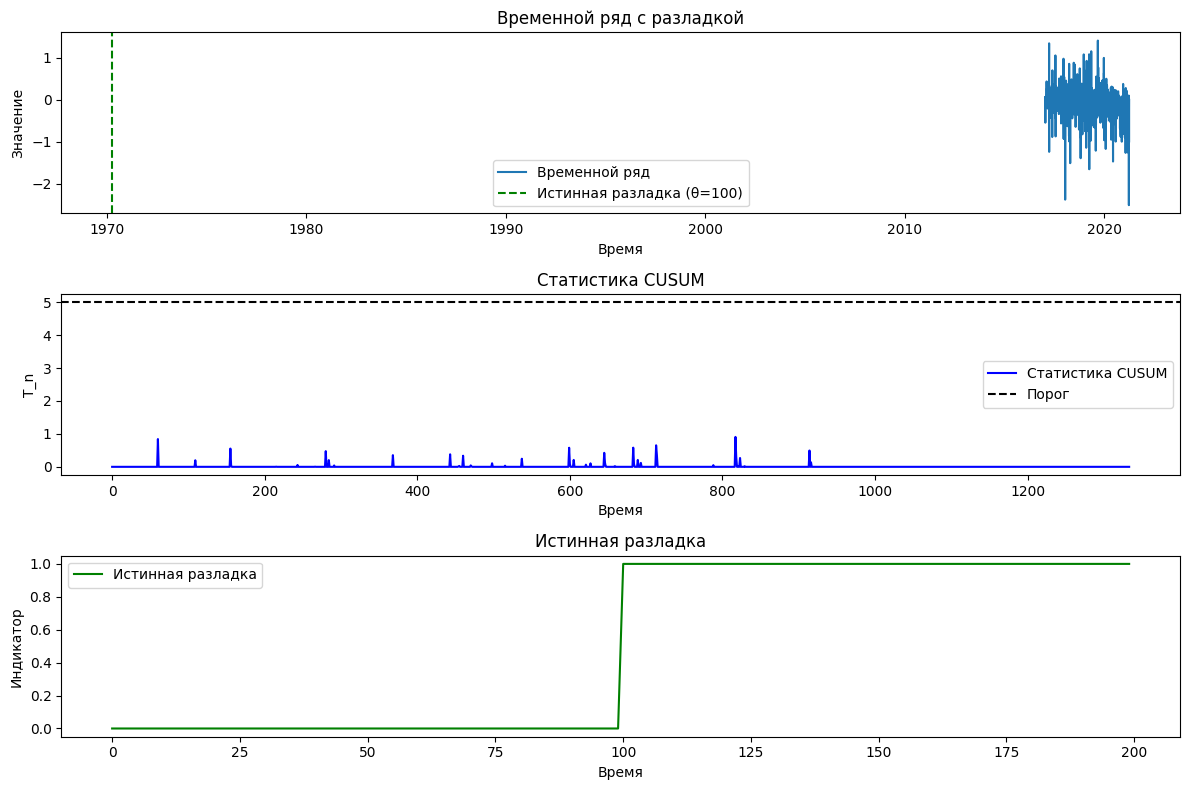